# Joint analysis of the "new to nature" space

1. Convert the enzyme variant to amino acids based on the AAs and be warned about 1 vs 0 so need to check
2. Calculate concentration rather than yield (if yield is given then yield * mmol concentration)
3. Normalize to parent for each column (TTN, Yield)
4. Embeddings sequences
5. Convert to LevSeq format

In [1]:
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

protein_ded_df = pd.read_pickle('output/protein-evolution-database_V5_proteins_reactions_clean_unique_variants_LLM.pkl')
protein_natural_df = pd.read_pickle('output/esm3_embeddings.pkl') #output/uniprotkb_reviewed_true_2025_17_02_ESM_3B_complete.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'output/protein-evolution-database_V5_proteins_reactions_clean_unique_variants_LLM.pkl'

In [3]:
# Imports 
import pandas as pd
from ast import literal_eval
import numpy as np
import os 
import sys
sys.path.append('/disk1/ariane/vscode/enzyme-tk')
from enzymetk.sequence_search_blast import BLAST
from enzymetk.similarity_foldseek_step import FoldSeek
from enzymetk.similarity_reaction_step import ReactionDist
from enzymetk.save_step import Save
import pandas as pd
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

## First build the training sets
from sciutil import SciUtil
from rdkit import Chem, DataStructs
from rdkit.Chem import rdChemReactions
from sklearn.metrics.pairwise import cosine_similarity


def clean_plt(ax):
    ax.tick_params(direction='out', length=2, width=1.0)
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=10.0)
    ax.tick_params(axis='x', which='major', pad=2.0)
    ax.tick_params(axis='y', which='major', pad=2.0)
    return ax
    
def reaction_tanimoto_similarity(rxn_smarts1, rxn_smarts2):
    # Used only to verify our target reactions - otherwise we do rxnfp distance.
    # Convert SMARTS strings to ChemicalReaction objects
    rxn1 = rdChemReactions.ReactionFromSmarts(rxn_smarts1)
    rxn2 = rdChemReactions.ReactionFromSmarts(rxn_smarts2)

    if rxn1 is None or rxn2 is None:
        raise ValueError("One or both reaction SMARTS are invalid.")

    # Generate structural fingerprints for reactions\
    fp_params = rdChemReactions.ReactionFingerprintParams()

    # Note: different results with a known bug if you do or don't pass the fp_params... 
    fp1 = rdChemReactions.CreateStructuralFingerprintForReaction(rxn1, ReactionFingerPrintParams=fp_params)
    fp2 = rdChemReactions.CreateStructuralFingerprintForReaction(rxn2, ReactionFingerPrintParams=fp_params)

    # Compute similarity
    return DataStructs.TanimotoSimilarity(fp1, fp2)

In [15]:
# This contains the rxnfp embeddings for all the reactions
reaction_df = pd.read_pickle('/disk1/ariane/vscode/cec_degrader/to_publish/data/enzymemap_v2_brenda2023_reactions.pkl')

In [19]:
reaction_df

,Unnamed: 0,rxn_idx,mapped,unmapped,orig_rxn_text,rule,rule_id,source,steps,quality,...,substrates_TPSA,substrates_MolLogP,substrates_MaxPartialCharge,substrates_MinPartialCharge,products_MolWt,products_TPSA,products_MolLogP,products_MaxPartialCharge,products_MinPartialCharge,rxnfp
0,217697,207073,[O:2]=[P:3]([OH:4])([OH:5])[O:6][CH2:7][C@H:8]...,O.O=P(O)(O)OC[C@H]1O[C@H](O[C@H]2O[C@H](CO)[C@...,"alpha,alpha-trehalose 6-phosphate + H2O = alph...",[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],279,direct,single,1.000000,...,267.56,-6.10490,0.057661,-0.639842,440.291,267.29,-6.32580,0.655796,-0.546608,"[-1.4060612916946411, -0.8044286370277405, -1...."
1,213467,202567,[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5][C:6](=[O:7...,CCCCCC(=O)N[C@H]1CCOC1=O.O>>CCCCCC(=O)N[C@@H](...,N-hexanoyl-L-homoserine lactone + H2O = N-hexa...,[#6:1]-[#8:2].[#8:3]>>([#8:2].[#6:1]-[#8:3]),287,direct,single,0.973366,...,86.90,0.17370,-0.083241,-0.456015,217.265,86.63,0.51850,0.325787,-0.044506,"[-1.1871312856674194, -0.33922845125198364, -0..."
2,213593,202652,[CH3:1][CH2:2][CH2:3][C:4](=[O:5])[NH:6][C@H:7...,CCCC(=O)N[C@H]1CCOC1=O.O>>CCCC(=O)N[C@@H](CCO)...,N-butyryl-L-homoserine lactone + H2O = N-butyr...,[#6:1]-[#8:2].[#8:3]>>([#8:2].[#6:1]-[#8:3]),287,direct,single,0.973366,...,86.90,-0.60650,-0.083241,-0.458869,189.211,86.63,-0.26170,0.325787,-0.047360,"[-1.1556289196014404, -0.30215218663215637, -0..."
3,213540,202609,[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5][C:6](=[O:7...,CCCCCC(=O)N[C@@H](CCO)C(=O)O>>CCCCCC(=O)N[C@H]...,N-hexanoyl-L-homoserine lactone + H2O = N-hexa...,[#6:1]-[#8:2].[#8:3]>>([#8:2].[#6:1]-[#8:3]),287,direct reversed,single,0.973366,...,86.63,0.51850,0.325787,-0.044506,217.265,86.90,0.17370,-0.083241,-0.456015,"[-1.0279208421707153, 2.324180841445923, -0.72..."
4,213245,202339,[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5][CH2:6][CH2...,CCCCCCCCCC(=O)CC(=O)N[C@H]1CCOC1=O.O>>CCCCCCCC...,N-3-oxododecanoyl-L-homoserine lactone + H2O =...,[#6:1]-[#8:2].[#8:3]>>([#8:2].[#6:1]-[#8:3]),287,direct,single,0.973366,...,103.97,1.69330,-0.083240,-0.457869,315.410,103.70,2.03810,0.325787,-0.046360,"[-1.145481824874878, -0.29215818643569946, -0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3139,134946,126075,[NH2:1][C:2](=[O:3])[CH2:4][CH2:5][C@H:6]([NH2...,NC(=O)CC[C@H](N)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O...,Gln-Tyr = pyroglutamic acid-Tyr + NH3,([#7:1].[#6:2]-[#7:3])>>[#6:2]-[#7:1].[#7:3],298,direct,single,0.964072,...,155.74,-0.90310,0.326047,-0.019954,309.322,150.73,-0.05530,-0.017879,-0.358807,"[-1.8373134136199951, 0.7371570467948914, -2.1..."
3140,134945,126074,[NH2:1][C:2](=[O:3])[CH2:4][CH2:5][C@H:6]([NH2...,NC(=O)CC[C@H](N)C(=O)N[C@@H](Cc1cnc[nH]1)C(=O)...,Gln-His-Pro = pyroglutamyl-His-Pro,([#7:1].[#6:2]-[#7:3])>>[#6:2]-[#7:1].[#7:3],298,suggested,single,0.964072,...,184.50,-1.89460,0.325916,-0.020010,380.405,179.49,-1.04680,-0.018010,-0.358807,"[-1.7083181142807007, 0.9184732437133789, -2.3..."
3141,134938,126069,[CH3:1][c:2]1[c:3]([NH:4][C:5](=[O:6])[C@@H:7]...,Cc1c(NC(=O)[C@@H](N)CCC(N)=O)c(=O)oc2ccccc12>>...,L-glutaminyl-4-methylcoumarinylamide = L-5-oxo...,([#7:1].[#6:2]-[#7:3])>>[#6:2]-[#7:1].[#7:3],298,direct,single,0.964072,...,128.42,0.63272,0.360051,-0.008995,303.318,123.41,1.48052,0.016126,-0.352920,"[-1.78736412525177, 1.06771981716156, -2.38623..."
3142,134944,126074,[NH2:1][C:2](=[O:3])[CH2:4][CH2:5][C@H:6]([NH2...,NC(=O)CC[C@H](N)C(=O)N[C@@H](Cc1cnc[nH]1)C(=O)...,Gln-His-Pro = pyroglutamyl-His-Pro,([#7:1].[#6:2]-[#7:3])>>[#6:2]-[#7:1].[#7:3],298,suggested,single,0.964072,...,184.50,-1.89460,0.325916,-0.020010,380.405,179.49,-1.04680,-0.018010,-0.358807,"[-1.7139207124710083, 0.9154084920883179, -2.3..."


In [16]:
rxn_ded_df = pd.read_pickle('output/rxn_rxnfp.pkl')
rxn_ded_df

,culture_collection_entry,enzyme_name_from_paper,Uniprot_ID(if applicable),comment,reaction_smiles,parent_DNA_sequence,parent_aminoacid_sequence,aminoacid_mutations_from_parent,variant_DNA_sequence,mutations_from_parent,...,paper title,doi,SUBMITTED BY,raw data name,cannonical_reactions,named_reactions,errors,id,chemberta,rxnfp
0,?,P411-L1,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,?,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,?,...,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021,CNc1ccccc1.[N-]=[N+]=C1CCOC1=O>>CN(c1ccccc1)[C...,3-diazooxolan-2-one + N-methylaniline =,NaN,RXN0,[-3.18922788e-01 1.72281623e-01 -6.81475759e-...,"[-1.3188741207122803, -0.9970054030418396, -1...."
1,4978,P411-L7_FL,?,3b,O=C1OCCC1=[N+]=[N-].CCNC1=CC=CC=C1>>O=C1OCC[C@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_A264S_T327P_S332A_Q437L+FAD,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,CCG-AGT-CCG-GCG-CTT+FAD,...,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021,CCNc1ccccc1.[N-]=[N+]=C1CCOC1=O>>CCN(c1ccccc1)...,3-diazooxolan-2-one + N-ethylaniline =,NaN,RXN1,[ 2.34055489e-01 1.24196954e-01 -7.48595834e-...,"[-1.4010109901428223, -1.1337487697601318, -2...."
2,4978,P411-L7_FL,?,3c,O=C1OCCC1=[N+]=[N-].CNC1=C(C)C=CC=C1>>O=C1OCC[...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_A264S_T327P_S332A_Q437L+FAD,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,CCG-AGT-CCG-GCG-CTT+FAD,...,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021,CNc1ccccc1C.[N-]=[N+]=C1CCOC1=O>>Cc1ccccc1N(C)...,"3-diazooxolan-2-one + N,2-dimethylaniline =",NaN,RXN2,[ 7.15660393e-01 2.18872964e-01 -1.25594771e+...,"[-1.552815556526184, -1.3202952146530151, -1.9..."
3,4978,P411-L7_FL,?,3d,O=C1OCCC1=[N+]=[N-].CNC1=CC=C(C)C=C1>>O=C1OCC[...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_A264S_T327P_S332A_Q437L+FAD,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,CCG-AGT-CCG-GCG-CTT+FAD,...,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021,CNc1ccc(C)cc1.[N-]=[N+]=C1CCOC1=O>>Cc1ccc(N(C)...,"3-diazooxolan-2-one + N,4-dimethylaniline =",NaN,RXN3,[ 6.79048836e-01 9.90635574e-01 -6.78689480e-...,"[-1.3945786952972412, -1.4061739444732666, -1...."
4,4978,P411-L7_FL,?,3e,O=C1OCCC1=[N+]=[N-].CNC1=CC=C(F)C=C1>>O=C1OCC[...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_A264S_T327P_S332A_Q437L+FAD,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,CCG-AGT-CCG-GCG-CTT+FAD,...,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021,CNc1ccc(F)cc1.[N-]=[N+]=C1CCOC1=O>>CN(c1ccc(F)...,3-diazooxolan-2-one + 4-fluoro-N-methylaniline =,NaN,RXN4,[ 8.95821750e-01 8.30273390e-01 -5.96083343e-...,"[-1.1718589067459106, -0.8995776772499084, -1...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,?,Rma-cyt-c-V75R_M100D_M103T,?,?,[BH3-]C1=[N+](C=CN1C)C.CC(C(OCC2=CC=CC=C2)=O)=...,ATGACTGAAAGCGGGACTGCTGCACAAGACCCGGAAGCACTGGCAG...,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,V75R_M100D_M103T,?,?,...,Genetically programmed chiral organoborane syn...,doi:10.1038/nature24996,?,NaN,CC(=[N+]=[N-])C(=O)OCc1ccccc1.[BH3-]c1n(C)cc[n...,"(1,3-dimethylimidazol-1-ium-2-yl)boranuide + b...",NaN,RXN635,[ 1.29792809e+00 2.51425266e-01 -1.06932926e+...,"[-1.0578553676605225, -1.1442961692810059, -0...."
636,NaN,Rma-cyt-c-V75R_M100D_M103F,

In [ ]:
from tqdm import tqdm
closest_dists = []
closest_rxns = []
closest_ids = []
for name, reaction_of_interest in rxn_ded_df[['id', 'reaction_smiles']].values:
    dists = []
    for reaction in tqdm(reaction_df['unmapped'].values):
        dists.append(reaction_tanimoto_similarity(reaction_of_interest, reaction))
    reaction_df['dists'] = dists
    reaction_df.to_pickle(f'output/reactions/reaction-similarity-{name}.pkl')
    sorted = reaction_df.sort_values(by='dists', ascending=False)
    u.dp([f'{name} closest distance:', sorted['dists'].values[0], '\nEC #', 
           sorted['ec_num'].values[0], '\n Query Reaction:', reaction_of_interest, '\n Target Reaction:', sorted['unmapped'].values[0]])
    closest_ids.append(sorted['id'].values[0])
    closest_rxns.append(sorted['unmapped'].values[0])
    closest_dists.append(sorted['dists'].values[0])
    #u.warn_p(['Top 10 rxns:', '\n'.join(sorted['mapped'].values[0:10]), '\nEC numbers:', '\n'.join(sorted['id'].values[0:10])])
rxn_ded_df[f'closest_dists_tanimoto'] = closest_dists
rxn_ded_df[f'closest_rxns_tanimoto'] = closest_rxns
rxn_ded_df[f'closest_ids_tanimoto'] = closest_ids



100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1851.93it/s]


--------------------------------------------------------------------------------
RXN0 closest distance:	0.4057142857142857	
EC #	3.1.1.3	
 Query Reaction:	O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@H]1N(C)C2=CC=CC=C2	
 Target Reaction:	C=COC(C)=O.CC(O)c1ccccc1>>C=CO.CC(=O)OC(C)c1ccccc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1833.02it/s]


--------------------------------------------------------------------------------
RXN1 closest distance:	0.38425925925925924	
EC #	4.2.1.20	
 Query Reaction:	O=C1OCCC1=[N+]=[N-].CCNC1=CC=CC=C1>>O=C1OCC[C@@H]1N(CC)C2=CC=CC=C2	
 Target Reaction:	N[C@@H](CO)C(=O)O.c1ccc2c(c1)CCN2>>N[C@@H](CN1CCc2ccccc21)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1825.57it/s]


--------------------------------------------------------------------------------
RXN2 closest distance:	0.3944954128440367	
EC #	4.1.99.11	
 Query Reaction:	O=C1OCCC1=[N+]=[N-].CNC1=C(C)C=CC=C1>>O=C1OCC[C@@H]1N(C)C2=C(C)C=CC=C2	
 Target Reaction:	Cc1ccccc1C.O=C(O)/C=C/C(=O)O>>Cc1ccccc1CC(CC(=O)O)C(=O)O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1829.46it/s]


--------------------------------------------------------------------------------
RXN3 closest distance:	0.38392857142857145	
EC #	4.2.1.84	
 Query Reaction:	O=C1OCCC1=[N+]=[N-].CNC1=CC=C(C)C=C1>>O=C1OCC[C@@H]1N(C)C2=CC=C(C)C=C2	
 Target Reaction:	COc1ccc(N2CC2C#N)cc1.O>>COc1ccc(N2CC2C(N)=O)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1828.66it/s]


--------------------------------------------------------------------------------
RXN4 closest distance:	0.38392857142857145	
EC #	4.1.99.11	
 Query Reaction:	O=C1OCCC1=[N+]=[N-].CNC1=CC=C(F)C=C1>>O=C1OCC[C@@H]1N(C)C2=CC=C(F)C=C2	
 Target Reaction:	Cc1ccc(F)cc1.O=C(O)/C=C/C(=O)O>>O=C(O)CC(Cc1ccc(F)cc1)C(=O)O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1807.90it/s]


--------------------------------------------------------------------------------
RXN5 closest distance:	0.42105263157894735	
EC #	4.2.1.20	
 Query Reaction:	O=C1OCCC1=[N+]=[N-].CN1C2=C(CC1)C=CC=C2>>O=C1OCC[C@@H]1N(CC2)C3=C2C=CC=C3	
 Target Reaction:	N[C@@H](CO)C(=O)O.c1ccc2c(c1)CCN2>>N[C@@H](CN1CCc2ccccc21)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1788.32it/s]


--------------------------------------------------------------------------------
RXN6 closest distance:	0.4413145539906103	
EC #	1.4.3.4	
 Query Reaction:	O=C1OCCC1=[N+]=[N-].CN1C2=C(CCC1)C=CC=C2>>O=C1OCC[C@@H]1N(CCC2)C3=C2C=CC=C3	
 Target Reaction:	NCCCN1CCc2ccccc21.O.O=O>>N.O=CCCN1CCc2ccccc21.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1870.88it/s]


--------------------------------------------------------------------------------
RXN7 closest distance:	0.4	
EC #	3.5.1.2	
 Query Reaction:	O=C1OCCC1=[N+]=[N-].NC1=CC=CC=C1>>O=C1OCCC1NC2=CC=CC=C2	
 Target Reaction:	N[C@@H](CCC(=O)O)C(=O)O.Nc1ccccc1>>N[C@@H](CCC(=O)O)C(=O)Nc1ccccc1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1848.48it/s]


--------------------------------------------------------------------------------
RXN8 closest distance:	0.400990099009901	
EC #	4.1.99.11	
 Query Reaction:	O=C1OCCC1=[N+]=[N-].NC1=C(C)C=CC=C1>>O=C1OCCC1NC2=C(C)C=CC=C2	
 Target Reaction:	Cc1ccccc1C.O=C(O)/C=C/C(=O)O>>Cc1ccccc1CC(CC(=O)O)C(=O)O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1848.91it/s]


--------------------------------------------------------------------------------
RXN9 closest distance:	0.3827751196172249	
EC #	4.1.99.11	
 Query Reaction:	O=C1OCCC1=[N+]=[N-].NC1=CC(C)=CC=C1>>O=C1OCCC1NC2=CC(C)=CC=C2	
 Target Reaction:	Cc1cccc(C)c1.O=C(O)/C=C/C(=O)O>>Cc1cccc(CC(CC(=O)O)C(=O)O)c1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1852.69it/s]


--------------------------------------------------------------------------------
RXN10 closest distance:	0.3870967741935484	
EC #	3.5.1.4	
 Query Reaction:	O=C1OCCC1=[N+]=[N-].NC1=CC=C(C)C=C1>>O=C1OCCC1NC2=CC=C(C)C=C2	
 Target Reaction:	CC(=O)O.Cc1ccc(N)cc1>>CC(=O)Nc1ccc(C)cc1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1836.00it/s]


--------------------------------------------------------------------------------
RXN11 closest distance:	0.43283582089552236	
EC #	4.1.2.38	
 Query Reaction:	O=C1OCCC1=[N+]=[N-].NC1=CC=C(OC)C=C1>>O=C1OCCC1NC2=CC=C(OC)C=C2	
 Target Reaction:	COCC=O.COc1ccc(C=O)cc1>>COC[C@@H](O)C(=O)c1ccc(OC)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1832.46it/s]


--------------------------------------------------------------------------------
RXN12 closest distance:	0.40331491712707185	
EC #	3.5.1.4	
 Query Reaction:	O=C1OCCC1=[N+]=[N-].NC1=C(C)C=CC=C1C>>O=C1OCCC1NC2=C(C)C=CC=C2C	
 Target Reaction:	CC(=O)O.Cc1cccc(C)c1N>>CC(=O)Nc1c(C)cccc1C.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1852.80it/s]


--------------------------------------------------------------------------------
RXN13 closest distance:	0.44559585492227977	
EC #	2.2.1.1	
 Query Reaction:	O=C1OCCC1=[N+]=[N-].NCC1=CC=CC=C1>>O=C1OCCC1NCC2=CC=CC=C2	
 Target Reaction:	O=C(O)C(=O)CO.O=CCCc1ccccc1>>O=C(CO)[C@@H](O)CCc1ccccc1.O=C=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1815.65it/s]


--------------------------------------------------------------------------------
RXN14 closest distance:	0.4074074074074074	
EC #	4.2.1.78	
 Query Reaction:	O=C1OCCC1=[N+]=[N-].NCC1=CC=C(OC)C=C1>>O=C1OCCC1NCC2=CC=C(OC)C=C2	
 Target Reaction:	COc1ccc(CC=O)cc1.NCCc1ccc(O)c(O)c1>>COc1ccc(CC2NCCc3cc(O)c(O)cc32)cc1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1816.15it/s]


--------------------------------------------------------------------------------
RXN15 closest distance:	0.4954128440366973	
EC #	3.1.1.74	
 Query Reaction:	O=C1OCCC1=[N+]=[N-].BrC(C=C1)=CC=C1CCN>>O=C1OCCC1NCCC2=CC=C(Br)C=C2	
 Target Reaction:	C=COC(=O)CCC.OCCc1ccc(O)cc1>>C=CO.CCCC(=O)OCCc1ccc(O)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1820.81it/s]


--------------------------------------------------------------------------------
RXN16 closest distance:	0.4411764705882353	
EC #	4.2.1.20	
 Query Reaction:	O=C1OCCC1=[N+]=[N-].C12=CC=CC=C1CNC2>>O=C1OCCC1N2CC3=C(C2)C=CC=C3	
 Target Reaction:	N[C@@H](CO)C(=O)O.c1ccc2c(c1)CCN2>>N[C@@H](CN1CCc2ccccc21)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1812.94it/s]


--------------------------------------------------------------------------------
RXN17 closest distance:	0.38735177865612647	
EC #	1.2.3.1	
 Query Reaction:	O=C(OCC)C=[N+]=[N-].CN1C=CC2=C1C=CC=C2>>CN1C=C(CC(OCC)=O)C2=C1C=CC=C2	
 Target Reaction:	COc1c(CC=O)ccc2ccccc12.O.O=O>>COc1c(CC(=O)O)ccc2ccccc12.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1789.29it/s]


--------------------------------------------------------------------------------
RXN18 closest distance:	0.36470588235294116	
EC #	4.1.2.38	
 Query Reaction:	O=C(OCC)C(C)=[N+]=[N-].CN1C=CC2=C1C=CC=C2>>CN1C=C(C(C)C(OCC)=O)C2=C1C=CC=C2	
 Target Reaction:	CCCC(C)C=O.CCCC(C)C=O.O=Cc1ccccc1.O=Cc1ccccc1>>CCCC(C)C(=O)C(O)c1ccccc1.CCC[C@H](C)[C@@H](O)C(=O)c1ccccc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1892.26it/s]


--------------------------------------------------------------------------------
RXN19 closest distance:	0.34615384615384615	
EC #	5.4.99.14	
 Query Reaction:	O=C(OCC)C=[N+]=[N-].CN1C=CC=C1>>CN1C=C(CC(OCC)=O)C=C1	
 Target Reaction:	CC1=CCOC(=O)C=C1>>CC1=CC(=O)OCC=C1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1780.88it/s]


--------------------------------------------------------------------------------
RXN20 closest distance:	0.33739837398373984	
EC #	3.1.1.74	
 Query Reaction:	O=C(C=[N+]=[N-])OCC.C12=C(CC=C2)C=CC=C1>>O=C(OCC)[C@H]1[C@@]2([H])C3=C(C[C@]21[H])C=CC=C3	
 Target Reaction:	C=COC(=O)CCC.OCCc1ccc(O)cc1>>C=CO.CCCC(=O)OCCc1ccc(O)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1852.20it/s]


--------------------------------------------------------------------------------
RXN21 closest distance:	0.2826086956521739	
EC #	2.2.1.5	
 Query Reaction:	O=C(C=[N+]=[N-])OCC.C1=CC=CCC1>>O=C(OCC)[C@H]1[C@@]2([H])CCC=C[C@]21[H]	
 Target Reaction:	CCCC(=O)C(=O)O.CCOC(=O)C=O>>CCCC(=O)[C@H](O)C(=O)OCC.O=C=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1829.36it/s]


--------------------------------------------------------------------------------
RXN22 closest distance:	0.4052631578947368	
EC #	3.4.22.2	
 Query Reaction:	O=C(OCC)C=[N+]=[N-].C12=C(NC=C2)C=CC=C1>>O=C(OCC)CC3=CNC4=C3C=CC=C4	
 Target Reaction:	CCSC(=O)O.NC(=O)c1ccccc1>>CCSC(=O)NC(=O)c1ccccc1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1792.59it/s]


--------------------------------------------------------------------------------
RXN23 closest distance:	0.3776223776223776	
EC #	2.2.1.12	
 Query Reaction:	O=C(OCC)C=[N+]=[N-].CN1C(C)=CC2=C1C=CC=C2>>CN3C(C)=C(CC(OCC)=O)C4=C3C=CC=C4	
 Target Reaction:	CC(=O)C(=O)O.COc1cc(/C=C/C(C)=O)ccc1O>>COc1cc([C@@H](CC(C)=O)C(C)=O)ccc1O.O=C=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1794.45it/s]


--------------------------------------------------------------------------------
RXN24 closest distance:	0.3767441860465116	
EC #	3.5.1.13	
 Query Reaction:	O=C(OCC)C=[N+]=[N-].CC1=CC2=C(NC=C2)C=C1>>O=C(OCC)CC3=C(C)NC4=C3C=C(C)C=C4	
 Target Reaction:	CC(=O)O.CCOc1ccc(N)cc1>>CCOc1ccc(NC(C)=O)cc1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1776.71it/s]


--------------------------------------------------------------------------------
RXN25 closest distance:	0.4135593220338983	
EC #	3.1.1.73	
 Query Reaction:	O=C(OCC)C=[N+]=[N-].COC1=CC2=C(NC=C2)C=C1>>O=C(OCC)CC3=C(C)NC4=C3C=C(OC)C=C4	
 Target Reaction:	CCCCO.COC(=O)/C=C/c1ccc(O)c(OC)c1>>CCCCOC(=O)/C=C/c1ccc(O)c(OC)c1.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1778.32it/s]


--------------------------------------------------------------------------------
RXN26 closest distance:	0.41237113402061853	
EC #	3.1.1.73	
 Query Reaction:	O=C(OCC)C=[N+]=[N-].COC1=CC2=C(C=C1)C=CN2>>O=C(OCC)CC3=C(C)NC4=C3C=CC(OC)=C4	
 Target Reaction:	CCCCO.COC(=O)/C=C/c1ccc(O)c(OC)c1>>CCCCOC(=O)/C=C/c1ccc(O)c(OC)c1.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1792.84it/s]


--------------------------------------------------------------------------------
RXN27 closest distance:	0.3724696356275304	
EC #	4.2.1.20	
 Query Reaction:	O=C(OCC)C=[N+]=[N-].ClC1=CC2=C(C=C1)C=CN2>>O=C(OCC)CC3=C(C)NC4=C3C=CC(Cl)=C4	
 Target Reaction:	Clc1ccc2cc[nH]c2c1.N[C@@H](CO)C(=O)O>>N[C@@H](Cc1c[nH]c2cc(Cl)ccc12)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1792.19it/s]


--------------------------------------------------------------------------------
RXN28 closest distance:	0.3991228070175439	
EC #	3.1.1.74	
 Query Reaction:	O=C(OCC)C=[N+]=[N-].BrC1=CC2=C(C=C1)C=CN2>>O=C(OCC)CC3=C(C)NC4=C3C=CC(Br)=C4	
 Target Reaction:	C=COC(=O)CC.OCCc1ccc(O)cc1>>C=CO.CCC(=O)OCCc1ccc(O)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1796.02it/s]


--------------------------------------------------------------------------------
RXN29 closest distance:	0.37398373983739835	
EC #	4.2.1.20	
 Query Reaction:	O=C(OCC)C=[N+]=[N-].CC1=CC=CC2=C1NC=C2>>O=C(OCC)CC3=C(C)NC4=C3C=CC=C4C	
 Target Reaction:	Cc1cccc2cc[nH]c12.N[C@@H](CO)C(=O)O>>Cc1cccc2c(C[C@H](N)C(=O)O)c[nH]c12.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1792.82it/s]


--------------------------------------------------------------------------------
RXN30 closest distance:	0.364	
EC #	4.2.1.20	
 Query Reaction:	O=C(OCC)C=[N+]=[N-].ClC1=CC=CC2=C1NC=C2>>O=C(OCC)CC3=C(C)NC4=C3C=CC=C4Cl	
 Target Reaction:	Clc1cccc2cc[nH]c12.N[C@@H](CO)C(=O)O>>N[C@@H](Cc1c[nH]c2c(Cl)cccc12)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1789.89it/s]


--------------------------------------------------------------------------------
RXN31 closest distance:	0.3900414937759336	
EC #	4.1.1.7	
 Query Reaction:	O=C(OCC)C=[N+]=[N-].BrC1=CC=CC2=C1NC=C2>>O=C(OCC)CC3=C(C)NC4=C3C=CC=C4Br	
 Target Reaction:	CCOc1cc(C=O)ccc1O.O=C=O>>CCOc1cc(C(=O)C(=O)O)ccc1O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1797.44it/s]


--------------------------------------------------------------------------------
RXN32 closest distance:	0.3881856540084388	
EC #	4.2.1.84	
 Query Reaction:	CCC#CC1=CC=CC=C1.O=C(OCC)C=[N+]=[N-]>>[H][C@]2(C(OCC)=O)C(CC)=C2C3=CC=CC=C3	
 Target Reaction:	CCOC(=O)c1ccccc1C#N.O>>CCOC(=O)c1ccccc1C(N)=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1774.54it/s]


--------------------------------------------------------------------------------
RXN33 closest distance:	0.3527272727272727	
EC #	2.2.1.12	
 Query Reaction:	ClC(C=C1)=CC=C1C#CCC.O=C(OCC)C=[N+]=[N-]>>[H][C@]2(C(OCC)=O)C(CC)=C2C3=CC=C(Cl)C=C3	
 Target Reaction:	CC(=O)/C=C/c1ccc(Cl)cc1.CC(=O)C(=O)O>>CC(=O)C[C@@H](C(C)=O)c1ccc(Cl)cc1.O=C=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1820.07it/s]


--------------------------------------------------------------------------------
RXN34 closest distance:	0.3701923076923077	
EC #	3.4.22.2	
 Query Reaction:	CC#CC1=CC=CC=C1.O=C(OCC)C=[N+]=[N-]>>CC([C@]2([H])C(OCC)=O)=C2C3=CC=CC=C3	
 Target Reaction:	CCSC(=O)O.NC(=O)c1ccccc1>>CCSC(=O)NC(=O)c1ccccc1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1772.39it/s]


--------------------------------------------------------------------------------
RXN35 closest distance:	0.37209302325581395	
EC #	4.2.1.84	
 Query Reaction:	FC1=CC=CC=C1C#CCC.O=C(OCC)C=[N+]=[N-]>>[H][C@]2(C(OCC)=O)C(CC)=C2C3=CC=CC=C3F	
 Target Reaction:	CCOC(=O)c1ccccc1C#N.O>>CCOC(=O)c1ccccc1C(N)=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1774.64it/s]


--------------------------------------------------------------------------------
RXN36 closest distance:	0.35331230283911674	
EC #	3.1.1.73	
 Query Reaction:	FC(C=C1)=CC=C1C#CCC.O=C(OCC)C=[N+]=[N-]>>[H][C@]2(C(OCC)=O)C(CC)=C2C3=CC=C(F)C=C3	
 Target Reaction:	CCCCO.COC(=O)/C=C/c1ccc(O)c(OC)c1>>CCCCOC(=O)/C=C/c1ccc(O)c(OC)c1.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1752.21it/s]


--------------------------------------------------------------------------------
RXN37 closest distance:	0.41139240506329117	
EC #	3.1.1.73	
 Query Reaction:	CCC#CC1=CC(OC)=CC=C1.O=C(OCC)C=[N+]=[N-]>>[H][C@]2(C(OCC)=O)C(CC)=C2C3=CC(OC)=CC=C3	
 Target Reaction:	CCCCO.COC(=O)/C=C/c1ccc(O)c(OC)c1>>CCCCOC(=O)/C=C/c1ccc(O)c(OC)c1.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1716.80it/s]


--------------------------------------------------------------------------------
RXN38 closest distance:	0.35082872928176795	
EC #	3.5.5.1	
 Query Reaction:	CCC#CC1=CC=C(C(F)(F)F)C=C1.O=C(OCC)C=[N+]=[N-]>>[H][C@]2(C(OCC)=O)C(CC)=C2C3=CC=C(C(F)(F)F)C=C3	
 Target Reaction:	N#CCC(CC#N)c1ccc(C(F)(F)F)cc1.O>>N#CCC(CC(N)=O)c1ccc(C(F)(F)F)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1714.08it/s]


--------------------------------------------------------------------------------
RXN39 closest distance:	0.339572192513369	
EC #	3.1.1.73	
 Query Reaction:	CCC#CC1=CC=C(OC(F)F)C=C1.O=C(OCC)C=[N+]=[N-]>>[H][C@]2(C(OCC)=O)C(CC)=C2C3=CC=C(OC(F)F)C=C3	
 Target Reaction:	CCCCO.COC(=O)/C=C/c1ccc(O)c(OC)c1>>CCCCOC(=O)/C=C/c1ccc(O)c(OC)c1.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1774.26it/s]


--------------------------------------------------------------------------------
RXN40 closest distance:	0.3729903536977492	
EC #	3.1.1.73	
 Query Reaction:	CC(C=C1)=CC=C1C#CCC.O=C(OCC)C=[N+]=[N-]>>[H][C@]2(C(OCC)=O)C(CC)=C2C3=CC=C(C)C=C3	
 Target Reaction:	CCCCO.COC(=O)/C=C/c1ccc(O)c(OC)c1>>CCCCOC(=O)/C=C/c1ccc(O)c(OC)c1.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1751.88it/s]


--------------------------------------------------------------------------------
RXN41 closest distance:	0.43450479233226835	
EC #	3.1.1.73	
 Query Reaction:	CCC#CC1=CC=C(OC)C=C1.O=C(OCC)C=[N+]=[N-]>>[H][C@]2(C(OCC)=O)C(CC)=C2C3=CC=C(OC)C=C3	
 Target Reaction:	CCCCO.COC(=O)/C=C/c1ccc(O)c(OC)c1>>CCCCOC(=O)/C=C/c1ccc(O)c(OC)c1.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1744.45it/s]


--------------------------------------------------------------------------------
RXN42 closest distance:	0.34767025089605735	
EC #	4.2.1.84	
 Query Reaction:	ClC(C=C1)=C(C)C=C1C#CCC.O=C(OCC)C=[N+]=[N-]>>[H][C@]2(C(OCC)=O)C(CC)=C2C3=CC(C)=C(Cl)C=C3	
 Target Reaction:	CCOC(=O)c1cccc(C#N)c1.O>>CCOC(=O)c1cccc(C(N)=O)c1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:57<00:00, 1101.11it/s]


--------------------------------------------------------------------------------
RXN43 closest distance:	0.3993993993993994	
EC #	3.1.1.73	
 Query Reaction:	CC1=C(OC)C=CC(C#CCC)=C1.O=C(OCC)C=[N+]=[N-]>>[H][C@]2(C(OCC)=O)C(CC)=C2C3=CC(C)=C(OC)C=C3	
 Target Reaction:	CCCCO.COC(=O)/C=C/c1ccc(O)c(OC)c1>>CCCCOC(=O)/C=C/c1ccc(O)c(OC)c1.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [01:00<00:00, 1039.63it/s]


--------------------------------------------------------------------------------
RXN44 closest distance:	0.3086816720257235	
EC #	3.5.1.11	
 Query Reaction:	CCOCCC#CCC.O=C(OCC)C=[N+]=[N-]>>[H][C@]1(C(OCC)=O)C(CC)=C1CCOCC	
 Target Reaction:	CCCCCCCC(=O)OC.COc1cc(CN)ccc1O>>CCCCCCCC(=O)c1cc(O)c(OC)cc1CN.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1817.01it/s]


--------------------------------------------------------------------------------
RXN45 closest distance:	0.3523809523809524	
EC #	3.5.1.11	
 Query Reaction:	CCCCCC#CCOC.O=C(OCC)C=[N+]=[N-]>>CCCCCC1=C(COC)[C@]1([H])C(OCC)=O	
 Target Reaction:	CCCCCCCC(=O)OC.COc1cc(CN)ccc1O>>CCCCCCCC(=O)c1cc(O)c(OC)cc1CN.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1836.72it/s]


--------------------------------------------------------------------------------
RXN46 closest distance:	0.40716612377850164	
EC #	5.3.3.8	
 Query Reaction:	CCCCCC#CCOC.O=C(OCC)C=[N+]=[N-]>>CCCCCC#C[C@H](CC(OCC)=O)OC	
 Target Reaction:	CCCCCCC#CCC(=O)N(CCS)C(C)=O>>CCCCCCC#CCC(=O)N(CCS)C(C)=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1839.61it/s]


--------------------------------------------------------------------------------
RXN47 closest distance:	0.3712374581939799	
EC #	3.5.1.11	
 Query Reaction:	CCCCCC#CCOC.O=C(OCC)C=[N+]=[N-]>>CCCCCC1=C(COC)C=C(OCC)O1	
 Target Reaction:	CCCCCCCC(=O)OC.COc1cc(CN)ccc1O>>CCCCCCCC(=O)c1cc(O)c(OC)cc1CN.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1805.90it/s]


--------------------------------------------------------------------------------
RXN48 closest distance:	0.3598326359832636	
EC #	4.1.99.11	
 Query Reaction:	CC1=CC=C(N(C)C)C=C1.O=C2OCCC2=[N+]=[N-]>>CC3=CC=C(N(C)C[C@H]4CCOC4=O)C=C3	
 Target Reaction:	Cc1ccccc1C.O=C(O)/C=C/C(=O)O>>Cc1ccccc1CC(CC(=O)O)C(=O)O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1792.29it/s]


--------------------------------------------------------------------------------
RXN49 closest distance:	0.36947791164658633	
EC #	3.3.2.9	
 Query Reaction:	CN(C)C1=CC=C(OC)C=C1.O=C2OCCC2=[N+]=[N-]>>CN(CC3CCOC3=O)C4=CC=C(OC)C=C4	
 Target Reaction:	COc1ccc(OCC2CO2)cc1.O>>COc1ccc(OCC(O)CO)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1811.42it/s]


--------------------------------------------------------------------------------
RXN50 closest distance:	0.36213991769547327	
EC #	3.4.23.1	
 Query Reaction:	ClC1=CC=C(N(C)C)C=C1.O=C2OCCC2=[N+]=[N-]>>ClC3=CC=C(N(C)CC4CCOC4=O)C=C3	
 Target Reaction:	O=C1CCCCC1.O=Cc1ccc(Cl)cc1>>O=C1CCCC[C@H]1[C@@H](O)c1ccc(Cl)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1808.50it/s]


--------------------------------------------------------------------------------
RXN51 closest distance:	0.3661417322834646	
EC #	2.6.1.42	
 Query Reaction:	CN(C)C1=CC(C)=CC=C1.O=C2OCCC2=[N+]=[N-]>>CN(CC3CCOC3=O)C4=CC(C)=CC=C4	
 Target Reaction:	CC(C)CC(=O)C(=O)O.Cc1ccccc1CN>>CN.Cc1ccccc1CC(C)CC(=O)C(=O)O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1827.19it/s]


--------------------------------------------------------------------------------
RXN52 closest distance:	0.3665158371040724	
EC #	4.1.99.11	
 Query Reaction:	CN(C)C1=CC=CC=C1.O=C2OCCC2=[N+]=[N-]>>CN(CC3CCOC3=O)C4=CC=CC=C4	
 Target Reaction:	Cc1ccccc1C.O=C(O)/C=C/C(=O)O>>Cc1ccccc1CC(CC(=O)O)C(=O)O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1806.47it/s]


--------------------------------------------------------------------------------
RXN53 closest distance:	0.3793103448275862	
EC #	4.1.99.11	
 Query Reaction:	CN(C)C1=C(C)C=CC=C1.O=C2OCCC2=[N+]=[N-]>>CN(CC3CCOC3=O)C4=C(C)C=CC=C4	
 Target Reaction:	Cc1ccccc1C.O=C(O)/C=C/C(=O)O>>Cc1ccccc1CC(CC(=O)O)C(=O)O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1814.23it/s]


--------------------------------------------------------------------------------
RXN54 closest distance:	0.3964757709251101	
EC #	4.2.1.20	
 Query Reaction:	CN(CC)C1=CC=CC=C1.O=C2OCCC2=[N+]=[N-]>>O=C3OCCC3CN(CC)C4=CC=CC=C4	
 Target Reaction:	N[C@@H](CO)C(=O)O.c1ccc2c(c1)CCN2>>N[C@@H](CN1CCc2ccccc21)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1809.69it/s]


--------------------------------------------------------------------------------
RXN55 closest distance:	0.3522267206477733	
EC #	4.1.2.38	
 Query Reaction:	CN(CC)C1=CC=CC=C1.O=C2OCCC2=[N+]=[N-]>>CN(C(C)C5CCOC5=O)C6=CC=CC=C6	
 Target Reaction:	CCCC(C)C=O.CCCC(C)C=O.O=Cc1ccccc1.O=Cc1ccccc1>>CCCC(C)C(=O)C(O)c1ccccc1.CCC[C@H](C)[C@@H](O)C(=O)c1ccccc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:37<00:00, 1688.53it/s]


--------------------------------------------------------------------------------
RXN56 closest distance:	0.364	
EC #	4.2.1.20	
 Query Reaction:	CN(CC)C1=CC=CC=C1.O=C2OCCC2=[N+]=[N-]>>O=C3OCCC3CN(CC)C4=CC=CC=C4.CN(C(C)C5CCOC5=O)C6=CC=CC=C6	
 Target Reaction:	N[C@@H](CO)C(=O)O.c1ccc2c(c1)CCN2>>N[C@@H](CN1CCc2ccccc21)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1793.22it/s]


--------------------------------------------------------------------------------
RXN57 closest distance:	0.3697478991596639	
EC #	4.1.2.38	
 Query Reaction:	CCN(CC)C1=CC=CC=C1.O=C2OCCC2=[N+]=[N-]>>O=C3OCCC3C(C)N(CC)C4=CC=CC=C4	
 Target Reaction:	CCCC(C)C=O.O=Cc1ccccc1>>CCCC(C)[C@@H](O)C(=O)c1ccccc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1791.10it/s]


--------------------------------------------------------------------------------
RXN58 closest distance:	0.4009433962264151	
EC #	4.1.1.1	
 Query Reaction:	O=C1OCCC1=[N+]=[N-].C2(N3CCCC3)=CC=CC=C2>>O=C4OCCC4C5CCCN5C6=CC=CC=C6	
 Target Reaction:	O=C=O.O=CCCCc1ccccc1>>O=C(O)C(=O)CCCc1ccccc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1762.77it/s]


--------------------------------------------------------------------------------
RXN59 closest distance:	0.38372093023255816	
EC #	3.4.23.1	
 Query Reaction:	ClC1=CC=CC(N2CCCC2)=C1.O=C3OCCC3=[N+]=[N-]>>O=C4OCCC4C5CCCN5C6=CC(Cl)=CC=C6	
 Target Reaction:	O=C1CCCCC1.O=Cc1ccc(Cl)cc1>>O=C1CCCC[C@H]1[C@@H](O)c1ccc(Cl)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1740.62it/s]


--------------------------------------------------------------------------------
RXN60 closest distance:	0.35634743875278396	
EC #	4.3.3.2	
 Query Reaction:	CC1=CC=CC(N2CCCC2)=C1C.O=C3OCCC3=[N+]=[N-]>>O=C4OCCC4C5CCCN5C6=C(C)C(C)=CC=C6	
 Target Reaction:	CCO[C@@H]1C[C@H](CC=O)C(C(=O)OC)=CO1.NCCc1c[nH]c2ccccc12>>CCO[C@@H]1C[C@H](C[C@@H]2NCCc3c2[nH]c2ccccc32)C(C(=O)OC)=CO1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1743.21it/s]


--------------------------------------------------------------------------------
RXN61 closest distance:	0.39636363636363636	
EC #	4.2.1.84	
 Query Reaction:	COC1=CC=C(N2CCCC2)C=C1.O=C3OCCC3=[N+]=[N-]>>O=C4OCCC4C5CCCN5C6=CC=C(OC)C=C6	
 Target Reaction:	COc1ccc(N2CC2C#N)cc1.O>>COc1ccc(N2CC2C(N)=O)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1731.90it/s]


--------------------------------------------------------------------------------
RXN62 closest distance:	0.36395759717314485	
EC #	3.4.23.1	
 Query Reaction:	FC1=C(Cl)C=C(N2CCCC2)C=C1.O=C3OCCC3=[N+]=[N-]>>O=C4OCCC4C5CCCN5C6=CC(Cl)=C(F)C=C6	
 Target Reaction:	O=C1CCCCC1.O=Cc1ccc(Cl)cc1>>O=C1CCCC[C@H]1[C@@H](O)c1ccc(Cl)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1805.17it/s]


--------------------------------------------------------------------------------
RXN63 closest distance:	0.41379310344827586	
EC #	4.1.1.1	
 Query Reaction:	O=C1OCCC1=[N+]=[N-].C2(N3CCC3)=CC=CC=C2>>O=C4OCCC4C5CCN5C6=CC=CC=C6	
 Target Reaction:	O=C=O.O=CCCCc1ccccc1>>O=C(O)C(=O)CCCc1ccccc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:32<00:00, 1936.42it/s]


--------------------------------------------------------------------------------
RXN64 closest distance:	0.5543478260869565	
EC #	1.11.2.1	
 Query Reaction:	[H][Si](C)(C)C1=CC=CC=C1.O=O>>O[Si](C)(C)C2=CC=CC=C2	
 Target Reaction:	CCc1ccccc1.OO>>CC(O)c1ccccc1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:32<00:00, 1918.23it/s]


--------------------------------------------------------------------------------
RXN65 closest distance:	0.5855855855855856	
EC #	1.11.2.1	
 Query Reaction:	[H][Si](CC)(C)C1=CC=CC=C1.O=O>>O[Si](C)(CC)C2=CC=CC=C2	
 Target Reaction:	CCCc1ccccc1.OO>>CC[C@@H](O)c1ccccc1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:32<00:00, 1913.61it/s]


--------------------------------------------------------------------------------
RXN66 closest distance:	0.46846846846846846	
EC #	1.11.2.1	
 Query Reaction:	[H][Si](C=C)(C)C1=CC=CC=C1.O=O>>O[Si](C)(C=C)C2=CC=CC=C2	
 Target Reaction:	CCc1ccccc1.OO>>CC(O)c1ccccc1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:32<00:00, 1916.77it/s]


--------------------------------------------------------------------------------
RXN67 closest distance:	0.48333333333333334	
EC #	1.11.2.1	
 Query Reaction:	C[Si](C)([H])CC1=CC=CC=C1.O=O>>C[Si](C)(O)CC2=CC=CC=C2	
 Target Reaction:	CCCc1ccccc1.OO>>CC[C@@H](O)c1ccccc1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:32<00:00, 1913.90it/s]


--------------------------------------------------------------------------------
RXN68 closest distance:	0.432	
EC #	1.4.3.12	
 Query Reaction:	[H][Si](C)(C)C1=CC=C(C)C=C1.O=O>>O[Si](C)(C)C2=CC=C(C)C=C2	
 Target Reaction:	Cc1ccc([C@H](C)N)cc1.O.O=O>>CC(=O)c1ccc(C)cc1.N.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1874.88it/s]


--------------------------------------------------------------------------------
RXN69 closest distance:	0.4267515923566879	
EC #	1.1.3.7	
 Query Reaction:	[H][Si](C)(C)C1=CC=C(C(C)C)C=C1.O=O>>O[Si](C)(C)C2=CC=C(C(C)C)C=C2	
 Target Reaction:	CC(C)c1ccc(CO)cc1.O=O>>CC(C)c1ccc(C=O)cc1.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:32<00:00, 1943.40it/s]


--------------------------------------------------------------------------------
RXN70 closest distance:	0.31	
EC #	1.11.2.1	
 Query Reaction:	[H][Si](C)(C)C1=CC=CS1.O=O>>O[Si](C)(C)C2=CC=CS2	
 Target Reaction:	CCc1ccccc1.OO>>C[C@@H](O)c1ccccc1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1856.67it/s]


--------------------------------------------------------------------------------
RXN71 closest distance:	0.35377358490566035	
EC #	1.2.3.1	
 Query Reaction:	[H][Si](C)(C)C1=CC(C=CC=C2)=C2S1.O=O>>O[Si](C)(C)C3=CC(C=CC=C4)=C4S3	
 Target Reaction:	COc1ccc2cccc(C=O)c2c1.O.O=O>>COc1ccc2cccc(C(=O)O)c2c1.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1835.26it/s]


--------------------------------------------------------------------------------
RXN72 closest distance:	0.49162011173184356	
EC #	1.4.3.3	
 Query Reaction:	C[Si](C1=CC=CC=C1)([H])C2=CC=CC=C2.O=O>>C[Si](C3=CC=CC=C3)(O)C4=CC=CC=C4	
 Target Reaction:	NC(c1ccccc1)c1ccccc1.O.O=O>>N.O=C(c1ccccc1)c1ccccc1.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:31<00:00, 1988.09it/s]


--------------------------------------------------------------------------------
RXN73 closest distance:	0.36065573770491804	
EC #	1.11.2.1	
 Query Reaction:	CC[Si](CC)([H])CC.O=O>>CC[Si](CC)(O)CC	
 Target Reaction:	CCCCCCC.OO>>CCCCC(O)CC.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:31<00:00, 1982.26it/s]


--------------------------------------------------------------------------------
RXN74 closest distance:	0.417910447761194	
EC #	1.11.2.1	
 Query Reaction:	CCCC[Si](C)([H])C.O=O>>CCCC[Si](C)(O)C	
 Target Reaction:	CCCCCCC.OO>>CCCCCC(C)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:31<00:00, 1967.87it/s]


--------------------------------------------------------------------------------
RXN75 closest distance:	0.328125	
EC #	1.11.2.1	
 Query Reaction:	C[Si]([H])(O[Si](C)(C)C)C.O=O>>C[Si](O)(O[Si](C)(C)C)C	
 Target Reaction:	CC(C)OC(C)C.OO>>CC(C)OC(C)(C)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1784.31it/s]


--------------------------------------------------------------------------------
RXN76 closest distance:	0.5605381165919282	
EC #	4.2.1.20	
 Query Reaction:	N[C@@H](CO)C(O)=O.O=C1NC2=CC=CC=C2C1C>>O=C3NC4=CC=CC=C4C3(C[C@H](N)C(O)=O)C	
 Target Reaction:	Cc1cc2ccccc2[nH]1.N[C@@H](CO)C(=O)O>>Cc1[nH]c2ccccc2c1C[C@H](N)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1754.36it/s]


--------------------------------------------------------------------------------
RXN77 closest distance:	0.5101214574898786	
EC #	4.2.1.20	
 Query Reaction:	N[C@@H](CO)C(O)=O.O=C1NC2=CC(Cl)=CC=C2C1C>>O=C3NC4=CC(Cl)=CC=C4C3(C[C@H](N)C(O)=O)C	
 Target Reaction:	Clc1ccc2cc[nH]c2c1.N[C@@H](CO)C(=O)O>>N[C@@H](Cc1c[nH]c2cc(Cl)ccc12)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1754.67it/s]


--------------------------------------------------------------------------------
RXN78 closest distance:	0.49019607843137253	
EC #	4.2.1.20	
 Query Reaction:	N[C@@H](CO)C(O)=O.O=C1NC2=CC=C(F)C=C2C1C>>O=C3NC4=CC=C(F)C=C4C3(C[C@H](N)C(O)=O)C	
 Target Reaction:	Fc1ccc2[nH]ccc2c1.N[C@@H](CO)C(=O)O>>N[C@@H](Cc1c[nH]c2ccc(F)cc12)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1782.68it/s]


--------------------------------------------------------------------------------
RXN79 closest distance:	0.5422222222222223	
EC #	4.2.1.20	
 Query Reaction:	N[C@@H](CO)C(O)=O.O=C1OC2=CC=CC=C2C1C>>O=C3OC4=CC=CC=C4C3(C[C@H](N)C(O)=O)C	
 Target Reaction:	Cc1cc2ccccc2[nH]1.N[C@@H](CO)C(=O)O>>Cc1[nH]c2ccccc2c1C[C@H](N)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1769.91it/s]


--------------------------------------------------------------------------------
RXN80 closest distance:	0.48878923766816146	
EC #	4.2.1.20	
 Query Reaction:	N[C@@H](CO)C(O)=O.O=C1CC2=CC=CC=C2C1C>>C[C@@]34[C@@](N[C@H](C(O)=O)C4)(O)CC5=CC=CC=C53	
 Target Reaction:	N[C@@H](CO)C(=O)O.c1ccc2c(c1)CCN2>>N[C@@H](CN1CCc2ccccc21)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1763.37it/s]


--------------------------------------------------------------------------------
RXN81 closest distance:	0.5485232067510548	
EC #	4.2.1.20	
 Query Reaction:	N[C@@H](CO)C(O)=O.O=C1NC2=CC=CC=C2C1CC>>O=C3NC4=CC=CC=C4C3(C[C@H](N)C(O)=O)CC	
 Target Reaction:	Cc1cc2ccccc2[nH]1.N[C@@H](CO)C(=O)O>>Cc1[nH]c2ccccc2c1C[C@H](N)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1745.12it/s]


--------------------------------------------------------------------------------
RXN82 closest distance:	0.5141700404858299	
EC #	4.2.1.20	
 Query Reaction:	N[C@@H](CO)C(O)=O.O=C1NC2=CC=CC=C2C1CCC>>O=C3NC4=CC=CC=C4C3(C[C@H](N)C(O)=O)CCC	
 Target Reaction:	N[C@@H](CO)C(=O)O.c1ccc2c(c1)CCN2>>N[C@@H](CN1CCc2ccccc21)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1725.72it/s]


--------------------------------------------------------------------------------
RXN83 closest distance:	0.46691176470588236	
EC #	4.2.1.20	
 Query Reaction:	N[C@@H](CO)C(O)=O.O=C1NC2=CC=CC=C2C1CCCC>>O=C3NC4=CC=CC=C4C3(C[C@H](N)C(O)=O)CCCC	
 Target Reaction:	N[C@@H](CO)C(=O)O.c1ccc2c(c1)CCN2>>N[C@@H](CN1CCc2ccccc21)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1786.50it/s]


--------------------------------------------------------------------------------
RXN84 closest distance:	0.5	
EC #	4.2.1.122	
 Query Reaction:	N[C@@H](CO)C(O)=O.O=C1NC2=CC=CC=C2C1O>>O=C3NC4=CC=CC=C4C3(C[C@H](N)C(O)=O)O	
 Target Reaction:	N[C@@H](CO)C(=O)O.Oc1cccc2cc[nH]c12>>N[C@@H](Cc1c[nH]c2c(O)cccc12)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1772.13it/s]


--------------------------------------------------------------------------------
RXN85 closest distance:	0.5384615384615384	
EC #	4.2.1.20	
 Query Reaction:	N[C@@H](CO)C(O)=O.O=C1NC2=CC=CC=C2C1C>>O=C3N(C)C4=CC=CC=C4C3(C[C@H](N)C(O)=O)C	
 Target Reaction:	Cc1cc2ccccc2[nH]1.N[C@@H](CO)C(=O)O>>Cc1[nH]c2ccccc2c1C[C@H](N)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1829.81it/s]


--------------------------------------------------------------------------------
RXN86 closest distance:	0.3258426966292135	
EC #	2.6.1.18	
 Query Reaction:	CCC#CC1=CC=CC=C1.NOC(C(C)(C)C)=O.O=S(C(F)(F)F)(O)=O>>C[C@@H](N)C#CC2=CC=CC=C2	
 Target Reaction:	CC(=O)CCc1ccccc1.CC(C)N>>CC(C)=O.CC(N)CCc1ccccc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1805.84it/s]


--------------------------------------------------------------------------------
RXN87 closest distance:	0.32978723404255317	
EC #	1.11.2.1	
 Query Reaction:	CCCC#CC1=CC=CC=C1.NOC(C(C)(C)C)=O.O=S(C(F)(F)F)(O)=O>>N[C@H](CC)C#CC2=CC=CC=C2	
 Target Reaction:	CCCCCc1ccccc1.OO>>CCCCC(O)c1ccccc1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1787.18it/s]


--------------------------------------------------------------------------------
RXN88 closest distance:	0.3024390243902439	
EC #	1.11.2.1	
 Query Reaction:	CCCCC#CC1=CC=CC=C1.NOC(C(C)(C)C)=O.O=S(C(F)(F)F)(O)=O>>N[C@H](CCC)C#CC2=CC=CC=C2	
 Target Reaction:	CCCCCc1ccccc1.OO>>CCCCC(O)c1ccccc1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1801.84it/s]


--------------------------------------------------------------------------------
RXN89 closest distance:	0.3004115226337449	
EC #	4.1.2.10	
 Query Reaction:	CCC#CC1=C(F)C=CC=C1.NOC(C(C)(C)C)=O.O=S(C(F)(F)F)(O)=O>>C[C@@H](N)C#CC2=C(F)C=CC=C2	
 Target Reaction:	C#N.CC(C=O)c1ccc2ccccc2c1>>CC(c1ccc2ccccc2c1)C(O)C#N	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1782.09it/s]


--------------------------------------------------------------------------------
RXN90 closest distance:	0.3568075117370892	
EC #	3.1.1.1	
 Query Reaction:	CCC#CC1=CC(OC)=CC=C1.NOC(C(C)(C)C)=O.O=S(C(F)(F)F)(O)=O>>C[C@@H](N)C#CC2=CC(OC)=CC=C2	
 Target Reaction:	CCOC(=O)c1cccc(OC)c1.O>>CCO.COc1cccc(C(=O)O)c1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1801.72it/s]


--------------------------------------------------------------------------------
RXN91 closest distance:	0.32275132275132273	
EC #	3.1.1.2	
 Query Reaction:	CCC#CC1=CC(C)=CC=C1.NOC(C(C)(C)C)=O.O=S(C(F)(F)F)(O)=O>>C[C@@H](N)C#CC2=CC(C)=CC=C2	
 Target Reaction:	CC(=O)Oc1cccc(C#N)c1.O>>CC(=O)O.N#Cc1cccc(O)c1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1804.80it/s]


--------------------------------------------------------------------------------
RXN92 closest distance:	0.2987551867219917	
EC #	2.6.1.21	
 Query Reaction:	CCC#CC1=CC=C(C)C=C1.NOC(C(C)(C)C)=O.O=S(C(F)(F)F)(O)=O>>C[C@@H](N)C#CC2=CC=C(C)C=C2	
 Target Reaction:	COc1ccc(CCC(C)=O)cc1.C[C@@H](N)C(=O)O>>CC(=O)C(=O)O.COc1ccc(CC[C@@H](C)N)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1783.58it/s]


--------------------------------------------------------------------------------
RXN93 closest distance:	0.3898305084745763	
EC #	2.6.1.21	
 Query Reaction:	CCC#CC1=CC=C(OC)C=C1.NOC(C(C)(C)C)=O.O=S(C(F)(F)F)(O)=O>>C[C@@H](N)C#CC2=CC=C(OC)C=C2	
 Target Reaction:	COc1ccc(CCC(C)=O)cc1.C[C@@H](N)C(=O)O>>CC(=O)C(=O)O.COc1ccc(CC[C@@H](C)N)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1805.09it/s]


--------------------------------------------------------------------------------
RXN94 closest distance:	0.29515418502202645	
EC #	2.6.1.21	
 Query Reaction:	CCC#CC1=CC=C(F)C=C1.NOC(C(C)(C)C)=O.O=S(C(F)(F)F)(O)=O>>C[C@@H](N)C#CC2=CC=C(F)C=C2	
 Target Reaction:	CC(=O)CCc1ccc(O)cc1.C[C@@H](N)C(=O)O>>CC(=O)C(=O)O.C[C@@H](N)CCc1ccc(O)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1826.11it/s]


--------------------------------------------------------------------------------
RXN95 closest distance:	0.272108843537415	
EC #	4.2.1.84	
 Query Reaction:	CCC#CC1=CC=CC=N1.NOC(C(C)(C)C)=O.O=S(C(F)(F)F)(O)=O>>C[C@@H](N)C#CC2=CC=CC=N2	
 Target Reaction:	NC(=O)c1ccccn1>>N#Cc1ccccn1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1842.54it/s]


--------------------------------------------------------------------------------
RXN96 closest distance:	0.24083769633507854	
EC #	3.1.1.1	
 Query Reaction:	CCC#CC1=CC=CS1.NOC(C(C)(C)C)=O.O=S(C(F)(F)F)(O)=O>>C[C@@H](N)C#CC2=CC=CS2	
 Target Reaction:	COC(=O)c1c[nH]c2ccccc12.O>>CO.O=C(O)c1c[nH]c2ccccc12	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1841.34it/s]


--------------------------------------------------------------------------------
RXN97 closest distance:	0.2315270935960591	
EC #	3.5.1.88	
 Query Reaction:	CCC#CC1=CSC=C1.NOC(C(C)(C)C)=O.O=S(C(F)(F)F)(O)=O>>C[C@@H](N)C#CC2=CC=CS2	
 Target Reaction:	CC(NC=O)c1cccc2ccccc12.O>>C[C@@H](N)c1cccc2ccccc12.O=CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1853.21it/s]


--------------------------------------------------------------------------------
RXN98 closest distance:	0.31097560975609756	
EC #	4.1.2.10	
 Query Reaction:	CC#CC1=CC=CC=C1.NOC(C(C)(C)C)=O.O=S(C(F)(F)F)(O)=O>>NCC#CC2=CC=CC=C2	
 Target Reaction:	C#N.CCC(=O)c1ccccc1>>CCC(O)(C#N)c1ccccc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1815.55it/s]


--------------------------------------------------------------------------------
RXN99 closest distance:	0.3114754098360656	
EC #	3.1.1.1	
 Query Reaction:	CC(C)C#CC1=CC=CC=C1.NOC(C(C)(C)C)=O.O=S(C(F)(F)F)(O)=O>>CC(N)(C)C#CC2=CC=CC=C2	
 Target Reaction:	CC(C)(C)C(=O)Oc1ccccc1.O>>CC(C)(C)C(=O)O.Oc1ccccc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1816.78it/s]


--------------------------------------------------------------------------------
RXN100 closest distance:	0.2876712328767123	
EC #	3.5.1.88	
 Query Reaction:	[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O.[H]C(C#CC1=CC=CN=C1)C>>CC(C#CC2=CN=CC=C2)N	
 Target Reaction:	CC(NC=O)c1cccc2ccccc12.O>>C[C@@H](N)c1cccc2ccccc12.O=CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1785.73it/s]


--------------------------------------------------------------------------------
RXN101 closest distance:	0.273542600896861	
EC #	3.3.2.8	
 Query Reaction:	[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O.[H]C1(C#CC2=CC=CC=C2)CC1>>NC3(C#CC4=CC=CC=C4)CC3	
 Target Reaction:	CC1(CCc2ccccc2)CO1.O>>C[C@@](O)(CO)CCc1ccccc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1855.03it/s]


--------------------------------------------------------------------------------
RXN102 closest distance:	0.2916666666666667	
EC #	4.2.1.84	
 Query Reaction:	[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O.[H]C#CC1=CC=CC=C1>>NC#CC2=CC=CC=C2	
 Target Reaction:	N#Cc1ccccc1.O>>NC(=O)c1ccccc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1900.50it/s]


--------------------------------------------------------------------------------
RXN103 closest distance:	0.22522522522522523	
EC #	2.6.1.21	
 Query Reaction:	[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O.CCCCC#C>>CCCC(N)C#C	
 Target Reaction:	CCCC(C)=O.C[C@@H](N)C(=O)O>>CC(=O)C(=O)O.CCC[C@@H](C)N	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1900.64it/s]


--------------------------------------------------------------------------------
RXN104 closest distance:	0.21782178217821782	
EC #	3.1.1.43	
 Query Reaction:	[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O.CCC#CCC>>CC(N)C#CCC	
 Target Reaction:	COC(=O)C(C)(C)N.O>>CC(C)(N)C(=O)O.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1857.00it/s]


--------------------------------------------------------------------------------
RXN105 closest distance:	0.23170731707317074	
EC #	4.1.2.47	
 Query Reaction:	[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O.CCC#CCCOCC>>CCC#CC(N)COCC	
 Target Reaction:	C#N.CCCCCC(=O)CC>>CCCCC[C@](O)(C#N)CC	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1818.36it/s]


--------------------------------------------------------------------------------
RXN106 closest distance:	0.3305785123966942	
EC #	3.1.6.19	
 Query Reaction:	CN(S(=O)(N=[N+]=[N-])=O)CCC1=CC=CC=C1>>CN(S(=O)(N2)=O)C[C@@H]2C3=CC=CC=C3	
 Target Reaction:	C[C@@H](Cc1ccccc1)OS(=O)(=O)O.O>>C[C@H](O)Cc1ccccc1.O=S(=O)(O)O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1769.37it/s]


--------------------------------------------------------------------------------
RXN107 closest distance:	0.3614864864864865	
EC #	2.6.1.21	
 Query Reaction:	CN(S(=O)(N=[N+]=[N-])=O)CCC1=CC=C(OC)C=C1>>CN(S(=O)(N2)=O)C[C@@H]2C3=CC=C(OC)C=C3	
 Target Reaction:	COc1ccc(CCC(C)=O)cc1.C[C@@H](N)C(=O)O>>CC(=O)C(=O)O.COc1ccc(CC[C@@H](C)N)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1732.40it/s]


--------------------------------------------------------------------------------
RXN108 closest distance:	0.32180851063829785	
EC #	3.5.5.1	
 Query Reaction:	CN(S(=O)(N=[N+]=[N-])=O)CCC1=CC=C(C(F)(F)F)C=C1>>CN(S(=O)(N2)=O)C[C@@H]2C3=CC=C(C(F)(F)F)C=C3	
 Target Reaction:	N#CCC(CC#N)c1ccc(C(F)(F)F)cc1.O>>N#CCC(CC(N)=O)c1ccc(C(F)(F)F)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1791.29it/s]


--------------------------------------------------------------------------------
RXN109 closest distance:	0.3626373626373626	
EC #	3.1.6.19	
 Query Reaction:	CN(S(=O)(N=[N+]=[N-])=O)CCC1=CC=C(F)C=C1>>CN(S(=O)(N2)=O)C[C@@H]2C3=CC=C(F)C=C3	
 Target Reaction:	C[C@H](Cc1ccc(F)cc1)OS(=O)(=O)O.O>>C[C@@H](O)Cc1ccc(F)cc1.O=S(=O)(O)O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1791.30it/s]


--------------------------------------------------------------------------------
RXN110 closest distance:	0.34782608695652173	
EC #	3.1.6.19	
 Query Reaction:	CN(S(=O)(N=[N+]=[N-])=O)CCC1=CC=C(Cl)C=C1>>CN(S(=O)(N2)=O)C[C@@H]2C3=CC=C(Cl)C=C3	
 Target Reaction:	C[C@H](Cc1ccc(Cl)cc1)OS(=O)(=O)O.O>>C[C@H](O)Cc1ccc(Cl)cc1.O=S(=O)(O)O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1792.15it/s]


--------------------------------------------------------------------------------
RXN111 closest distance:	0.34074074074074073	
EC #	2.6.1.21	
 Query Reaction:	CN(S(=O)(N=[N+]=[N-])=O)CCC1=CC=C(Br)C=C1>>CN(S(=O)(N2)=O)C[C@@H]2C3=CC=C(Br)C=C3	
 Target Reaction:	CC(=O)CCc1ccc(O)cc1.C[C@@H](N)C(=O)O>>CC(=O)C(=O)O.C[C@@H](N)CCc1ccc(O)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1787.28it/s]


--------------------------------------------------------------------------------
RXN112 closest distance:	0.3506944444444444	
EC #	3.5.2.2	
 Query Reaction:	CN(S(=O)(N=[N+]=[N-])=O)CCC1=CC(C)=CC=C1>>CN(S(=O)(N2)=O)C[C@@H]2C3=CC(C)=CC=C3	
 Target Reaction:	Cc1cccc(N(CC(N)=O)C(=O)O)c1>>Cc1cccc(N2CC(=O)NC2=O)c1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1789.74it/s]


--------------------------------------------------------------------------------
RXN113 closest distance:	0.34097421203438394	
EC #	3.4.19.1	
 Query Reaction:	CN(S(=O)(N=[N+]=[N-])=O)CCC1=C(C)C=CC=C1>>CN(S(=O)(N2)=O)C[C@@H]2C3=C(C)C=CC=C3	
 Target Reaction:	CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](C)C(=O)O.O>>CC(=O)N[C@@H](Cc1ccccc1)C(=O)O.C[C@H](N)C(=O)O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1833.55it/s]


--------------------------------------------------------------------------------
RXN114 closest distance:	0.24680851063829787	
EC #	2.2.1.12	
 Query Reaction:	CN(S(=O)(N=[N+]=[N-])=O)CCC1=CC=CS1>>CN(S(=O)(N2)=O)C[C@@H]2C3=CC=CS3	
 Target Reaction:	CC(=O)/C=C/c1ccco1.CC(=O)C(=O)O>>CC(=O)CC(C(C)=O)c1ccco1.O=C=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1796.29it/s]


--------------------------------------------------------------------------------
RXN115 closest distance:	0.3722943722943723	
EC #	1.11.2.1	
 Query Reaction:	O=S(N(CC)CCC1=CC=CC=C1)(N=[N+]=[N-])=O>>O=S(N(CC)C[C@@H]2C3=CC=CC=C3)(N2)=O	
 Target Reaction:	CCCCCc1ccccc1.OO>>CCCCC(O)c1ccccc1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1797.66it/s]


--------------------------------------------------------------------------------
RXN116 closest distance:	0.3562231759656652	
EC #	1.11.2.1	
 Query Reaction:	CN(CCCC1=CC=CC=C1)S(=O)(N=[N+]=[N-])=O>>CN2S(=O)(N[C@H](CC2)C3=CC=CC=C3)=O	
 Target Reaction:	CCCCCc1ccccc1.OO>>CCCCC(O)c1ccccc1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1748.31it/s]


--------------------------------------------------------------------------------
RXN117 closest distance:	0.3219047619047619	
EC #	3.5.3.15	
 Query Reaction:	CN(CCCC1=CC=C(OC)C=C1)S(=O)(N=[N+]=[N-])=O>>CN2S(=O)(N[C@H](CC2)C3=CC=C(OC)C=C3)=O	
 Target Reaction:	COC(=O)[C@H](CCCNC(=N)N)NS(=O)(=O)c1ccc(C)cc1.O>>COC(=O)[C@H](CCCNC(N)=O)NS(=O)(=O)c1ccc(C)cc1.N	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1768.85it/s]


--------------------------------------------------------------------------------
RXN118 closest distance:	0.3151515151515151	
EC #	3.5.2.2	
 Query Reaction:	CN(CCCC1=CC=C(Cl)C=C1)S(=O)(N=[N+]=[N-])=O>>CN2S(=O)(N[C@H](CC2)C3=CC=C(Cl)C=C3)=O	
 Target Reaction:	NC(=O)NC(CC(=O)O)c1ccc(Cl)cc1>>O.O=C1CC(c2ccc(Cl)cc2)NC(=O)N1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1750.98it/s]


--------------------------------------------------------------------------------
RXN119 closest distance:	0.31909547738693467	
EC #	3.1.1.3	
 Query Reaction:	O=S(N(CCCC1=CC=CC=C1)C(C)C)(N=[N+]=[N-])=O>>O=S(N2C(C)C)(N[C@H](CC2)C3=CC=CC=C3)=O	
 Target Reaction:	CCOC(=O)CC(CC(=O)OCC)c1ccccc1.O>>CCO.CCOC(=O)CC(CC(=O)O)c1ccccc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1885.63it/s]


--------------------------------------------------------------------------------
RXN120 closest distance:	0.2152777777777778	
EC #	1.11.2.1	
 Query Reaction:	CN(CCCC=C)S(=O)(N=[N+]=[N-])=O>>CN1S(=O)(N[C@H](CC1)C=C)=O	
 Target Reaction:	C=CCCCCC.OO>>C=CCCCC(C)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:32<00:00, 1907.60it/s]


--------------------------------------------------------------------------------
RXN121 closest distance:	0.20430107526881722	
EC #	3.1.6.19	
 Query Reaction:	CCCCN(S(=O)(N=[N+]=[N-])=O)C>>C[C@@H](CC1)NS(N1C)(=O)=O	
 Target Reaction:	CCCCCC[C@@H](C)OS(=O)(=O)O.O>>CCCCCC[C@H](C)O.O=S(=O)(O)O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:32<00:00, 1907.26it/s]


--------------------------------------------------------------------------------
RXN122 closest distance:	0.20430107526881722	
EC #	3.1.6.19	
 Query Reaction:	CCCCN(S(=O)(N=[N+]=[N-])=O)C>>C[C@H](CC1)NS(N1C)(=O)=O	
 Target Reaction:	CCCCCC[C@@H](C)OS(=O)(=O)O.O>>CCCCCC[C@H](C)O.O=S(=O)(O)O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1774.72it/s]


--------------------------------------------------------------------------------
RXN123 closest distance:	0.3473053892215569	
EC #	3.4.22.7	
 Query Reaction:	CN(S(=O)(N=[N+]=[N-])=O)CC(C)(C1=CC=CC=C1)C>>CN(S(=O)(NC2)=O)C[C@@]2(C3=CC=CC=C3)C	
 Target Reaction:	CC(C)(C)c1cccc(OC(=O)CNS(C)(=O)=O)c1.O>>CC(C)(C)c1cccc(O)c1.CS(=O)(=O)NCC(=O)O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1747.96it/s]


--------------------------------------------------------------------------------
RXN124 closest distance:	0.35674157303370785	
EC #	3.4.22.7	
 Query Reaction:	CN(S(=O)(N=[N+]=[N-])=O)CC(C)(C1=CC=C(C)C=C1)C>>CN(S(=O)(NC2)=O)C[C@@]2(C3=CC=C(C)C=C3)C	
 Target Reaction:	CC(C)(C)c1cccc(OC(=O)CNS(C)(=O)=O)c1.O>>CC(C)(C)c1cccc(O)c1.CS(=O)(=O)NCC(=O)O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:37<00:00, 1690.51it/s]


--------------------------------------------------------------------------------
RXN125 closest distance:	0.3095652173913043	
EC #	3.3.2.9	
 Query Reaction:	CN(S(=O)(N=[N+]=[N-])=O)CC(C)(C1=CC=C(C(F)(F)F)C=C1)C>>CN(S(=O)(NC2)=O)C[C@@]2(C3=CC=C(C(F)(F)F)C=C3)C	
 Target Reaction:	CC(=O)N1CC(Oc2ccc(CN(C)CC3(C)COC3)cc2)C1.O>>CC(=O)N1CC(Oc2ccc(CN(C)CC(C)(CO)CO)cc2)C1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1725.42it/s]


--------------------------------------------------------------------------------
RXN126 closest distance:	0.3665768194070081	
EC #	3.4.22.7	
 Query Reaction:	CN(S(=O)(N=[N+]=[N-])=O)CC(C)(C1=CC=C(OC)C=C1)C>>CN(S(=O)(NC2)=O)C[C@@]2(C3=CC=C(OC)C=C3)C	
 Target Reaction:	CC(C)(C)c1cccc(OC(=O)CNS(C)(=O)=O)c1.O>>CC(C)(C)c1cccc(O)c1.CS(=O)(=O)NCC(=O)O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1774.38it/s]


--------------------------------------------------------------------------------
RXN127 closest distance:	0.2882882882882883	
EC #	2.8.2.22	
 Query Reaction:	CN(S(=O)(N=[N+]=[N-])=O)CCC(C1=CC=CC=C1)C>>CN2CC[C@](C)(C3=CC=CC=C3)NS2(=O)=O	
 Target Reaction:	CC(O)c1ccccc1.O=[N+]([O-])c1ccc(OS(=O)(=O)O)cc1>>CC(OS(=O)(=O)O)c1ccccc1.O=[N+]([O-])c1ccc(O)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1726.21it/s]


--------------------------------------------------------------------------------
RXN128 closest distance:	0.3197879858657244	
EC #	3.4.21.26	
 Query Reaction:	CN(S(=O)(N=[N+]=[N-])=O)CCC(C1=CC=C(OC)C=C1)C>>CN2CC[C@](C)(C3=CC=C(OC)C=C3)NS2(=O)=O	
 Target Reaction:	C[C@H](N)C(=O)N[C@@H](C)C(=O)N1CCC[C@@H]1C(=O)Nc1ccc([N+](=O)[O-])cc1.O>>C[C@H](N)C(=O)N[C@@H](C)C(=O)N1CCC[C@@H]1C(=O)O.Nc1ccc([N+](=O)[O-])cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1748.19it/s]


--------------------------------------------------------------------------------
RXN129 closest distance:	0.2990936555891239	
EC #	3.4.22.7	
 Query Reaction:	CN(S(=O)(N=[N+]=[N-])=O)CCC(C1=CC=C(F)C=C1)C>>CN2CC[C@](C)(C3=CC=C(F)C=C3)NS2(=O)=O	
 Target Reaction:	CS(=O)(=O)NCC(=O)Oc1ccc(F)cc1.O>>CS(=O)(=O)NCC(=O)O.Oc1ccc(F)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1722.74it/s]


--------------------------------------------------------------------------------
RXN130 closest distance:	0.3447653429602888	
EC #	4.2.99.24	
 Query Reaction:	CN(S(=O)(N=[N+]=[N-])=O)CCC(C1=C(OC)C=CC=C1)C>>CN2CC[C@](C)(C3=C(OC)C=CC=C3)NS2(=O)=O	
 Target Reaction:	COC1=C[C@]23CCN(C)[C@H](Cc4ccc(OC)c(O)c42)C3=C[C@@H]1OC(C)=O>>CC(=O)O.COC1=CC=C2[C@H]3Cc4ccc(OC)c5c4[C@@]2(CCN3C)[C@H]1O5	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1790.92it/s]


--------------------------------------------------------------------------------
RXN131 closest distance:	0.2645161290322581	
EC #	2.6.1.42	
 Query Reaction:	CN(S(=O)(N=[N+]=[N-])=O)CCC(C1=CC=CS1)C>>CN2CC[C@](C)(C3=CC=CS3)NS2(=O)=O	
 Target Reaction:	CN.Cc1ccccc1CC(C)CC(=O)C(=O)O>>CC(C)CC(=O)C(=O)O.Cc1ccccc1CN	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1753.95it/s]


--------------------------------------------------------------------------------
RXN132 closest distance:	0.3115264797507788	
EC #	4.3.2.5	
 Query Reaction:	CN(S(=O)(N=[N+]=[N-])=O)CCC(C1=CC=CC=C1)CC>>CN2CC[C@](CC)(C3=CC=CC=C3)NS2(=O)=O	
 Target Reaction:	CC[C@H](CNC(O)C(=O)O)c1ccccc1>>CC[C@H](CN)c1ccccc1.O=CC(=O)O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1872.29it/s]


--------------------------------------------------------------------------------
RXN133 closest distance:	0.22685185185185186	
EC #	3.1.6.19	
 Query Reaction:	CN(S(=O)(N=[N+]=[N-])=O)CCC(CC)C>>CN1CC[C@](C)(CC)NS1(=O)=O	
 Target Reaction:	CCCCC(CCC)OS(=O)(=O)O.O>>CCCC[C@@H](O)CCC.O=S(=O)(O)O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1865.90it/s]


--------------------------------------------------------------------------------
RXN134 closest distance:	0.2413793103448276	
EC #	1.11.1.10	
 Query Reaction:	CN(S(=O)(N=[N+]=[N-])=O)CCC/C=C/C>>CN1CC[C@H](/C=C/C)NS1(=O)=O	
 Target Reaction:	COC(=O)[C@H](CCSC)NC=O.OO>>COC(=O)[C@H](CC[S@@](C)=O)NC=O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1865.46it/s]


--------------------------------------------------------------------------------
RXN135 closest distance:	0.2413793103448276	
EC #	1.11.1.10	
 Query Reaction:	CN(S(=O)(N=[N+]=[N-])=O)CCC/C=C/C>>CN1CC[C@H](/C=C\C)NS1(=O)=O	
 Target Reaction:	COC(=O)[C@H](CCSC)NC=O.OO>>COC(=O)[C@H](CC[S@@](C)=O)NC=O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1864.51it/s]


--------------------------------------------------------------------------------
RXN136 closest distance:	0.2413793103448276	
EC #	1.11.1.10	
 Query Reaction:	CN(S(=O)(N=[N+]=[N-])=O)CCC/C=C\C>>CN1CC[C@H](/C=C/C)NS1(=O)=O	
 Target Reaction:	COC(=O)[C@H](CCSC)NC=O.OO>>COC(=O)[C@H](CC[S@@](C)=O)NC=O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1865.49it/s]


--------------------------------------------------------------------------------
RXN137 closest distance:	0.2413793103448276	
EC #	1.11.1.10	
 Query Reaction:	CN(S(=O)(N=[N+]=[N-])=O)CCC/C=C\C>>CN1CC[C@H](/C=C\C)NS1(=O)=O	
 Target Reaction:	COC(=O)[C@H](CCSC)NC=O.OO>>COC(=O)[C@H](CC[S@@](C)=O)NC=O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1806.07it/s]


--------------------------------------------------------------------------------
RXN138 closest distance:	0.4340425531914894	
EC #	3.4.21.1	
 Query Reaction:	C[Si](C)(C)CC1=CC=CC=C1.CC(C)(C)C(ONC(C)=O)=O>>C[Si](C)(C)[C@@H](NC(C)=O)C2=CC=CC=C2	
 Target Reaction:	COC(=O)C(NC(C)=O)c1ccccc1.O>>CC(=O)NC(C(=O)O)c1ccccc1.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1781.59it/s]


--------------------------------------------------------------------------------
RXN139 closest distance:	0.3705357142857143	
EC #	3.4.23.1	
 Query Reaction:	C[Si](C)(C)CC1=CC=C(F)C=C1.CC(C)(C)C(ONC(C)=O)=O>>C[Si](C)(C)[C@@H](NC(C)=O)C2=CC=C(F)C=C2	
 Target Reaction:	CC(=O)CO.O=Cc1ccc(F)cc1>>CC(=O)[C@H](O)[C@@H](O)c1ccc(F)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1762.54it/s]


--------------------------------------------------------------------------------
RXN140 closest distance:	0.36678200692041524	
EC #	3.1.1.1	
 Query Reaction:	C[Si](C)(C)CC1=CC=C(OC)C=C1.CC(C)(C)C(ONC(C)=O)=O>>C[Si](C)(C)[C@@H](NC(C)=O)C2=CC=C(OC)C=C2	
 Target Reaction:	COC(=O)[C@@H](C)c1ccc(CC(C)C)cc1.O>>CC(C)Cc1ccc([C@H](C)C(=O)O)cc1.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1782.57it/s]


--------------------------------------------------------------------------------
RXN141 closest distance:	0.36123348017621143	
EC #	3.4.23.1	
 Query Reaction:	C[Si](C)(C)CC1=CC=C(C)C=C1.CC(C)(C)C(ONC(C)=O)=O>>C[Si](C)(C)[C@@H](NC(C)=O)C2=CC=C(C)C=C2	
 Target Reaction:	CC(=O)CO.Cc1ccc(C=O)cc1>>CC(=O)[C@H](O)[C@@H](O)c1ccc(C)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1779.67it/s]


--------------------------------------------------------------------------------
RXN142 closest distance:	0.37890625	
EC #	3.4.21.1	
 Query Reaction:	C[Si](C)(C)CC1=CC(C)=CC=C1.CC(C)(C)C(ONC(C)=O)=O>>C[Si](C)(C)[C@@H](NC(C)=O)C2=CC(C)=CC=C2	
 Target Reaction:	COC(=O)C(NC(C)=O)c1ccccc1.O>>CC(=O)NC(C(=O)O)c1ccccc1.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1776.60it/s]


--------------------------------------------------------------------------------
RXN143 closest distance:	0.3925925925925926	
EC #	3.4.21.1	
 Query Reaction:	C[Si](C)(C=C)CC1=CC=CC=C1.CC(C)(C)C(ONC(C)=O)=O>>C[Si](C)(C=C)[C@@H](NC(C)=O)C2=CC=CC=C2	
 Target Reaction:	COC(=O)C(NC(C)=O)c1ccccc1.O>>CC(=O)NC(C(=O)O)c1ccccc1.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1779.93it/s]


--------------------------------------------------------------------------------
RXN144 closest distance:	0.3971631205673759	
EC #	3.1.1.43	
 Query Reaction:	C[Si](CC)(C)CC1=CC=CC=C1.CC(C)(C)C(ONC(C)=O)=O>>C[Si](CC)(C)[C@@H](NC(C)=O)C2=CC=CC=C2	
 Target Reaction:	CC(=O)N[C@@H](Cc1ccccc1)C(=O)O.CO>>COC(=O)[C@H](Cc1ccccc1)NC(C)=O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1781.62it/s]


--------------------------------------------------------------------------------
RXN145 closest distance:	0.3875968992248062	
EC #	3.5.5.5	
 Query Reaction:	C[Si](C)(C)CC1=C(C)C=CC=C1.CC(C)(C)C(ONC(C)=O)=O>>C[Si](C)(C)[C@@H](NC(C)=O)C2=C(C)C=CC=C2	
 Target Reaction:	CC(=O)OC(C#N)c1ccccc1C.O.O>>CC(=O)OC(C(=O)O)c1ccccc1C.N	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1826.80it/s]


--------------------------------------------------------------------------------
RXN146 closest distance:	0.42290748898678415	
EC #	3.4.21.1	
 Query Reaction:	C[Si](C)(C)CC1=CC=CC=C1.CC(ONC(C)=O)=O>>C[Si](C)(C)[C@@H](NC(C)=O)C2=CC=CC=C2	
 Target Reaction:	COC(=O)C(NC(C)=O)c1ccccc1.O>>CC(=O)NC(C(=O)O)c1ccccc1.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1826.04it/s]


--------------------------------------------------------------------------------
RXN147 closest distance:	0.40476190476190477	
EC #	3.5.5.5	
 Query Reaction:	C[Si](C)(C)CC1=CC=CC=C1.O=C2OC(C)=NO2>>C[Si](C)(C)[C@@H](NC(C)=O)C3=CC=CC=C3	
 Target Reaction:	C[Si](C)(C)OC(C#N)c1ccccc1.O.O>>C[Si](C)(C)OC(C(=O)O)c1ccccc1.N	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1820.63it/s]


--------------------------------------------------------------------------------
RXN148 closest distance:	0.5209580838323353	
EC #	4.1.2.42	
 Query Reaction:	O=[N+](CC1=CC=CC=C1)[O-].N[C@@H](CO)C(O)=O>>O=C(O)[C@@H](N)C([N+]([O-])=O)C2=CC=CC=C2	
 Target Reaction:	NCC(=O)O.O=Cc1ccccc1>>N[C@H](C(=O)O)[C@@H](O)c1ccccc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1827.64it/s]


--------------------------------------------------------------------------------
RXN149 closest distance:	0.39819004524886875	
EC #	3.5.1.14	
 Query Reaction:	O=[N+](CC1CCCCC1)[O-].N[C@@H](CO)C(O)=O>>O=C(O)[C@@H](N)CC2([N+]([O-])=O)CCCCC2	
 Target Reaction:	O.O=C(CCl)NC(CC1CCCCC1)C(=O)O>>NC(CC1CCCCC1)C(=O)O.O=C(O)CCl	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1848.39it/s]


--------------------------------------------------------------------------------
RXN150 closest distance:	0.40588235294117647	
EC #	2.5.1.47	
 Query Reaction:	O=[N+](C1CCCC1)[O-].N[C@@H](CO)C(O)=O>>N[C@H](C(O)=O)CC2([N+]([O-])=O)CCCC2	
 Target Reaction:	N[C@@H](CCS)C(=O)O.N[C@@H](CO)C(=O)O>>N[C@@H](CCSC[C@H](N)C(=O)O)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1780.48it/s]


--------------------------------------------------------------------------------
RXN151 closest distance:	0.47520661157024796	
EC #	4.2.1.20	
 Query Reaction:	O=[N+](CC1=C(C)C=CC=C1)[O-].N[C@@H](CO)C(O)=O>>O=C(O)[C@@H](N)CC([N+]([O-])=O)C2=C(C)C=CC=C2	
 Target Reaction:	Cc1cccc2[nH]ccc12.N[C@@H](CO)C(=O)O>>Cc1cccc2[nH]cc(C[C@H](N)C(=O)O)c12.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1714.05it/s]


--------------------------------------------------------------------------------
RXN152 closest distance:	0.46932515337423314	
EC #	3.5.1.11	
 Query Reaction:	O=[N+](CC1=CC=C2C=CC=CC2=C1)[O-].N[C@@H](CO)C(O)=O>>O=C(O)[C@@H](N)CC(C3=CC=C4C=CC=CC4=C3)[N+]([O-])=O	
 Target Reaction:	NC(=O)[C@@H](N)c1ccccc1.N[C@@H](Cc1ccccc1)C(=O)O>>N.N[C@H](C(=O)N[C@@H](Cc1ccccc1)C(=O)O)c1ccccc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:37<00:00, 1696.02it/s]


--------------------------------------------------------------------------------
RXN153 closest distance:	0.47513812154696133	
EC #	3.5.1.11	
 Query Reaction:	O=C(OCC)C1=CC=C(C[N+]([O-])=O)C=C1.N[C@@H](CO)C(O)=O>>O=C(O)[C@@H](N)CC(C2=CC=C(C(OCC)=O)C=C2)[N+]([O-])=O	
 Target Reaction:	CCOC(=O)c1ccc(N)cc1.O=C(O)Cc1ccccc1>>CCOC(=O)c1ccc(NC(=O)Cc2ccccc2)cc1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1760.62it/s]


--------------------------------------------------------------------------------
RXN154 closest distance:	0.43109540636042404	
EC #	4.2.1.20	
 Query Reaction:	O=[N+](CC1=CC=C(OC)C=C1)[O-].N[C@@H](CO)C(O)=O>>O=C(O)[C@@H](N)CC(C2=CC=C(OC)C=C2)[N+]([O-])=O	
 Target Reaction:	COc1ccc2[nH]ccc2c1.N[C@@H](CO)C(=O)O>>COc1ccc2[nH]cc(C[C@H](N)C(=O)O)c2c1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1784.21it/s]


--------------------------------------------------------------------------------
RXN155 closest distance:	0.48514851485148514	
EC #	4.2.1.20	
 Query Reaction:	O=[N+](C(C)C1=CC=CC=C1)[O-].N[C@@H](CO)C(O)=O>>O=C(O)[C@@H](N)CC(C2=CC=CC=C2)(C)[N+]([O-])=O	
 Target Reaction:	N[C@@H](CO)C(=O)O.Sc1ccccc1>>N[C@@H](CSc1ccccc1)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1771.11it/s]


--------------------------------------------------------------------------------
RXN156 closest distance:	0.4672489082969432	
EC #	2.2.1.8	
 Query Reaction:	CCC([N+]([O-])=O)C1=CC=CC=C1.N[C@@H](CO)C(O)=O>>O=C(O)[C@@H](N)[C@@H](C)C(C2=CC=CC=C2)[N+]([O-])=O	
 Target Reaction:	C[C@@H](O)[C@H](N)C(=O)O.O=CCc1ccccc1>>CC=O.N[C@H](C(=O)O)[C@H](O)Cc1ccccc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1809.15it/s]


--------------------------------------------------------------------------------
RXN157 closest distance:	0.3737864077669903	
EC #	1.4.3.4	
 Query Reaction:	[N-]=[N+]=CC(F)(F)F.C1(N2CCCC2)=CC=CC=C1>>FC(C[C@@H](CCC3)N3C4=CC=CC=C4)(F)F	
 Target Reaction:	NCCCN1CCc2ccccc21.O.O=O>>N.O=CCCN1CCc2ccccc21.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1765.93it/s]


--------------------------------------------------------------------------------
RXN158 closest distance:	0.398406374501992	
EC #	4.2.1.84	
 Query Reaction:	COC1=CC=C(N2CCCC2)C=C1.[N-]=[N+]=CC(F)(F)F>>FC(C[C@@H](CCC3)N3C4=CC=C(OC)C=C4)(F)F	
 Target Reaction:	COc1ccc(N2CC2C(N)=O)cc1>>COc1ccc(N2CC2C#N)cc1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1766.64it/s]


--------------------------------------------------------------------------------
RXN159 closest distance:	0.32936507936507936	
EC #	1.4.3.4	
 Query Reaction:	CC1=CC=CC(N2CCCC2)=C1C.[N-]=[N+]=CC(F)(F)F>>CC3=CC=CC(N4[C@@H](CC(F)(F)F)CCC4)=C3C	
 Target Reaction:	NCCCN1CCc2ccccc21.O.O=O>>N.O=CCCN1CCc2ccccc21.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1787.87it/s]


--------------------------------------------------------------------------------
RXN160 closest distance:	0.3624454148471616	
EC #	1.4.3.4	
 Query Reaction:	ClC1=CC=CC(N2CCCC2)=C1.[N-]=[N+]=CC(F)(F)F>>ClC3=CC=CC(N4[C@@H](CC(F)(F)F)CCC4)=C3	
 Target Reaction:	NCCCN1CCc2ccccc21.O.O=O>>N.O=CCCN1CCc2ccccc21.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1786.04it/s]


--------------------------------------------------------------------------------
RXN161 closest distance:	0.35807860262008734	
EC #	1.4.3.4	
 Query Reaction:	BrC1=CC=CC(N2CCCC2)=C1.[N-]=[N+]=CC(F)(F)F>>BrC3=CC=CC(N4[C@@H](CC(F)(F)F)CCC4)=C3	
 Target Reaction:	NCCCN1CCc2ccccc21.O.O=O>>N.O=CCCN1CCc2ccccc21.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1761.76it/s]


--------------------------------------------------------------------------------
RXN162 closest distance:	0.31076923076923074	
EC #	3.5.5.1	
 Query Reaction:	ClC1=C(F)C=CC(N2CCCC2)=C1.[N-]=[N+]=CC(F)(F)F>>ClC3=C(F)C=CC(N4[C@@H](CC(F)(F)F)CCC4)=C3	
 Target Reaction:	N#CCC(CC#N)c1ccc(C(F)(F)F)cc1.O>>N#CCC(CC(N)=O)c1ccc(C(F)(F)F)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1744.10it/s]


--------------------------------------------------------------------------------
RXN163 closest distance:	0.33121019108280253	
EC #	3.1.1.101	
 Query Reaction:	[H]C(C1=CC=C(N2CCCC2)C=C1)=O.[N-]=[N+]=CC(F)(F)F>>[H]C(C3=CC=C(N4[C@@H](CC(F)(F)F)CCC4)C=C3)=O	
 Target Reaction:	O.O=C(OCCO)c1ccc(C(=O)OCCO)cc1>>O=C(O)c1ccc(C(=O)OCCO)cc1.OCCO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1742.39it/s]


--------------------------------------------------------------------------------
RXN164 closest distance:	0.323943661971831	
EC #	4.2.1.84	
 Query Reaction:	CC(C1=CC=C(N2CCCC2)C=C1)=O.[N-]=[N+]=CC(F)(F)F>>CC(C3=CC=C(N4[C@@H](CC(F)(F)F)CCC4)C=C3)=O	
 Target Reaction:	COc1ccc(N2CC2C(N)=O)cc1>>COc1ccc(N2CC2C#N)cc1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1804.12it/s]


--------------------------------------------------------------------------------
RXN165 closest distance:	0.35046728971962615	
EC #	1.4.3.4	
 Query Reaction:	[N-]=[N+]=CC(F)(F)F.C1(N2CCCC2)=CC=CC=N1>>FC(C[C@@H](CCC3)N3C4=CC=CC=N4)(F)F	
 Target Reaction:	NCCCN1CCc2ccccc21.O.O=O>>N.O=CCCN1CCc2ccccc21.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1841.42it/s]


--------------------------------------------------------------------------------
RXN166 closest distance:	0.3127962085308057	
EC #	1.2.3.1	
 Query Reaction:	CN(C)C1=CC=C(C)C=C1.[N-]=[N+]=CC(F)(F)F>>CN(CCC(F)(F)F)C2=CC=C(C)C=C2	
 Target Reaction:	CN(C)c1ccc(/C=C/C=O)cc1.O.O=O>>CN(C)c1ccc(/C=C/C(=O)O)cc1.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1824.41it/s]


--------------------------------------------------------------------------------
RXN167 closest distance:	0.31555555555555553	
EC #	1.2.3.1	
 Query Reaction:	CN(C)C1=CC=C(CC)C=C1.[N-]=[N+]=CC(F)(F)F>>CN(CCC(F)(F)F)C2=CC=C(CC)C=C2	
 Target Reaction:	CN(C)c1ccc(/C=C/C=O)cc1.O.O=O>>CN(C)c1ccc(/C=C/C(=O)O)cc1.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1745.88it/s]


--------------------------------------------------------------------------------
RXN168 closest distance:	0.33121019108280253	
EC #	3.1.1.101	
 Query Reaction:	[H]C(C1=CC=C(N2CCCC2)C=C1)=O.[N-]=[N+]=CC(F)(F)F>>[H]C(C3=CC=C(N4[C@H](CC(F)(F)F)CCC4)C=C3)=O	
 Target Reaction:	O.O=C(OCCO)c1ccc(C(=O)OCCO)cc1>>O=C(O)c1ccc(C(=O)OCCO)cc1.OCCO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1764.24it/s]


--------------------------------------------------------------------------------
RXN169 closest distance:	0.398406374501992	
EC #	4.2.1.84	
 Query Reaction:	COC1=CC=C(N2CCCC2)C=C1.[N-]=[N+]=CC(F)(F)F>>FC(C[C@H](CCC3)N3C4=CC=C(OC)C=C4)(F)F	
 Target Reaction:	COc1ccc(N2CC2C(N)=O)cc1>>COc1ccc(N2CC2C#N)cc1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1740.56it/s]


--------------------------------------------------------------------------------
RXN170 closest distance:	0.323943661971831	
EC #	4.2.1.84	
 Query Reaction:	CC(C1=CC=C(N2CCCC2)C=C1)=O.[N-]=[N+]=CC(F)(F)F>>CC(C3=CC=C(N4[C@H](CC(F)(F)F)CCC4)C=C3)=O	
 Target Reaction:	COc1ccc(N2CC2C(N)=O)cc1>>COc1ccc(N2CC2C#N)cc1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1806.08it/s]


--------------------------------------------------------------------------------
RXN171 closest distance:	0.35046728971962615	
EC #	1.4.3.4	
 Query Reaction:	[N-]=[N+]=CC(F)(F)F.C1(N2CCCC2)=CC=CC=N1>>FC(C[C@H](CCC3)N3C4=CC=CC=N4)(F)F	
 Target Reaction:	NCCCN1CCc2ccccc21.O.O=O>>N.O=CCCN1CCc2ccccc21.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1785.67it/s]


--------------------------------------------------------------------------------
RXN172 closest distance:	0.32051282051282054	
EC #	1.4.3.4	
 Query Reaction:	N#CC1=CC=C(N2CCCC2)N=C1.[N-]=[N+]=CC(F)(F)F>>FC(C[C@H](CCC3)N3C4=CC=CC=N4)(F)F	
 Target Reaction:	NCCCN1CCc2ccccc21.O.O=O>>N.O=CCCN1CCc2ccccc21.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1788.66it/s]


--------------------------------------------------------------------------------
RXN173 closest distance:	0.2595419847328244	
EC #	1.2.3.1	
 Query Reaction:	CN(C)C1=CC=C(C)C=C1.[N-]=[N+]=CC(F)(C(F)(F)F)F>>CN(CCC(F)(C(F)(F)F)F)C2=CC=C(C)C=C2	
 Target Reaction:	CN(C)c1ccc(/C=C/C=O)cc1.O.O=O>>CN(C)c1ccc(/C=C/C(=O)O)cc1.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1789.28it/s]


--------------------------------------------------------------------------------
RXN174 closest distance:	0.27155172413793105	
EC #	4.1.2.10	
 Query Reaction:	CN(C)C1=CC=C(F)C=C1.[N-]=[N+]=CC(F)(C(F)(F)F)F>>CN(CCC(F)(C(F)(F)F)F)C2=CC=C(F)C=C2	
 Target Reaction:	C#N.CC(=O)c1ccc(F)cc1>>CC(O)(C#N)c1ccc(F)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1788.16it/s]


--------------------------------------------------------------------------------
RXN175 closest distance:	0.2598870056497175	
EC #	3.3.2.9	
 Query Reaction:	CN(C)C1=CC=C(Cl)C=C1.[N-]=[N+]=CC(F)(C(F)(F)F)F>>CN(CCC(F)(C(F)(F)F)F)C2=CC=C(Cl)C=C2	
 Target Reaction:	COc1ccc(CN(C)CC2(C)COC2)cc1.O>>COc1ccc(CN(C)CC(C)(CO)CO)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1756.86it/s]


--------------------------------------------------------------------------------
RXN176 closest distance:	0.336	
EC #	1.4.3.4	
 Query Reaction:	[N-]=[N+]=CC(F)(C(F)(F)F)F.C1(N2CCCC2)=CC=CC=C1>>FC(C[C@H](CCC3)N3C4=CC=CC=C4)(C(F)(F)F)F	
 Target Reaction:	NCCCN1CCc2ccccc21.O.O=O>>N.O=CCCN1CCc2ccccc21.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1710.76it/s]


--------------------------------------------------------------------------------
RXN177 closest distance:	0.3289902280130293	
EC #	4.2.1.84	
 Query Reaction:	COC1=CC=C(N2CCCC2)C=C1.[N-]=[N+]=CC(F)(C(F)(F)F)F>>FC(C[C@H](CCC3)N3C4=CC=C(OC)C=C4)(C(F)(F)F)F	
 Target Reaction:	COc1ccc(N2CC2C(N)=O)cc1>>COc1ccc(N2CC2C#N)cc1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1822.48it/s]


--------------------------------------------------------------------------------
RXN178 closest distance:	0.45933014354066987	
EC #	1.11.2.1	
 Query Reaction:	COC1=CC=C(COC)C=C1.[N-]=[N+]=CC(F)(F)F>>COC2=CC=C(C(CC(F)(F)F)OC)C=C2	
 Target Reaction:	COCc1ccc(OC)c(OC)c1.OO>>COc1ccc(C(O)OC)cc1OC.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1788.17it/s]


--------------------------------------------------------------------------------
RXN179 closest distance:	0.3448275862068966	
EC #	1.4.3.4	
 Query Reaction:	[N-]=[N+]=CC(F)(F)F.C1(N2CCOCC2)=CC=CC=C1>>FC(CC(COCC3)N3C4=CC=CC=C4)(F)F	
 Target Reaction:	NCCCN1CCc2ccccc21.O.O=O>>N.O=CCCN1CCc2ccccc21.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1736.94it/s]


--------------------------------------------------------------------------------
RXN180 closest distance:	0.36619718309859156	
EC #	1.1.3.38	
 Query Reaction:	BrC1=CC=C(OCCN2CCCC2)C=C1.[N-]=[N+]=CC(F)(F)F>>BrC3=CC=C(OCC(CC(F)(F)F)N4CCCC4)C=C3	
 Target Reaction:	CCCCCCCc1ccc(O)cc1.O=O>>CCCCCC=Cc1ccc(O)cc1.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1851.98it/s]


--------------------------------------------------------------------------------
RXN181 closest distance:	0.2968036529680365	
EC #	1.2.3.1	
 Query Reaction:	CCCCC/C=C/COC.[N-]=[N+]=CC(F)(F)F>>CCCCC/C=C/C(CC(F)(F)F)OC	
 Target Reaction:	CCCC/C=C\CCCCCC=O.O.O=O>>CCCC/C=C\CCCCCC(=O)O.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1781.97it/s]


--------------------------------------------------------------------------------
RXN182 closest distance:	0.6261261261261262	
EC #	1.11.2.1	
 Query Reaction:	CCCCCCCCCCCC(O)=O.[N-]=[N+]=CC(F)(F)F>>CCCCCCCCCCC(CC(F)(F)F)C(O)=O	
 Target Reaction:	CCCCCCCCCCCC(=O)O.OO>>CC(O)CCCCCCCCCC(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1773.83it/s]


--------------------------------------------------------------------------------
RXN183 closest distance:	0.2964426877470356	
EC #	4.1.2.10	
 Query Reaction:	CN1[C@@H](CCC1)C2=CN=CC=C2.[N-]=[N+]=CC(F)(F)F>>CN3[C@@H](CCC3CC(F)(F)F)C4=CN=CC=C4	
 Target Reaction:	C#N.COC(CC=O)c1ccccc1>>COC(CC(O)C#N)c1ccccc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:37<00:00, 1663.77it/s]


--------------------------------------------------------------------------------
RXN184 closest distance:	0.39436619718309857	
EC #	1.2.3.1	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=CC=C1.O=C(C)O/C(C2=CC=CC=C2)=C/CC.[N-]=[N+]=CC#N>>CC(O[C@]3(C4=CC=CC=C4)[C@H](C#N)[C@@H]3CC)=O	
 Target Reaction:	COc1c(CC=O)ccc2ccccc12.O.O=O>>COc1c(CC(=O)O)ccc2ccccc12.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1711.49it/s]


--------------------------------------------------------------------------------
RXN185 closest distance:	0.4189189189189189	
EC #	4.2.1.84	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=CC=C1.O=C(C)O/C(C2=CC=CC=C2)=C/CC.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)CC)C3=CC=CC=C3	
 Target Reaction:	CCOC(=O)c1cccc(C(N)=O)c1>>CCOC(=O)c1cccc(C#N)c1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:38<00:00, 1633.75it/s]


--------------------------------------------------------------------------------
RXN186 closest distance:	0.3926174496644295	
EC #	3.1.1.73	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=C(C)C=C1.O=C(C)O/C(C2=CC=C(C)C=C2)=C/CC.[N-]=[N+]=CC#N>>CC(O[C@]3(C4=CC=C(C)C=C4)[C@H](C#N)[C@@H]3CC)=O	
 Target Reaction:	COC(=O)/C=C/c1ccc(OC)c(OC)c1.O>>CO.COc1ccc(/C=C/C(=O)O)cc1OC	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:38<00:00, 1630.69it/s]


--------------------------------------------------------------------------------
RXN187 closest distance:	0.39622641509433965	
EC #	2.2.1.12	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC(C)=CC=C1.O=C(C)O/C(C2=CC(C)=CC=C2)=C/CC.[N-]=[N+]=CC#N>>CC(O[C@]3(C4=CC(C)=CC=C4)[C@H](C#N)[C@@H]3CC)=O	
 Target Reaction:	CC(=O)C(=O)O.COc1cc(/C=C/C(C)=O)ccc1O>>COc1cc([C@@H](CC(C)=O)C(C)=O)ccc1O.O=C=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:38<00:00, 1632.38it/s]


--------------------------------------------------------------------------------
RXN188 closest distance:	0.37623762376237624	
EC #	3.1.1.73	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=C(F)C=C1.O=C(C)O/C(C2=CC=C(F)C=C2)=C/CC.[N-]=[N+]=CC#N>>CC(O[C@]3(C4=CC=C(F)C=C4)[C@H](C#N)[C@@H]3CC)=O	
 Target Reaction:	COC(=O)/C=C/c1ccc(OC)c(OC)c1.O>>CO.COc1ccc(/C=C/C(=O)O)cc1OC	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1734.69it/s]


--------------------------------------------------------------------------------
RXN189 closest distance:	0.36774193548387096	
EC #	1.2.3.1	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=CC=C1F.[N-]=[N+]=CC#N>>CC(O[C@]2(C3=CC=CC=C3F)[C@H](C#N)[C@@H]2CC)=O	
 Target Reaction:	COc1c(CC=O)ccc2ccccc12.O.O=O>>COc1c(CC(=O)O)ccc2ccccc12.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:38<00:00, 1630.84it/s]


--------------------------------------------------------------------------------
RXN190 closest distance:	0.40559440559440557	
EC #	2.2.1.12	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=C(Cl)C=C1.O=C(C)O/C(C2=CC=C(Cl)C=C2)=C/CC.[N-]=[N+]=CC#N>>CC(O[C@]3(C4=CC=C(Cl)C=C4)[C@H](C#N)[C@@H]3CC)=O	
 Target Reaction:	CC(=O)/C=C/c1ccc(Cl)cc1.CC(=O)C(=O)O>>CC(=O)C[C@@H](C(C)=O)c1ccc(Cl)cc1.O=C=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:38<00:00, 1629.72it/s]


--------------------------------------------------------------------------------
RXN191 closest distance:	0.4171974522292994	
EC #	3.1.1.73	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=C(Br)C=C1.O=C(C)O/C(C2=CC=C(Br)C=C2)=C/CC.[N-]=[N+]=CC#N>>CC(O[C@]3(C4=CC=C(Br)C=C4)[C@H](C#N)[C@@H]3CC)=O	
 Target Reaction:	CCC(C)OC(=O)/C=C/c1ccc(O)c(OC)c1.O>>CCC(C)O.COc1cc(/C=C/C(=O)O)ccc1O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:39<00:00, 1607.62it/s]


--------------------------------------------------------------------------------
RXN192 closest distance:	0.4666666666666667	
EC #	3.1.1.73	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=C(OC)C=C1.O=C(C)O/C(C2=CC=C(OC)C=C2)=C/CC.[N-]=[N+]=CC#N>>CC(O[C@]3(C4=CC=C(OC)C=C4)[C@H](C#N)[C@@H]3CC)=O	
 Target Reaction:	COC(=O)/C=C/c1ccc(OC)c(OC)c1.O>>CO.COc1ccc(/C=C/C(=O)O)cc1OC	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:37<00:00, 1682.97it/s]


--------------------------------------------------------------------------------
RXN193 closest distance:	0.3425196850393701	
EC #	4.2.1.84	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=CS1.O=C(C)O/C(C2=CC=CS2)=C/CC.[N-]=[N+]=CC#N>>CC(O[C@]3(C4=CC=CS4)[C@H](C#N)[C@@H]3CC)=O	
 Target Reaction:	CCOC(=O)c1ccccc1C#N.O>>CCOC(=O)c1ccccc1C(N)=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:38<00:00, 1632.01it/s]


--------------------------------------------------------------------------------
RXN194 closest distance:	0.42356687898089174	
EC #	3.1.1.73	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=C(O)C=C1.O=C(C)O/C(C2=CC=C(O)C=C2)=C/CC.[N-]=[N+]=CC#N>>CC(O[C@]3(C4=CC=C(O)C=C4)[C@H](C#N)[C@@H]3CC)=O	
 Target Reaction:	CCC(C)OC(=O)/C=C/c1ccc(O)c(OC)c1.O>>CCC(C)O.COc1cc(/C=C/C(=O)O)ccc1O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:37<00:00, 1690.92it/s]


--------------------------------------------------------------------------------
RXN195 closest distance:	0.42127659574468085	
EC #	3.5.5.1	
 Query Reaction:	C/C=C(OC(C)=O)/C1=CC=CC=C1.O=C(C)O/C(C2=CC=CC=C2)=C/C.[N-]=[N+]=CC#N>>CC(O[C@]3(C4=CC=CC=C4)[C@H](C#N)[C@@H]3C)=O	
 Target Reaction:	CC(=O)O[C@H](C#N)c1ccccc1.O>>CC(=O)O[C@H](C(N)=O)c1ccccc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:38<00:00, 1650.59it/s]


--------------------------------------------------------------------------------
RXN196 closest distance:	0.39067055393586003	
EC #	3.4.23.1	
 Query Reaction:	O=C(C)O/C(C1=CC=CC=C1)=C\CCC.O=C(C)O/C(C2=CC=CC=C2)=C/CCC.[N-]=[N+]=CC#N>>CC(O[C@]3(C4=CC=CC=C4)[C@H](C#N)[C@@H]3CCC)=O	
 Target Reaction:	CC(=O)COCc1ccccc1.O=Cc1ccc(Cl)cc1>>CC(=O)[C@H](OCc1ccccc1)[C@@H](O)c1ccc(Cl)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:37<00:00, 1661.10it/s]


--------------------------------------------------------------------------------
RXN197 closest distance:	0.41836734693877553	
EC #	2.2.1.12	
 Query Reaction:	C/C=C(OC(C)=O)/C1=CC=C(C)C=C1.O=C(C)O/C(C2=CC=C(C)C=C2)=C/C.[N-]=[N+]=CC#N>>CC(O[C@]3(C4=CC=C(C)C=C4)[C@H](C#N)[C@@H]3C)=O	
 Target Reaction:	CC(=O)C(=O)O.COc1cc(/C=C/C(C)=O)ccc1O>>COc1cc([C@@H](CC(C)=O)C(C)=O)ccc1O.O=C=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:39<00:00, 1607.89it/s]


--------------------------------------------------------------------------------
RXN198 closest distance:	0.4164859002169197	
EC #	3.1.1.1	
 Query Reaction:	O=C(C(C)(C)C)O/C(C1=CC=CC=C1)=C\CC.O=C(C(C)(C)C)O/C(C2=CC=CC=C2)=C/CC.[N-]=[N+]=CC#N>>O=C(O[C@]3(C4=CC=CC=C4)[C@H](C#N)[C@@H]3CC)C(C)(C)C	
 Target Reaction:	CCOC(=O)C(C)(C(=O)OCC)c1ccc2cc(OC)ccc2c1.O>>CCO.CCOC(=O)C(C)(C(=O)O)c1ccc2cc(OC)ccc2c1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1761.97it/s]


--------------------------------------------------------------------------------
RXN199 closest distance:	0.39436619718309857	
EC #	1.2.3.1	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=CC=C1.[N-]=[N+]=CC#N>>CC(O[C@]2(C3=CC=CC=C3)[C@H](C#N)[C@@H]2CC)=O	
 Target Reaction:	COc1c(CC=O)ccc2ccccc12.O.O=O>>COc1c(CC(=O)O)ccc2ccccc12.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1738.64it/s]


--------------------------------------------------------------------------------
RXN200 closest distance:	0.3926174496644295	
EC #	3.1.1.73	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=C(C)C=C1.[N-]=[N+]=CC#N>>CC(O[C@]2(C3=CC=C(C)C=C3)[C@H](C#N)[C@@H]2CC)=O	
 Target Reaction:	COC(=O)/C=C/c1ccc(OC)c(OC)c1.O>>CO.COc1ccc(/C=C/C(=O)O)cc1OC	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1735.25it/s]


--------------------------------------------------------------------------------
RXN201 closest distance:	0.39622641509433965	
EC #	2.2.1.12	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC(C)=CC=C1.[N-]=[N+]=CC#N>>CC(O[C@]2(C3=CC(C)=CC=C3)[C@H](C#N)[C@@H]2CC)=O	
 Target Reaction:	CC(=O)C(=O)O.COc1cc(/C=C/C(C)=O)ccc1O>>COc1cc([C@@H](CC(C)=O)C(C)=O)ccc1O.O=C=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1735.98it/s]


--------------------------------------------------------------------------------
RXN202 closest distance:	0.37623762376237624	
EC #	3.1.1.73	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=C(F)C=C1.[N-]=[N+]=CC#N>>CC(O[C@]2(C3=CC=C(F)C=C3)[C@H](C#N)[C@@H]2CC)=O	
 Target Reaction:	COC(=O)/C=C/c1ccc(OC)c(OC)c1.O>>CO.COc1ccc(/C=C/C(=O)O)cc1OC	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1736.06it/s]


--------------------------------------------------------------------------------
RXN203 closest distance:	0.40559440559440557	
EC #	2.2.1.12	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=C(Cl)C=C1.[N-]=[N+]=CC#N>>CC(O[C@]2(C3=CC=C(Cl)C=C3)[C@H](C#N)[C@@H]2CC)=O	
 Target Reaction:	CC(=O)/C=C/c1ccc(Cl)cc1.CC(=O)C(=O)O>>CC(=O)C[C@@H](C(C)=O)c1ccc(Cl)cc1.O=C=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1736.92it/s]


--------------------------------------------------------------------------------
RXN204 closest distance:	0.4171974522292994	
EC #	3.1.1.73	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=C(Br)C=C1.[N-]=[N+]=CC#N>>CC(O[C@]2(C3=CC=C(Br)C=C3)[C@H](C#N)[C@@H]2CC)=O	
 Target Reaction:	CCC(C)OC(=O)/C=C/c1ccc(O)c(OC)c1.O>>CCC(C)O.COc1cc(/C=C/C(=O)O)ccc1O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1718.58it/s]


--------------------------------------------------------------------------------
RXN205 closest distance:	0.4666666666666667	
EC #	3.1.1.73	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=C(OC)C=C1.[N-]=[N+]=CC#N>>CC(O[C@]2(C3=CC=C(OC)C=C3)[C@H](C#N)[C@@H]2CC)=O	
 Target Reaction:	COC(=O)/C=C/c1ccc(OC)c(OC)c1.O>>CO.COc1ccc(/C=C/C(=O)O)cc1OC	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1775.56it/s]


--------------------------------------------------------------------------------
RXN206 closest distance:	0.3425196850393701	
EC #	4.2.1.84	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=CS1.[N-]=[N+]=CC#N>>CC(O[C@]2(C3=CC=CS3)[C@H](C#N)[C@@H]2CC)=O	
 Target Reaction:	CCOC(=O)c1ccccc1C#N.O>>CCOC(=O)c1ccccc1C(N)=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1736.09it/s]


--------------------------------------------------------------------------------
RXN207 closest distance:	0.42356687898089174	
EC #	3.1.1.73	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=C(O)C=C1.[N-]=[N+]=CC#N>>CC(O[C@]2(C3=CC=C(O)C=C3)[C@H](C#N)[C@@H]2CC)=O	
 Target Reaction:	CCC(C)OC(=O)/C=C/c1ccc(O)c(OC)c1.O>>CCC(C)O.COc1cc(/C=C/C(=O)O)ccc1O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1778.85it/s]


--------------------------------------------------------------------------------
RXN208 closest distance:	0.42127659574468085	
EC #	3.5.5.1	
 Query Reaction:	C/C=C(OC(C)=O)/C1=CC=CC=C1.[N-]=[N+]=CC#N>>CC(O[C@]2(C3=CC=CC=C3)[C@H](C#N)[C@@H]2C)=O	
 Target Reaction:	CC(=O)O[C@H](C#N)c1ccccc1.O>>CC(=O)O[C@H](C(N)=O)c1ccccc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1737.90it/s]


--------------------------------------------------------------------------------
RXN209 closest distance:	0.39067055393586003	
EC #	3.4.23.1	
 Query Reaction:	O=C(C)O/C(C1=CC=CC=C1)=C\CCC.[N-]=[N+]=CC#N>>CC(O[C@]2(C3=CC=CC=C3)[C@H](C#N)[C@@H]2CCC)=O	
 Target Reaction:	CC(=O)COCc1ccccc1.O=Cc1ccc(Cl)cc1>>CC(=O)[C@H](OCc1ccccc1)[C@@H](O)c1ccc(Cl)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1755.03it/s]


--------------------------------------------------------------------------------
RXN210 closest distance:	0.41836734693877553	
EC #	2.2.1.12	
 Query Reaction:	C/C=C(OC(C)=O)/C1=CC=C(C)C=C1.[N-]=[N+]=CC#N>>CC(O[C@]2(C3=CC=C(C)C=C3)[C@H](C#N)[C@@H]2C)=O	
 Target Reaction:	CC(=O)C(=O)O.COc1cc(/C=C/C(C)=O)ccc1O>>COc1cc([C@@H](CC(C)=O)C(C)=O)ccc1O.O=C=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1702.16it/s]


--------------------------------------------------------------------------------
RXN211 closest distance:	0.4164859002169197	
EC #	3.1.1.1	
 Query Reaction:	O=C(C(C)(C)C)O/C(C1=CC=CC=C1)=C\CC.[N-]=[N+]=CC#N>>O=C(O[C@]2(C3=CC=CC=C3)[C@H](C#N)[C@@H]2CC)C(C)(C)C	
 Target Reaction:	CCOC(=O)C(C)(C(=O)OCC)c1ccc2cc(OC)ccc2c1.O>>CCO.CCOC(=O)C(C)(C(=O)O)c1ccc2cc(OC)ccc2c1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:37<00:00, 1684.33it/s]


--------------------------------------------------------------------------------
RXN212 closest distance:	0.4148936170212766	
EC #	2.2.1.12	
 Query Reaction:	O=C(C)O/C(C1=CC=C(C)C=C1)=C/CC.CC/C=C(OC(C)=O)/C2=CC=C(C)C=C2.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)CC)C3=CC=C(C)C=C3	
 Target Reaction:	CC(=O)C(=O)O.COc1cc(/C=C/C(C)=O)ccc1O>>COc1cc([C@@H](CC(C)=O)C(C)=O)ccc1O.O=C=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:37<00:00, 1679.14it/s]


--------------------------------------------------------------------------------
RXN213 closest distance:	0.4406779661016949	
EC #	4.2.1.84	
 Query Reaction:	O=C(C)O/C(C1=CC(C)=CC=C1)=C/CC.CC/C=C(OC(C)=O)/C2=CC(C)=CC=C2.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)CC)C3=CC(C)=CC=C3	
 Target Reaction:	CCOC(=O)c1cccc(C(N)=O)c1>>CCOC(=O)c1cccc(C#N)c1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:37<00:00, 1681.61it/s]


--------------------------------------------------------------------------------
RXN214 closest distance:	0.39100346020761245	
EC #	2.2.1.12	
 Query Reaction:	O=C(C)O/C(C1=CC=C(F)C=C1)=C/CC.CC/C=C(OC(C)=O)/C2=CC=C(F)C=C2.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)CC)C3=CC=C(F)C=C3	
 Target Reaction:	CC(=O)C(=O)O.COc1cc(/C=C/C(C)=O)ccc1O>>COc1cc([C@@H](CC(C)=O)C(C)=O)ccc1O.O=C=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1786.27it/s]


--------------------------------------------------------------------------------
RXN215 closest distance:	0.3950617283950617	
EC #	4.2.1.84	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=CC=C1F.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)CC)C2=C(F)C=CC=C2	
 Target Reaction:	CCOC(=O)c1ccccc1C#N.O>>CCOC(=O)c1ccccc1C(N)=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:37<00:00, 1680.52it/s]


--------------------------------------------------------------------------------
RXN216 closest distance:	0.4166666666666667	
EC #	2.2.1.12	
 Query Reaction:	O=C(C)O/C(C1=CC=C(Cl)C=C1)=C/CC.CC/C=C(OC(C)=O)/C2=CC=C(Cl)C=C2.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)CC)C3=CC=C(Cl)C=C3	
 Target Reaction:	CC(=O)/C=C/c1ccc(Cl)cc1.CC(=O)C(=O)O>>CC(=O)C[C@@H](C(C)=O)c1ccc(Cl)cc1.O=C=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:37<00:00, 1681.30it/s]


--------------------------------------------------------------------------------
RXN217 closest distance:	0.44086021505376344	
EC #	3.1.1.73	
 Query Reaction:	O=C(C)O/C(C1=CC=C(Br)C=C1)=C/CC.CC/C=C(OC(C)=O)/C2=CC=C(Br)C=C2.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)CC)C3=CC=C(Br)C=C3	
 Target Reaction:	CCC(C)OC(=O)/C=C/c1ccc(O)c(OC)c1.O>>CCC(C)O.COc1cc(/C=C/C(=O)O)ccc1O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:37<00:00, 1658.06it/s]


--------------------------------------------------------------------------------
RXN218 closest distance:	0.47388059701492535	
EC #	3.1.1.73	
 Query Reaction:	O=C(C)O/C(C1=CC=C(OC)C=C1)=C/CC.CC/C=C(OC(C)=O)/C2=CC=C(OC)C=C2.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)CC)C3=CC=C(OC)C=C3	
 Target Reaction:	COC(=O)/C=C/c1ccc(OC)c(OC)c1.O>>CO.COc1ccc(/C=C/C(=O)O)cc1OC	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1733.87it/s]


--------------------------------------------------------------------------------
RXN219 closest distance:	0.36199095022624433	
EC #	4.2.1.84	
 Query Reaction:	O=C(C)O/C(C1=CC=CS1)=C/CC.CC/C=C(OC(C)=O)/C2=CC=CS2.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)CC)C3=CC=CS3	
 Target Reaction:	CCOC(=O)c1ccccc1C#N.O>>CCOC(=O)c1ccccc1C(N)=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:37<00:00, 1682.97it/s]


--------------------------------------------------------------------------------
RXN220 closest distance:	0.4392857142857143	
EC #	3.1.1.73	
 Query Reaction:	O=C(C)O/C(C1=CC=C(O)C=C1)=C/CC.CC/C=C(OC(C)=O)/C2=CC=C(O)C=C2.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)CC)C3=CC=C(O)C=C3	
 Target Reaction:	CCC(C)OC(=O)/C=C/c1ccc(O)c(OC)c1.O>>CCC(C)O.COc1cc(/C=C/C(=O)O)ccc1O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1737.56it/s]


--------------------------------------------------------------------------------
RXN221 closest distance:	0.4245810055865922	
EC #	3.1.1.79	
 Query Reaction:	O=C(C)O/C(C1=CC=CC=C1)=C/C.C/C=C(OC(C)=O)/C2=CC=CC=C2.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)C)C3=CC=CC=C3	
 Target Reaction:	CC(=O)Oc1cccc2ccccc12.O>>CC(=O)O.Oc1cccc2ccccc12	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1701.54it/s]


--------------------------------------------------------------------------------
RXN222 closest distance:	0.42045454545454547	
EC #	3.1.1.6	
 Query Reaction:	O=C(C)O/C(C1=CC=CC=C1)=C/CCC.O=C(C)O/C(C2=CC=CC=C2)=C\CCC.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)CCC)C3=CC=CC=C3	
 Target Reaction:	CC(=O)OC1=C(Cc2ccccc2)CCCC1.O>>CC(=O)O.O=C1CCCCC1Cc1ccccc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1708.36it/s]


--------------------------------------------------------------------------------
RXN223 closest distance:	0.42346938775510207	
EC #	3.1.1.2	
 Query Reaction:	O=C(C)O/C(C1=CC=C(C)C=C1)=C/C.C/C=C(OC(C)=O)/C2=CC=C(C)C=C2.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)C)C3=CC=C(C)C=C3	
 Target Reaction:	CC(=O)Oc1ccc(C(C)=O)cc1.O>>CC(=O)O.CC(=O)c1ccc(O)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:37<00:00, 1678.48it/s]


--------------------------------------------------------------------------------
RXN224 closest distance:	0.3727598566308244	
EC #	1.2.3.1	
 Query Reaction:	O=C(C(C)(C)C)O/C(C1=CC=CC=C1)=C/CC.O=C(C(C)(C)C)O/C(C2=CC=CC=C2)=C\CC.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)CC)C3=CC=CC=C3	
 Target Reaction:	COc1c(CC=O)ccc2ccccc12.O.O=O>>COc1c(CC(=O)O)ccc2ccccc12.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1813.34it/s]


--------------------------------------------------------------------------------
RXN225 closest distance:	0.4189189189189189	
EC #	4.2.1.84	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=CC=C1.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)CC)C2=CC=CC=C2	
 Target Reaction:	CCOC(=O)c1cccc(C(N)=O)c1>>CCOC(=O)c1cccc(C#N)c1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1791.82it/s]


--------------------------------------------------------------------------------
RXN226 closest distance:	0.4148936170212766	
EC #	2.2.1.12	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=C(C)C=C1.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)CC)C2=CC=C(C)C=C2	
 Target Reaction:	CC(=O)C(=O)O.COc1cc(/C=C/C(C)=O)ccc1O>>COc1cc([C@@H](CC(C)=O)C(C)=O)ccc1O.O=C=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1788.41it/s]


--------------------------------------------------------------------------------
RXN227 closest distance:	0.4406779661016949	
EC #	4.2.1.84	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC(C)=CC=C1.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)CC)C2=CC(C)=CC=C2	
 Target Reaction:	CCOC(=O)c1cccc(C(N)=O)c1>>CCOC(=O)c1cccc(C#N)c1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1789.99it/s]


--------------------------------------------------------------------------------
RXN228 closest distance:	0.39100346020761245	
EC #	2.2.1.12	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=C(F)C=C1.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)CC)C2=CC=C(F)C=C2	
 Target Reaction:	CC(=O)C(=O)O.COc1cc(/C=C/C(C)=O)ccc1O>>COc1cc([C@@H](CC(C)=O)C(C)=O)ccc1O.O=C=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1789.38it/s]


--------------------------------------------------------------------------------
RXN229 closest distance:	0.4166666666666667	
EC #	2.2.1.12	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=C(Cl)C=C1.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)CC)C2=CC=C(Cl)C=C2	
 Target Reaction:	CC(=O)/C=C/c1ccc(Cl)cc1.CC(=O)C(=O)O>>CC(=O)C[C@@H](C(C)=O)c1ccc(Cl)cc1.O=C=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1790.29it/s]


--------------------------------------------------------------------------------
RXN230 closest distance:	0.44086021505376344	
EC #	3.1.1.73	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=C(Br)C=C1.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)CC)C2=CC=C(Br)C=C2	
 Target Reaction:	CCC(C)OC(=O)/C=C/c1ccc(O)c(OC)c1.O>>CCC(C)O.COc1cc(/C=C/C(=O)O)ccc1O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1772.81it/s]


--------------------------------------------------------------------------------
RXN231 closest distance:	0.47388059701492535	
EC #	3.1.1.73	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=C(OC)C=C1.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)CC)C2=CC=C(OC)C=C2	
 Target Reaction:	COC(=O)/C=C/c1ccc(OC)c(OC)c1.O>>CO.COc1ccc(/C=C/C(=O)O)cc1OC	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1827.82it/s]


--------------------------------------------------------------------------------
RXN232 closest distance:	0.36199095022624433	
EC #	4.2.1.84	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=CS1.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)CC)C2=CC=CS2	
 Target Reaction:	CCOC(=O)c1ccccc1C#N.O>>CCOC(=O)c1ccccc1C(N)=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1790.51it/s]


--------------------------------------------------------------------------------
RXN233 closest distance:	0.4392857142857143	
EC #	3.1.1.73	
 Query Reaction:	CC/C=C(OC(C)=O)/C1=CC=C(O)C=C1.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)CC)C2=CC=C(O)C=C2	
 Target Reaction:	CCC(C)OC(=O)/C=C/c1ccc(O)c(OC)c1.O>>CCC(C)O.COc1cc(/C=C/C(=O)O)ccc1O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1832.65it/s]


--------------------------------------------------------------------------------
RXN234 closest distance:	0.4245810055865922	
EC #	3.1.1.79	
 Query Reaction:	C/C=C(OC(C)=O)/C1=CC=CC=C1.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)C)C2=CC=CC=C2	
 Target Reaction:	CC(=O)Oc1cccc2ccccc12.O>>CC(=O)O.Oc1cccc2ccccc12	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1794.06it/s]


--------------------------------------------------------------------------------
RXN235 closest distance:	0.42045454545454547	
EC #	3.1.1.6	
 Query Reaction:	O=C(C)O/C(C1=CC=CC=C1)=C\CCC.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)CCC)C2=CC=CC=C2	
 Target Reaction:	CC(=O)OC1=C(Cc2ccccc2)CCCC1.O>>CC(=O)O.O=C1CCCCC1Cc1ccccc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1809.88it/s]


--------------------------------------------------------------------------------
RXN236 closest distance:	0.42346938775510207	
EC #	3.1.1.2	
 Query Reaction:	C/C=C(OC(C)=O)/C1=CC=C(C)C=C1.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)C)C2=CC=C(C)C=C2	
 Target Reaction:	CC(=O)Oc1ccc(C(C)=O)cc1.O>>CC(=O)O.CC(=O)c1ccc(O)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1784.47it/s]


--------------------------------------------------------------------------------
RXN237 closest distance:	0.3727598566308244	
EC #	1.2.3.1	
 Query Reaction:	O=C(C(C)(C)C)O/C(C1=CC=CC=C1)=C\CC.[N-]=[N+]=CC#N>>O=C([C@H](CC#N)CC)C2=CC=CC=C2	
 Target Reaction:	COc1c(CC=O)ccc2ccccc12.O.O=O>>COc1c(CC(=O)O)ccc2ccccc12.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1865.69it/s]


--------------------------------------------------------------------------------
RXN238 closest distance:	0.29927007299270075	
EC #	2.6.1.21	
 Query Reaction:	CC1CCCCC1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>C[C@@H]2C[C@H](N)CCC2	
 Target Reaction:	CC(=O)C1CCCCC1.C[C@@H](N)C(=O)O>>CC(=O)C(=O)O.C[C@@H](N)C1CCCCC1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1872.77it/s]


--------------------------------------------------------------------------------
RXN239 closest distance:	0.34838709677419355	
EC #	2.6.1.21	
 Query Reaction:	CC1CCCCC1.CC(C)(C)C(ONC(C)=O)=O>>C[C@@H]2[C@@H](NC(C)=O)CCCC2	
 Target Reaction:	CC(=O)C1CCCCC1.C[C@@H](N)C(=O)O>>CC(=O)C(=O)O.C[C@@H](N)C1CCCCC1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1852.61it/s]


--------------------------------------------------------------------------------
RXN240 closest distance:	0.34782608695652173	
EC #	2.6.1.21	
 Query Reaction:	CCC1CCCCC1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>N[C@@H]2CCC[C@H](CC)C2	
 Target Reaction:	CC(=O)C1CCCCC1.C[C@@H](N)C(=O)O>>CC(=O)C(=O)O.C[C@@H](N)C1CCCCC1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1852.21it/s]


--------------------------------------------------------------------------------
RXN241 closest distance:	0.34782608695652173	
EC #	2.6.1.21	
 Query Reaction:	CCC1CCCCC1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>N[C@@H]2CCC[C@@H](CC)C2	
 Target Reaction:	CC(=O)C1CCCCC1.C[C@@H](N)C(=O)O>>CC(=O)C(=O)O.C[C@@H](N)C1CCCCC1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1852.60it/s]


--------------------------------------------------------------------------------
RXN242 closest distance:	0.3411214953271028	
EC #	3.4.22.14	
 Query Reaction:	CCC1CCCCC1.CC(C)(C)C(ONC(C)=O)=O>>CC(N[C@H]2CCCC[C@@H]2CC)=O	
 Target Reaction:	COC(=O)[C@H](CCCCN)NC(C)=O.O>>CC(=O)N[C@@H](CCCCN)C(=O)O.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1854.48it/s]


--------------------------------------------------------------------------------
RXN243 closest distance:	0.3411214953271028	
EC #	3.4.22.14	
 Query Reaction:	CCC1CCCCC1.CC(C)(C)C(ONC(C)=O)=O>>CC(N[C@H]2CCCC[C@H]2CC)=O	
 Target Reaction:	COC(=O)[C@H](CCCCN)NC(C)=O.O>>CC(=O)N[C@@H](CCCCN)C(=O)O.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1887.76it/s]


--------------------------------------------------------------------------------
RXN244 closest distance:	0.26717557251908397	
EC #	2.6.1.21	
 Query Reaction:	CC1CCCC1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>CC2C(N)CCC2	
 Target Reaction:	CC(=O)C1CCCCC1.C[C@@H](N)C(=O)O>>CC(=O)C(=O)O.C[C@@H](N)C1CCCCC1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1887.50it/s]


--------------------------------------------------------------------------------
RXN245 closest distance:	0.224	
EC #	3.4.11.10	
 Query Reaction:	CC1CCCC1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>CC2CC(N)CC2	
 Target Reaction:	COC(=O)[C@@H](N)CC(C)C.O>>CC(C)C[C@H](N)C(=O)O.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1898.91it/s]


--------------------------------------------------------------------------------
RXN246 closest distance:	0.34545454545454546	
EC #	3.1.1.6	
 Query Reaction:	CC1CCCC1.CC(C)(C)C(ONC(C)=O)=O>>CC2(NC(C)=O)CCCC2	
 Target Reaction:	CC(=O)OC1=C(C(C)(C)C)CCCC1.O>>CC(=O)O.CC(C)(C)C1CCCCC1=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1896.74it/s]


--------------------------------------------------------------------------------
RXN247 closest distance:	0.3372093023255814	
EC #	3.4.21.64	
 Query Reaction:	CC1CCCC1.CC(C)(C)C(ONC(C)=O)=O>>CC2C(NC(C)=O)CCC2	
 Target Reaction:	COC(=O)[C@H](CC(C)C)NC(C)=O.O>>CC(=O)N[C@@H](CC(C)C)C(=O)O.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1897.23it/s]


--------------------------------------------------------------------------------
RXN248 closest distance:	0.3855421686746988	
EC #	3.4.21.64	
 Query Reaction:	CC1CCCC1.CC(C)(C)C(ONC(C)=O)=O>>CC2CC(NC(C)=O)CC2	
 Target Reaction:	COC(=O)[C@H](CC(C)C)NC(C)=O.O>>CC(=O)N[C@@H](CC(C)C)C(=O)O.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1892.85it/s]


--------------------------------------------------------------------------------
RXN249 closest distance:	0.2894736842105263	
EC #	3.10.1.2	
 Query Reaction:	[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O.C1CCCCC1>>NC2CCCCC2	
 Target Reaction:	O.O=S(=O)(O)NC1CCCCC1>>NC1CCCCC1.O=S(=O)(O)O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1900.83it/s]


--------------------------------------------------------------------------------
RXN250 closest distance:	0.33163265306122447	
EC #	3.4.22.14	
 Query Reaction:	CC(C)(C)C(ONC(C)=O)=O.C1CCCCC1>>CC(NC2CCCCC2)=O	
 Target Reaction:	COC(=O)[C@H](CCCCN)NC(C)=O.O>>CC(=O)N[C@@H](CCCCN)C(=O)O.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1883.17it/s]


--------------------------------------------------------------------------------
RXN251 closest distance:	0.2905982905982906	
EC #	3.10.1.2	
 Query Reaction:	[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O.C1CCCCCC1>>NC2CCCCCC2	
 Target Reaction:	O.O=S(=O)(O)NC1CCCCC1>>NC1CCCCC1.O=S(=O)(O)O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1888.27it/s]


--------------------------------------------------------------------------------
RXN252 closest distance:	0.34	
EC #	3.4.22.14	
 Query Reaction:	CC(C)(C)C(ONC(C)=O)=O.C1CCCCCC1>>CC(NC2CCCCCC2)=O	
 Target Reaction:	COC(=O)[C@H](CCCCN)NC(C)=O.O>>CC(=O)N[C@@H](CCCCN)C(=O)O.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1870.00it/s]


--------------------------------------------------------------------------------
RXN253 closest distance:	0.2677165354330709	
EC #	3.10.1.2	
 Query Reaction:	[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O.C1CCCCCCC1>>NC2CCCCCCC2	
 Target Reaction:	O.O=S(=O)(O)NC1CCCCC1>>NC1CCCCC1.O=S(=O)(O)O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1864.88it/s]


--------------------------------------------------------------------------------
RXN254 closest distance:	0.35096153846153844	
EC #	3.4.22.14	
 Query Reaction:	CC(C)(C)C(ONC(C)=O)=O.C1CCCCCCC1>>CC(NC2CCCCCCC2)=O	
 Target Reaction:	COC(=O)[C@H](CCCCN)NC(C)=O.O>>CC(=O)N[C@@H](CCCCN)C(=O)O.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:32<00:00, 1925.11it/s]


--------------------------------------------------------------------------------
RXN255 closest distance:	0.3359375	
EC #	3.4.21.63	
 Query Reaction:	CCCCC.CC(C)(C)C(ONC(C)=O)=O>>CCC(NC(C)=O)CC	
 Target Reaction:	COC(=O)[C@H](C)NC(C)=O.O>>CC(=O)N[C@@H](C)C(=O)O.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:32<00:00, 1924.89it/s]


--------------------------------------------------------------------------------
RXN256 closest distance:	0.368	
EC #	3.4.21.63	
 Query Reaction:	CCCCC.CC(C)(C)C(ONC(C)=O)=O>>CCCC(NC(C)=O)C	
 Target Reaction:	COC(=O)[C@H](C)NC(C)=O.O>>CC(=O)N[C@@H](C)C(=O)O.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:32<00:00, 1909.07it/s]


--------------------------------------------------------------------------------
RXN257 closest distance:	0.3520408163265306	
EC #	1.11.1.10	
 Query Reaction:	CCCCCC.CC(C)(C)C(ONC(C)=O)=O>>CCC(NC(C)=O)CCC	
 Target Reaction:	COC(=O)[C@H](CCSC)NC(C)=O.OO>>COC(=O)[C@H](CC[S@@](C)=O)NC(C)=O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:32<00:00, 1908.79it/s]


--------------------------------------------------------------------------------
RXN258 closest distance:	0.3333333333333333	
EC #	3.5.1.81	
 Query Reaction:	CCCCCC.CC(C)(C)C(ONC(C)=O)=O>>CC(NC(C)=O)CCCC	
 Target Reaction:	CC(=O)O.CCCC[C@@H](N)C(=O)O>>CCCC[C@@H](NC(C)=O)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1903.02it/s]


--------------------------------------------------------------------------------
RXN259 closest distance:	0.3463414634146341	
EC #	1.11.1.10	
 Query Reaction:	CCCCCCC.CC(C)(C)C(ONC(C)=O)=O>>CCCC(NC(C)=O)CCC	
 Target Reaction:	COC(=O)[C@H](CCSC)NC(C)=O.OO>>COC(=O)[C@H](CC[S@@](C)=O)NC(C)=O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1899.27it/s]


--------------------------------------------------------------------------------
RXN260 closest distance:	0.3496932515337423	
EC #	3.5.1.81	
 Query Reaction:	CCCCCCC.CC(C)(C)C(ONC(C)=O)=O>>O=C(C)NC(CC)CCCC	
 Target Reaction:	CC(=O)O.CCCC[C@@H](N)C(=O)O>>CCCC[C@@H](NC(C)=O)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1897.69it/s]


--------------------------------------------------------------------------------
RXN261 closest distance:	0.33175355450236965	
EC #	3.4.22.14	
 Query Reaction:	CCCCCCC.CC(C)(C)C(ONC(C)=O)=O>>CC(NC(C)=O)CCCCC	
 Target Reaction:	COC(=O)[C@H](CCCCN)NC(C)=O.O>>CC(=O)N[C@@H](CCCCN)C(=O)O.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:32<00:00, 1913.09it/s]


--------------------------------------------------------------------------------
RXN262 closest distance:	0.33093525179856115	
EC #	3.4.21.63	
 Query Reaction:	CCC(C)CC.CC(C)(C)C(ONC(C)=O)=O>>CCC(NC(C)=O)(C)CC	
 Target Reaction:	COC(=O)[C@H](C)NC(C)=O.O>>CC(=O)N[C@@H](C)C(=O)O.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1899.91it/s]


--------------------------------------------------------------------------------
RXN263 closest distance:	0.373134328358209	
EC #	3.4.21.63	
 Query Reaction:	CCC(C)CC.CC(C)(C)C(ONC(C)=O)=O>>CC[C@@H](C)[C@@H](NC(C)=O)C	
 Target Reaction:	COC(=O)[C@H](C)NC(C)=O.O>>CC(=O)N[C@@H](C)C(=O)O.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1900.14it/s]


--------------------------------------------------------------------------------
RXN264 closest distance:	0.373134328358209	
EC #	3.4.21.63	
 Query Reaction:	CCC(C)CC.CC(C)(C)C(ONC(C)=O)=O>>CC[C@H](C)[C@@H](NC(C)=O)C	
 Target Reaction:	COC(=O)[C@H](C)NC(C)=O.O>>CC(=O)N[C@@H](C)C(=O)O.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1850.84it/s]


--------------------------------------------------------------------------------
RXN265 closest distance:	0.31343283582089554	
EC #	3.10.1.2	
 Query Reaction:	OCCC1CCCCC1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>OCCC2CCCC(N)C2	
 Target Reaction:	O.O=S(=O)(O)NC1CCCCC1>>NC1CCCCC1.O=S(=O)(O)O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1851.19it/s]


--------------------------------------------------------------------------------
RXN266 closest distance:	0.3273542600896861	
EC #	3.4.22.14	
 Query Reaction:	OCCC1CCCCC1.CC(C)(C)C(ONC(C)=O)=O>>OCCC2CCCCC2NC(C)=O	
 Target Reaction:	COC(=O)[C@H](CCCCN)NC(C)=O.O>>CC(=O)N[C@@H](CCCCN)C(=O)O.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1863.21it/s]


--------------------------------------------------------------------------------
RXN267 closest distance:	0.30327868852459017	
EC #	3.5.1.4	
 Query Reaction:	OCC1CCCCC1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>OCC2CCCC(N)C2	
 Target Reaction:	N.O=C(O)C1CCCCC1>>NC(=O)C1CCCCC1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1862.71it/s]


--------------------------------------------------------------------------------
RXN268 closest distance:	0.3413173652694611	
EC #	3.5.1.81	
 Query Reaction:	OCC1CCCCC1.CC(C)(C)C(ONC(C)=O)=O>>OCC2C(NC(C)=O)CCCC2	
 Target Reaction:	CC(=O)O.CCCC[C@@H](N)C(=O)O>>CCCC[C@@H](NC(C)=O)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1860.19it/s]


--------------------------------------------------------------------------------
RXN269 closest distance:	0.3023255813953488	
EC #	3.10.1.2	
 Query Reaction:	OCCC1CCCC1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>OCCC2CC(N)CC2	
 Target Reaction:	O.O=S(=O)(O)NC1CCCCC1>>NC1CCCCC1.O=S(=O)(O)O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1862.94it/s]


--------------------------------------------------------------------------------
RXN270 closest distance:	0.3263888888888889	
EC #	4.1.2.38	
 Query Reaction:	OCCC1CCCC1.CC(C)(C)C(ONC(C)=O)=O>>OCCC2C(CC(C)=O)CCC2	
 Target Reaction:	CC=O.O=CC1CCCCC1>>CC(=O)C(O)C1CCCCC1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1809.35it/s]


--------------------------------------------------------------------------------
RXN271 closest distance:	0.40186915887850466	
EC #	1.11.2.3	
 Query Reaction:	OCCC(C)CC/C=C(C)\C.CC(C)(C)C(ONC(C)=O)=O>>OCC(NC(C)=O)C(C)CC/C=C(C)\C	
 Target Reaction:	CC(C)=CCC/C(C)=C\CO.OO>>CC(C)=CCCC1(C)OC1CO.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1839.37it/s]


--------------------------------------------------------------------------------
RXN272 closest distance:	0.4246575342465753	
EC #	2.6.1.21	
 Query Reaction:	O=C(C)C1CCCCC1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(C)C2CC(N)CCC2	
 Target Reaction:	CC(=O)C1CCCCC1.C[C@@H](N)C(=O)O>>CC(=O)C(=O)O.C[C@@H](N)C1CCCCC1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1840.86it/s]


--------------------------------------------------------------------------------
RXN273 closest distance:	0.431924882629108	
EC #	1.11.1.10	
 Query Reaction:	O=C(C)C1CCCCC1.CC(C)(C)C(ONC(C)=O)=O>>O=C(C)C2C(NC(C)=O)CCCC2	
 Target Reaction:	COC(=O)[C@H](CCSC)NC(C)=O.OO>>COC(=O)[C@H](CC[S@@](C)=O)NC(C)=O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1859.30it/s]


--------------------------------------------------------------------------------
RXN274 closest distance:	0.36363636363636365	
EC #	3.5.1.3	
 Query Reaction:	O=C1CCCCCC1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C2CC(N)CCCC2	
 Target Reaction:	N.O=C(O)CCCC(=O)O>>NC(=O)CCCC(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1859.24it/s]


--------------------------------------------------------------------------------
RXN275 closest distance:	0.4117647058823529	
EC #	3.4.22.14	
 Query Reaction:	O=C1CCCCCC1.CC(C)(C)C(ONC(C)=O)=O>>O=C2C(NC(C)=O)CCCCC2	
 Target Reaction:	COC(=O)[C@H](CCCCN)NC(C)=O.O>>CC(=O)N[C@@H](CCCCN)C(=O)O.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1787.49it/s]


--------------------------------------------------------------------------------
RXN276 closest distance:	0.4083333333333333	
EC #	1.11.1.10	
 Query Reaction:	O=C1C[C@H](C)CC[C@H]1C(C)C.CC(C)(C)C(ONC(C)=O)=O>>O=C2C[C@H](C)C(NC(C)=O)C[C@H]2C(C)C	
 Target Reaction:	COC(=O)[C@H](CCSC)NC(C)=O.OO>>COC(=O)[C@H](CC[S@@](C)=O)NC(C)=O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1868.45it/s]


--------------------------------------------------------------------------------
RXN277 closest distance:	0.46540880503144655	
EC #	3.5.1.81	
 Query Reaction:	CCCCCC(C)=O.CC(C)(C)C(ONC(C)=O)=O>>CCCCC(NC(C)=O)C(C)=O	
 Target Reaction:	CC(=O)O.CCCC[C@@H](N)C(=O)O>>CCCC[C@@H](NC(C)=O)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1770.77it/s]


--------------------------------------------------------------------------------
RXN278 closest distance:	0.42328042328042326	
EC #	3.7.1.18	
 Query Reaction:	CC1(C)[C@@H](C2)CC[C@]1(C)C2=O.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>CC3(C)[C@@H](C4)CC(N)[C@]3(C)C4=O	
 Target Reaction:	CC12C(=O)CC(CC1=O)C2(C)C.O>>CC1C(=O)CC(CC(=O)O)C1(C)C	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1826.42it/s]


--------------------------------------------------------------------------------
RXN279 closest distance:	0.4069264069264069	
EC #	1.11.1.10	
 Query Reaction:	O=C(C)OC1CCCCC1.CC(C)(C)C(ONC(C)=O)=O>>O=C(C)OC2C(NC(C)=O)CCCC2	
 Target Reaction:	COC(=O)[C@H](CCSC)NC(C)=O.OO>>COC(=O)[C@H](CC[S@@](C)=O)NC(C)=O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1825.98it/s]


--------------------------------------------------------------------------------
RXN280 closest distance:	0.3546511627906977	
EC #	3.1.8.1	
 Query Reaction:	O=C(C)OC1CCCCC1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(C)OC2CC(N)CCC2	
 Target Reaction:	CP(=O)(F)OC1CCCCC1.O>>CP(=O)(O)OC1CCCCC1.F	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1841.20it/s]


--------------------------------------------------------------------------------
RXN281 closest distance:	0.4272300469483568	
EC #	1.11.1.10	
 Query Reaction:	CC(OC1CCCC1)=O.CC(C)(C)C(ONC(C)=O)=O>>CC(OC2C(NC(C)=O)CCC2)=O	
 Target Reaction:	COC(=O)[C@H](CCSC)NC(C)=O.OO>>COC(=O)[C@H](CC[S@@](C)=O)NC(C)=O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1855.93it/s]


--------------------------------------------------------------------------------
RXN282 closest distance:	0.535	
EC #	1.11.1.10	
 Query Reaction:	CCCCCC(OC)=O.CC(C)(C)C(ONC(C)=O)=O>>CCCCC(NC(C)=O)C(OC)=O	
 Target Reaction:	COC(=O)[C@H](CCSC)NC(C)=O.OO>>COC(=O)[C@H](CC[S@@](C)=O)NC(C)=O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1870.53it/s]


--------------------------------------------------------------------------------
RXN283 closest distance:	0.5026178010471204	
EC #	1.11.1.10	
 Query Reaction:	CCCCC(OC)=O.CC(C)(C)C(ONC(C)=O)=O>>CCCC(NC(C)=O)C(OC)=O	
 Target Reaction:	COC(=O)[C@H](CCSC)NC(C)=O.OO>>COC(=O)[C@H](CC[S@@](C)=O)NC(C)=O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1882.38it/s]


--------------------------------------------------------------------------------
RXN284 closest distance:	0.3192488262910798	
EC #	3.4.22.14	
 Query Reaction:	FC1CCCCC1.CC(C)(C)C(ONC(C)=O)=O>>FC2CCCCC2NC(C)=O	
 Target Reaction:	COC(=O)[C@H](CCCCN)NC(C)=O.O>>CC(=O)N[C@@H](CCCCN)C(=O)O.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1895.68it/s]


--------------------------------------------------------------------------------
RXN285 closest distance:	0.33	
EC #	3.4.22.14	
 Query Reaction:	ClC1CCCC1.CC(C)(C)C(ONC(C)=O)=O>>ClC2C(NC(C)=O)CCC2	
 Target Reaction:	COC(=O)[C@H](CCCCN)NC(C)=O.O>>CC(=O)N[C@@H](CCCCN)C(=O)O.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1861.92it/s]


--------------------------------------------------------------------------------
RXN286 closest distance:	0.3561643835616438	
EC #	4.1.2.38	
 Query Reaction:	BrC1CCCCCC1.CC(C)(C)C(ONC(C)=O)=O>>BrC2C(NC(C)=O)CCCCC2	
 Target Reaction:	CC=O.O=CC1CCCCC1>>CC(=O)C(O)C1CCCCC1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1864.15it/s]


--------------------------------------------------------------------------------
RXN287 closest distance:	0.2980769230769231	
EC #	3.3.2.8	
 Query Reaction:	BrC1CCCCCC1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>BrC2CC(N)CCCC2	
 Target Reaction:	C1CCC2OC2CC1.O>>OC1CCCCCC1O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1896.00it/s]


--------------------------------------------------------------------------------
RXN288 closest distance:	0.35365853658536583	
EC #	3.5.1.81	
 Query Reaction:	CCCCCCCl.CC(C)(C)C(ONC(C)=O)=O>>CCCCC(NC(C)=O)CCl	
 Target Reaction:	CC(=O)O.CCCC[C@@H](N)C(=O)O>>CCCC[C@@H](NC(C)=O)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1824.86it/s]


--------------------------------------------------------------------------------
RXN289 closest distance:	0.3891402714932127	
EC #	3.5.1.14	
 Query Reaction:	O=C(O)CC1CCCCC1.CC(C)(C)C(ONC(C)=O)=O>>O=C(O)CC2C(NC(C)=O)CCCC2	
 Target Reaction:	O.O=C(CCl)NC(C(=O)O)C1CCCCC1>>NC(C(=O)O)C1CCCCC1.O=C(O)CCl	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1733.14it/s]


--------------------------------------------------------------------------------
RXN290 closest distance:	0.602112676056338	
EC #	1.11.2.4	
 Query Reaction:	CCCCCCCCCCCCCC(O)=O.CC(C)(C)C(ONC(C)=O)=O>>CCCCCCCCCCCCC(NC(C)=O)C(O)=O	
 Target Reaction:	CCCCCCCCCCCCCC(=O)O.OO>>CCCCCCCCCCCCC(O)C(=O)O.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1841.04it/s]


--------------------------------------------------------------------------------
RXN291 closest distance:	0.38839285714285715	
EC #	3.4.22.14	
 Query Reaction:	NC(C1CCCCC1)=O.CC(C)(C)C(ONC(C)=O)=O>>NC(C2CCCCC2NC(C)=O)=O	
 Target Reaction:	COC(=O)[C@H](CCCCN)NC(C)=O.O>>CC(=O)N[C@@H](CCCCN)C(=O)O.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1855.76it/s]


--------------------------------------------------------------------------------
RXN292 closest distance:	0.30973451327433627	
EC #	3.4.22.14	
 Query Reaction:	N#CC1CCCCC1.CC(C)(C)C(ONC(C)=O)=O>>CC(NC2CCCCC2C#N)=O	
 Target Reaction:	COC(=O)[C@H](CCCCN)NC(C)=O.O>>CC(=O)N[C@@H](CCCCN)C(=O)O.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1776.18it/s]


--------------------------------------------------------------------------------
RXN293 closest distance:	0.4280701754385965	
EC #	3.1.1.1	
 Query Reaction:	CC(C)(O1)[C@@H]2CC[C@@]1(C)CC2.CC(C)(C)C(ONC(C)=O)=O>>CC(C)(O3)[C@@H]4CC[C@@]3(C)CC4NC(C)=O	
 Target Reaction:	CC(=O)OC1C[C@]2(C)C[C@H](OC(C)=O)[C@@H]1C(C)(C)O2.O>>CC(=O)O.CC(=O)OC1C[C@]2(C)C[C@H](O)[C@@H]1C(C)(C)O2	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1786.75it/s]


--------------------------------------------------------------------------------
RXN294 closest distance:	0.28688524590163933	
EC #	1.1.3.29	
 Query Reaction:	CC(C)(C)C(ONC(C)=O)=O.C1(CC2C3)CC3CC(C2)C1>>CC(NC4[C@H]5C[C@@H]6C[C@@H](C[C@H]4C6)C5)=O	
 Target Reaction:	CC(=O)N[C@H]1C(=O)O[C@H](CO)[C@@H](O)[C@@H]1O.OO>>CC(=O)N[C@H]1C(O)O[C@H](CO)[C@@H](O)[C@@H]1O.O=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1794.48it/s]


--------------------------------------------------------------------------------
RXN295 closest distance:	0.17391304347826086	
EC #	3.1.1.43	
 Query Reaction:	[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O.C1(CC2C3)CC3CC(C2)C1>>NC4(C5)C[C@@H]6C[C@@H](C[C@H]5C6)C4	
 Target Reaction:	COC(=O)C(C)(C)N.O>>CC(C)(N)C(=O)O.CO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:34<00:00, 1815.89it/s]


--------------------------------------------------------------------------------
RXN296 closest distance:	0.3277310924369748	
EC #	1.2.1.104	
 Query Reaction:	CC(C)(C)C(ONC(C)=O)=O.C12CCCCC1CCCC2>>CC(NC3CCC4CCCCC4C3)=O	
 Target Reaction:	CC(=O)C(=O)O.NC(=O)CCCCC1CCSS1>>CC(=O)SC(CCS)CCCCC(N)=O.O=C=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:33<00:00, 1889.99it/s]


--------------------------------------------------------------------------------
RXN297 closest distance:	0.4166666666666667	
EC #	1.11.2.1	
 Query Reaction:	CCCCCCC.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>CCCCC(N)CC	
 Target Reaction:	CCCCCCC.OO>>CCCCC(O)CC.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1749.51it/s]


--------------------------------------------------------------------------------
RXN298 closest distance:	0.3855421686746988	
EC #	3.1.1.43	
 Query Reaction:	FC1=CC=C(CC(OCC)=O)C=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>FC2=CC=C([C@H](N)C(OCC)=O)C=C2	
 Target Reaction:	CCOC(=O)C(C)c1ccc(O)cc1.O>>CC(C(=O)O)c1ccc(O)cc1.CCO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1747.72it/s]


--------------------------------------------------------------------------------
RXN299 closest distance:	0.3855421686746988	
EC #	3.1.1.43	
 Query Reaction:	FC1=CC=C(CC(OCC)=O)C=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>FC2=CC=C([C@@H](N)C(OCC)=O)C=C2	
 Target Reaction:	CCOC(=O)C(C)c1ccc(O)cc1.O>>CC(C(=O)O)c1ccc(O)cc1.CCO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1794.40it/s]


--------------------------------------------------------------------------------
RXN300 closest distance:	0.5087719298245614	
EC #	3.1.1.43	
 Query Reaction:	O=C(OC)CC1=CC=CC=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OC)[C@@H](N)C2=CC=CC=C2	
 Target Reaction:	CO.N[C@@H](C(=O)O)c1ccccc1>>COC(=O)[C@H](N)c1ccccc1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1794.75it/s]


--------------------------------------------------------------------------------
RXN301 closest distance:	0.5087719298245614	
EC #	3.1.1.43	
 Query Reaction:	O=C(OC)CC1=CC=CC=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OC)[C@H](N)C2=CC=CC=C2	
 Target Reaction:	CO.N[C@@H](C(=O)O)c1ccccc1>>COC(=O)[C@H](N)c1ccccc1.O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1769.62it/s]


--------------------------------------------------------------------------------
RXN302 closest distance:	0.4787234042553192	
EC #	3.5.1.11	
 Query Reaction:	O=C(OCC)CC1=CC=CC=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@@H](N)C2=CC=CC=C2	
 Target Reaction:	CCOC(=O)Cc1ccccc1.O>>CCO.O=C(O)Cc1ccccc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1771.14it/s]


--------------------------------------------------------------------------------
RXN303 closest distance:	0.4787234042553192	
EC #	3.5.1.11	
 Query Reaction:	O=C(OCC)CC1=CC=CC=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@H](N)C2=CC=CC=C2	
 Target Reaction:	CCOC(=O)Cc1ccccc1.O>>CCO.O=C(O)Cc1ccccc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1759.55it/s]


--------------------------------------------------------------------------------
RXN304 closest distance:	0.46153846153846156	
EC #	3.1.1.43	
 Query Reaction:	O=C(OC(C)C)CC1=CC=CC=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OC(C)C)[C@@H](N)C2=CC=CC=C2	
 Target Reaction:	CC(C)OC(=O)[C@H](N)c1ccccc1.O>>CC(C)O.N[C@@H](C(=O)O)c1ccccc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1759.81it/s]


--------------------------------------------------------------------------------
RXN305 closest distance:	0.46153846153846156	
EC #	3.1.1.43	
 Query Reaction:	O=C(OC(C)C)CC1=CC=CC=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OC(C)C)[C@H](N)C2=CC=CC=C2	
 Target Reaction:	CC(C)OC(=O)[C@H](N)c1ccccc1.O>>CC(C)O.N[C@@H](C(=O)O)c1ccccc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1749.82it/s]


--------------------------------------------------------------------------------
RXN306 closest distance:	0.4117647058823529	
EC #	3.4.23.1	
 Query Reaction:	O=C(OCC)CC1=CC=C(Cl)C=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@@H](N)C2=CC=C(Cl)C=C2	
 Target Reaction:	CC(=O)COCc1ccccc1.O=Cc1ccc(Cl)cc1>>CC(=O)[C@H](OCc1ccccc1)[C@@H](O)c1ccc(Cl)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1750.35it/s]


--------------------------------------------------------------------------------
RXN307 closest distance:	0.4117647058823529	
EC #	3.4.23.1	
 Query Reaction:	O=C(OCC)CC1=CC=C(Cl)C=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@H](N)C2=CC=C(Cl)C=C2	
 Target Reaction:	CC(=O)COCc1ccccc1.O=Cc1ccc(Cl)cc1>>CC(=O)[C@H](OCc1ccccc1)[C@@H](O)c1ccc(Cl)cc1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1749.54it/s]


--------------------------------------------------------------------------------
RXN308 closest distance:	0.4829059829059829	
EC #	3.1.1.43	
 Query Reaction:	O=C(OCC)CC1=CC=C(Br)C=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@@H](N)C2=CC=C(Br)C=C2	
 Target Reaction:	CCOC(=O)C(C)c1ccc(O)cc1.O>>CC(C(=O)O)c1ccc(O)cc1.CCO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1748.17it/s]


--------------------------------------------------------------------------------
RXN309 closest distance:	0.4829059829059829	
EC #	3.1.1.43	
 Query Reaction:	O=C(OCC)CC1=CC=C(Br)C=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@H](N)C2=CC=C(Br)C=C2	
 Target Reaction:	CCOC(=O)C(C)c1ccc(O)cc1.O>>CC(C(=O)O)c1ccc(O)cc1.CCO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1700.20it/s]


--------------------------------------------------------------------------------
RXN310 closest distance:	0.38047138047138046	
EC #	1.1.3.46	
 Query Reaction:	O=C(OCC)CC1=CC=C(C(F)(F)F)C=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@@H](N)C2=CC=C(C(F)(F)F)C=C2	
 Target Reaction:	O=C(O)[C@@H](O)c1ccc(C(F)(F)F)cc1.O=O>>O=C(O)C(=O)c1ccc(C(F)(F)F)cc1.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:37<00:00, 1699.12it/s]


--------------------------------------------------------------------------------
RXN311 closest distance:	0.38047138047138046	
EC #	1.1.3.46	
 Query Reaction:	O=C(OCC)CC1=CC=C(C(F)(F)F)C=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@H](N)C2=CC=C(C(F)(F)F)C=C2	
 Target Reaction:	O=C(O)[C@@H](O)c1ccc(C(F)(F)F)cc1.O=O>>O=C(O)C(=O)c1ccc(C(F)(F)F)cc1.OO	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1723.79it/s]


--------------------------------------------------------------------------------
RXN312 closest distance:	0.3719298245614035	
EC #	3.1.1.1	
 Query Reaction:	O=C(OCC)CC1=CC(F)=C(Cl)C=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@@H](N)C2=CC(F)=C(Cl)C=C2	
 Target Reaction:	CCOC(=O)Cc1ccc2ccccc2c1.O>>CCO.O=C(O)Cc1ccc2ccccc2c1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1726.48it/s]


--------------------------------------------------------------------------------
RXN313 closest distance:	0.3719298245614035	
EC #	3.1.1.1	
 Query Reaction:	O=C(OCC)CC1=CC(F)=C(Cl)C=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@H](N)C2=CC(F)=C(Cl)C=C2	
 Target Reaction:	CCOC(=O)Cc1ccc2ccccc2c1.O>>CCO.O=C(O)Cc1ccc2ccccc2c1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1728.85it/s]


--------------------------------------------------------------------------------
RXN314 closest distance:	0.3906810035842294	
EC #	3.1.1.1	
 Query Reaction:	O=C(OCC)CC1=CC(F)=C(F)C=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@@H](N)C2=CC(F)=C(F)C=C2	
 Target Reaction:	CCOC(=O)Cc1ccc2ccccc2c1.O>>CCO.O=C(O)Cc1ccc2ccccc2c1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1729.94it/s]


--------------------------------------------------------------------------------
RXN315 closest distance:	0.3906810035842294	
EC #	3.1.1.1	
 Query Reaction:	O=C(OCC)CC1=CC(F)=C(F)C=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@H](N)C2=CC(F)=C(F)C=C2	
 Target Reaction:	CCOC(=O)Cc1ccc2ccccc2c1.O>>CCO.O=C(O)Cc1ccc2ccccc2c1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1750.68it/s]


--------------------------------------------------------------------------------
RXN316 closest distance:	0.41472868217054265	
EC #	3.1.1.1	
 Query Reaction:	O=C(OCC)CC1=CC(Br)=CC=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@@H](N)C2=CC(Br)=CC=C2	
 Target Reaction:	CCOC(=O)Cc1ccc2ccccc2c1.O>>CCO.O=C(O)Cc1ccc2ccccc2c1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1751.01it/s]


--------------------------------------------------------------------------------
RXN317 closest distance:	0.41472868217054265	
EC #	3.1.1.1	
 Query Reaction:	O=C(OCC)CC1=CC(Br)=CC=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@H](N)C2=CC(Br)=CC=C2	
 Target Reaction:	CCOC(=O)Cc1ccc2ccccc2c1.O>>CCO.O=C(O)Cc1ccc2ccccc2c1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1749.08it/s]


--------------------------------------------------------------------------------
RXN318 closest distance:	0.4156378600823045	
EC #	4.2.1.84	
 Query Reaction:	O=C(OCC)CC1=CC=C(C)C=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@@H](N)C2=CC=C(C)C=C2	
 Target Reaction:	CCOC(=O)c1ccccc1C#N.O>>CCOC(=O)c1ccccc1C(N)=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1751.71it/s]


--------------------------------------------------------------------------------
RXN319 closest distance:	0.4156378600823045	
EC #	4.2.1.84	
 Query Reaction:	O=C(OCC)CC1=CC=C(C)C=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@H](N)C2=CC=C(C)C=C2	
 Target Reaction:	CCOC(=O)c1ccccc1C#N.O>>CCOC(=O)c1ccccc1C(N)=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1735.58it/s]


--------------------------------------------------------------------------------
RXN320 closest distance:	0.428125	
EC #	3.1.1.1	
 Query Reaction:	O=C(OCC)CC1=CC=C(OC)C=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@@H](N)C2=CC=C(OC)C=C2	
 Target Reaction:	CCOC(=O)[C@@H](C)c1ccc2cc(OC)ccc2c1.O>>CCO.COc1ccc2cc([C@H](C)C(=O)O)ccc2c1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1736.04it/s]


--------------------------------------------------------------------------------
RXN321 closest distance:	0.428125	
EC #	3.1.1.1	
 Query Reaction:	O=C(OCC)CC1=CC=C(OC)C=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@H](N)C2=CC=C(OC)C=C2	
 Target Reaction:	CCOC(=O)[C@@H](C)c1ccc2cc(OC)ccc2c1.O>>CCO.COc1ccc2cc([C@H](C)C(=O)O)ccc2c1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1705.97it/s]


--------------------------------------------------------------------------------
RXN322 closest distance:	0.41304347826086957	
EC #	3.1.1.73	
 Query Reaction:	O=C(OCC)CC1=CC2=C(OCO2)C=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@@H](N)C3=CC4=C(OCO4)C=C3	
 Target Reaction:	COC(=O)/C=C/c1ccc2c(c1)OCO2.O>>CO.O=C(O)/C=C/c1ccc2c(c1)OCO2	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:36<00:00, 1703.07it/s]


--------------------------------------------------------------------------------
RXN323 closest distance:	0.41304347826086957	
EC #	3.1.1.73	
 Query Reaction:	O=C(OCC)CC1=CC2=C(OCO2)C=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@H](N)C3=CC4=C(OCO4)C=C3	
 Target Reaction:	COC(=O)/C=C/c1ccc2c(c1)OCO2.O>>CO.O=C(O)/C=C/c1ccc2c(c1)OCO2	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:37<00:00, 1682.77it/s]


--------------------------------------------------------------------------------
RXN324 closest distance:	0.36609336609336607	
EC #	3.1.8.1	
 Query Reaction:	O=C(OCC)CC1=CC=C(OC(F)(F)F)C=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@@H](N)C2=CC=C(OC(F)(F)F)C=C2	
 Target Reaction:	CCOP(C)(=O)Oc1ccc2c(C(F)(F)F)cc(=O)oc2c1.O>>CCOP(C)(=O)O.O=c1cc(C(F)(F)F)c2ccc(O)cc2o1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:37<00:00, 1681.52it/s]


--------------------------------------------------------------------------------
RXN325 closest distance:	0.36609336609336607	
EC #	3.1.8.1	
 Query Reaction:	O=C(OCC)CC1=CC=C(OC(F)(F)F)C=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@H](N)C2=CC=C(OC(F)(F)F)C=C2	
 Target Reaction:	CCOP(C)(=O)Oc1ccc2c(C(F)(F)F)cc(=O)oc2c1.O>>CCOP(C)(=O)O.O=c1cc(C(F)(F)F)c2ccc(O)cc2o1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1747.30it/s]


--------------------------------------------------------------------------------
RXN326 closest distance:	0.39669421487603307	
EC #	4.2.1.84	
 Query Reaction:	O=C(OCC)CC1=C(C)C=CC=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@@H](N)C2=C(C)C=CC=C2	
 Target Reaction:	CCOC(=O)c1ccccc1C#N.O>>CCOC(=O)c1ccccc1C(N)=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1747.70it/s]


--------------------------------------------------------------------------------
RXN327 closest distance:	0.39669421487603307	
EC #	4.2.1.84	
 Query Reaction:	O=C(OCC)CC1=C(C)C=CC=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@H](N)C2=C(C)C=CC=C2	
 Target Reaction:	CCOC(=O)c1ccccc1C#N.O>>CCOC(=O)c1ccccc1C(N)=O	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1747.69it/s]


--------------------------------------------------------------------------------
RXN328 closest distance:	0.39094650205761317	
EC #	4.2.1.84	
 Query Reaction:	O=C(OCC)CC1=C(Cl)C=CC=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@@H](N)C2=C(Cl)C=CC=C2	
 Target Reaction:	CCOC(=O)c1cccc(C#N)c1.O>>CCOC(=O)c1cccc(C(N)=O)c1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:35<00:00, 1747.77it/s]


--------------------------------------------------------------------------------
RXN329 closest distance:	0.39094650205761317	
EC #	4.2.1.84	
 Query Reaction:	O=C(OCC)CC1=C(Cl)C=CC=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@H](N)C2=C(Cl)C=CC=C2	
 Target Reaction:	CCOC(=O)c1cccc(C#N)c1.O>>CCOC(=O)c1cccc(C(N)=O)c1	
--------------------------------------------------------------------------------


100%|██████████████████████████████████| 62896/62896 [00:37<00:00, 1685.47it/s]


--------------------------------------------------------------------------------
RXN330 closest distance:	0.5862068965517241	
EC #	3.1.1.1	
 Query Reaction:	O=C(OCC)CC1=CC(C=CC=C2)=C2C=C1.[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O>>O=C(OCC)[C@@H](N)C3=CC(C=CC=C4)=C4C=C3	
 Target Reaction:	CCOC(=O)Cc1ccc2ccccc2c1.O>>CCO.O=C(O)Cc1ccc2ccccc2c1	
--------------------------------------------------------------------------------


 25%|████████▌                         | 15879/62896 [00:08<00:25, 1875.36it/s]

In [ ]:
rxn_ded_df.to_csv('output/rxn_rxnfp_dists.csv')

In [2]:
import pandas as pd

df = pd.read_csv('output/rxn_rxnfp_dists.csv')
df.sort_values(by='closest_dists_tanimoto', ascending=False)

,Unnamed: 0,culture_collection_entry,enzyme_name_from_paper,Uniprot_ID(if applicable),comment,reaction_smiles,parent_DNA_sequence,parent_aminoacid_sequence,aminoacid_mutations_from_parent,variant_DNA_sequence,...,raw data name,cannonical_reactions,named_reactions,errors,id,chemberta,rxnfp,closest_dists_tanimoto,closest_rxns_tanimoto,closest_ids_tanimoto
553,553,5276,Tm9D8*,?,?,OC1=CC=CC=C1.N[C@@H](CO)C(O)=O>>OC2=CC=C(C=C2)...,ATGAAAGGCTACTTCGGTCCGTACGGTGGCCAGTACGTGCCGGAAA...,?,?,ATGAAAGGCTACTTCGGTCCGTACGGTGGCCAGTACGTGCCGGAAA...,...,Tyrosine Synthase 2023,N[C@@H](CO)C(=O)O.Oc1ccccc1>>N[C@@H](Cc1ccc(O)...,phenol + (2S)-2-amino-3-hydroxypropanoic acid =,NaN,RXN553,[ 1.74317062e+00 3.07227820e-01 -1.22199535e+...,"[-1.8700624704360962, -1.3013700246810913, 0.3...",1.000000,N[C@@H](CO)C(=O)O.Oc1ccccc1>>N[C@@H](Cc1ccc(O)...,4.1.99.2_285280
555,555,5276,Tm9D8*,?,iodo,N[C@@H](CO)C(O)=O.IC1=CC=CC=C1O>>N[C@@H](CC2=C...,ATGAAAGGCTACTTCGGTCCGTACGGTGGCCAGTACGTGCCGGAAA...,?,?,ATGAAAGGCTACTTCGGTCCGTACGGTGGCCAGTACGTGCCGGAAA...,...,Tyrosine Synthase 2023,N[C@@H](CO)C(=O)O.Oc1ccccc1I>>N[C@@H](Cc1ccc(O...,(2S)-2-amino-3-hydroxypropanoic acid + 2-iodop...,NaN,RXN555,[ 2.09236765e+00 7.69179175e-03 -6.29193723e-...,"[-1.6585959196090698, -1.3790689706802368, 0.3...",0.800000,N[C@@H](CO)C(=O)O.Oc1ccccc1O>>N[C@@H](Cc1ccc(O...,4.1.99.2_285299
491,491,4705,Tm9D8*,?,?,N[C@@H](CO)C(O)=O.C12=C(NC=C2)C=CC=C1>>N[C@@H]...,ATGAAAGGCTACTTCGGTCCGTACGGTGGCCAGTACGTGCCGGAAA...,?,?,ATGAAAGGCTACTTCGGTCCGTACGGTGGCCAGTACGTGCCGGAAA...,...,Azulene ChemBioChem2019,N[C@@H](CO)C(=O)O.c1ccc2[nH]ccc2c1>>N[C@@H](Cc...,(2S)-2-amino-3-hydroxypropanoic acid + 1H-indo...,NaN,RXN491,[ 2.09283137e+00 1.89306945e-01 -1.05612230e+...,"[-1.873252034187317, -1.4670534133911133, 0.28...",0.761290,N[C@@H](CO)C(=O)O.c1ccc2[nH]ccc2c1>>N[C@@H](Cc...,4.2.1.20_288668
556,556,5276,Tm9D8*,?,chloro,N[C@@H](CO)C(O)=O.ClC1=CC=CC=C1O>>N[C@@H](CC2=...,ATGAAAGGCTACTTCGGTCCGTACGGTGGCCAGTACGTGCCGGAAA...,?,?,ATGAAAGGCTACTTCGGTCCGTACGGTGGCCAGTACGTGCCGGAAA...,...,Tyrosine Synthase 2023,N[C@@H](CO)C(=O)O.Oc1ccccc1Cl>>N[C@@H](Cc1ccc(...,(2S)-2-amino-3-hydroxypropanoic acid + 2-chlor...,NaN,RXN556,[ 1.96059251e+00 4.51608181e-01 -7.16277778e-...,"[-1.7147541046142578, -1.3691270351409912, 0.3...",0.753425,N[C@@H](CO)C(=O)O.Oc1ccccc1O>>N[C@@H](Cc1ccc(O...,4.1.99.2_285299
554,554,5276,Tm9D8*,?,napthol,N[C@@H](CO)C(O)=O.OC1=C2C=CC=CC2=CC=C1>>N[C@@H...,ATGAAAGGCTACTTCGGTCCGTACGGTGGCCAGTACGTGCCGGAAA...,?,?,ATGAAAGGCTACTTCGGTCCGTACGGTGGCCAGTACGTGCCGGAAA...,...,Tyrosine Synthase 2023,N[C@@H](CO)C(=O)O.Oc1cccc2ccccc12>>N[C@@H](Cc1...,(2S)-2-amino-3-hydroxypropanoic acid + naphtha...,NaN,RXN554,[ 1.87436879e+00 -3.27255689e-02 -1.15460014e+...,"[-2.0179855823516846, -1.2227671146392822, 0.4...",0.718085,N[C@@H](CO)C(=O)O.Oc1cccc2cc[nH]c12>>N[C@@H](C...,4.2.1.122_287572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,104,5011,P411-PA-G8,?,NaN,[NH3+]OC(C(C)(C)C)=O.O=S(C(F)(F)F)([O-])=O.CCC...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,E267D_N395C_G437Q_S72T_S438G_T269V_H266S_A74K,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,...,Propargylic amination 2021,CC(C)(C)C(=O)O[NH3+].CCC#CCC.O=S(=O)([O-])C(F)...,"2,2-dimethylpropanoyloxyazanium + trifluoromet...",NaN,RXN104,[ 7.49499142e-01 4.46133882e-01 -8.67731094e-...,"[-1.7514299154281616, 0.010248716920614243, 1....",0.217822,COC(=O)C(C)(C)N.O>>CC(C)(N)C(=O)O.CO,3.1.1.43_198625
120,120,4818,P411-Diane1_I327P_Q437F(Diane2),?,2o,CN(CCCC=C)S(=O)(N=[N+]=[N-])=O>>CN1S(=O)(N[C@H...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,I327P_Q437F,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,...,Diamination Nat Chem 2019,C=CCCCN(C)S(=O)(=O)N=[N+]=[N-]>>C=C[C@H]1CCN(C...,None =,NaN,RXN120,[ 3.33309561e-01 2.68013000e-01 -1.79326546e+...,"[-0.21097303926944733, -1.3683040142059326, 0....",0.215278,C=CCCCCC.OO>>C=CCCCC(C)O.O,1

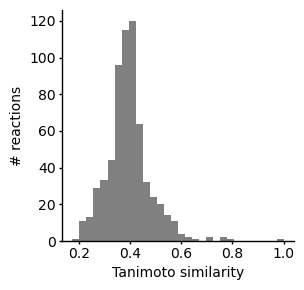

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (3,3)
plt.rcParams["svg.fonttype"] =  'none'

plt.hist(df['closest_dists_tanimoto'].values, bins=30, color='grey')
clean_plt(plt.gca())
plt.xlabel('Tanimoto similarity')
plt.ylabel('# reactions')
plt.savefig('figures/hist_reaction_similarity.svg')

In [6]:
df

,Unnamed: 0,culture_collection_entry,enzyme_name_from_paper,Uniprot_ID(if applicable),comment,reaction_smiles,parent_DNA_sequence,parent_aminoacid_sequence,aminoacid_mutations_from_parent,variant_DNA_sequence,...,raw data name,cannonical_reactions,named_reactions,errors,id,chemberta,rxnfp,closest_dists_tanimoto,closest_rxns_tanimoto,closest_ids_tanimoto
0,0,?,P411-L1,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,?,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,...,Asymmetric Carbene NH insertion 2021,CNc1ccccc1.[N-]=[N+]=C1CCOC1=O>>CN(c1ccccc1)[C...,3-diazooxolan-2-one + N-methylaniline =,NaN,RXN0,[-3.18922788e-01 1.72281623e-01 -6.81475759e-...,"[-1.3188741207122803, -0.9970054030418396, -1....",0.405714,C=COC(C)=O.CC(O)c1ccccc1>>C=CO.CC(=O)OC(C)c1cc...,3.1.1.3_197607
1,1,4978,P411-L7_FL,?,3b,O=C1OCCC1=[N+]=[N-].CCNC1=CC=CC=C1>>O=C1OCC[C@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_A264S_T327P_S332A_Q437L+FAD,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,...,Asymmetric Carbene NH insertion 2021,CCNc1ccccc1.[N-]=[N+]=C1CCOC1=O>>CCN(c1ccccc1)...,3-diazooxolan-2-one + N-ethylaniline =,NaN,RXN1,[ 2.34055489e-01 1.24196954e-01 -7.48595834e-...,"[-1.4010109901428223, -1.1337487697601318, -2....",0.384259,N[C@@H](CO)C(=O)O.c1ccc2c(c1)CCN2>>N[C@@H](CN1...,4.2.1.20_288520
2,2,4978,P411-L7_FL,?,3c,O=C1OCCC1=[N+]=[N-].CNC1=C(C)C=CC=C1>>O=C1OCC[...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_A264S_T327P_S332A_Q437L+FAD,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,...,Asymmetric Carbene NH insertion 2021,CNc1ccccc1C.[N-]=[N+]=C1CCOC1=O>>Cc1ccccc1N(C)...,"3-diazooxolan-2-one + N,2-dimethylaniline =",NaN,RXN2,[ 7.15660393e-01 2.18872964e-01 -1.25594771e+...,"[-1.552815556526184, -1.3202952146530151, -1.9...",0.394495,Cc1ccccc1C.O=C(O)/C=C/C(=O)O>>Cc1ccccc1CC(CC(=...,4.1.99.11_285078
3,3,4978,P411-L7_FL,?,3d,O=C1OCCC1=[N+]=[N-].CNC1=CC=C(C)C=C1>>O=C1OCC[...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_A264S_T327P_S332A_Q437L+FAD,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,...,Asymmetric Carbene NH insertion 2021,CNc1ccc(C)cc1.[N-]=[N+]=C1CCOC1=O>>Cc1ccc(N(C)...,"3-diazooxolan-2-one + N,4-dimethylaniline =",NaN,RXN3,[ 6.79048836e-01 9.90635574e-01 -6.78689480e-...,"[-1.3945786952972412, -1.4061739444732666, -1....",0.383929,COc1ccc(N2CC2C#N)cc1.O>>COc1ccc(N2CC2C(N)=O)cc1,4.2.1.84_290283
4,4,4978,P411-L7_FL,?,3e,O=C1OCCC1=[N+]=[N-].CNC1=CC=C(F)C=C1>>O=C1OCC[...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_A264S_T327P_S332A_Q437L+FAD,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,...,Asymmetric Carbene NH insertion 2021,CNc1ccc(F)cc1.[N-]=[N+]=C1CCOC1=O>>CN(c1ccc(F)...,3-diazooxolan-2-one + 4-fluoro-N-methylaniline =,NaN,RXN4,[ 8.95821750e-01 8.30273390e-01 -5.96083343e-...,"[-1.1718589067459106, -0.8995776772499084, -1....",0.383929,Cc1ccc(F)cc1.O=C(O)/C=C/C(=O)O>>O=C(O)CC(Cc1cc...,4.1.99.11_285134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,635,?,Rma-cyt-c-V75R_M100D_M103T,?,?,[BH3-]C1=[N+](C=CN1C)C.CC(C(OCC2=CC=CC=C2)=O)=...,ATGACTGAAAGCGGGACTGCTGCACAAGACCCGGAAGCACTGGCAG...,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,V75R_M100D_M103T,?,...,NaN,CC(=[N+]=[N-])C(=O)OCc1ccccc1.[BH3-]c1n(C)cc[n...,"(1,3-dimethylimidazol-1-ium-2-yl)boranuide + b...",NaN,RXN635,[ 1.29792809e+00 2.51425266e-01 -1.06932926e+...,"[-1.0578553676605225, -1.1442961692810059, -0....",0.374372,CC(=O)COCc1ccccc1.O=Cc1ccc([N+](=O)[O-])cc1>>C...,3.4.23.1_249361
636,636,NaN,Rma-cyt-c-V75R_M100D_M103F,?,?,[BH3-]C1=[N+](C=CN1C)C.O=C(OCC)C(C(F)(F)F)=[N+...,ATGACTGAAAGCGGGACTGCTGCACAAGACCCGGAAGCACTGGCAG...,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,V75R

In [29]:
from sciutil import SciUtil 

u = SciUtil()

reaction_df.to_pickle(f'output/reactions/reaction-similarity-{name}.pkl')
sorted = reaction_df.sort_values(by='dists', ascending=False)
u.dp([f'{name} closest distance:', sorted['dists'].values[0], '\nEC #', 
       sorted['ec_num'].values[0], '\n Reaction:', sorted['mapped'].values[0]])
closest_ids.append(sorted['id'].values[0])
closest_rxns.append(sorted['mapped'].values[0])
closest_dists.append(sorted['dists'].values[0])
u.warn_p(['Top 10 rxns:', '\n'.join(sorted['mapped'].values[0:10]), '\nEC numbers:', '\n'.join(sorted['id'].values[0:10])])
rxn_ded_df[f'closest_dists_tanimoto'] = closest_dists
rxn_ded_df[f'closest_rxns_tanimoto'] = closest_rxns
rxn_ded_df[f'closest_ids_tanimoto'] = closest_ids

--------------------------------------------------------------------------------
RXN0 closest distance:	0.4057142857142857	
EC #	3.1.1.3	
 Reaction:	[CH2:1]=[CH:2][O:3][C:4]([CH3:5])=[O:6].[CH3:7][CH:8]([OH:9])[c:10]1[cH:11][cH:12][cH:13][cH:14][cH:15]1>>[C:4]([CH3:5])(=[O:6])[O:9][CH:8]([CH3:7])[c:10]1[cH:11][cH:12][cH:13][cH:14][cH:15]1.[CH2:1]=[CH:2][OH:3]	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Top 10 rxns:	[CH2:1]=[CH:2][O:3][C:4]([CH3:5])=[O:6].[CH3:7][CH:8]([OH:9])[c:10]1[cH:11][cH:12][cH:13][cH:14][cH:15]1>>[C:4]([CH3:5])(=[O:6])[O:9][CH:8]([CH3:7])[c:10]1[cH:11][cH:12][cH:13][cH:14][cH:15]1.[CH2:1]=[CH:2][OH:3]
[CH3:1][C:2](=[O:3])[C:4](=[O:5])[OH:6].[O:7]=[CH:8][CH2:9][c:10]1[cH:11][cH:12][cH:13][cH:14][cH:15]1>>[C:4](=[O:5])=[O:6].[CH3:1][C:2](=[O:3])[CH:8]([OH:7])[CH2:9][c:10]1[cH:11][cH:12][cH:13][cH:14][cH:15]1
[CH3:1][c:2]1[cH:3][cH:4][cH:5][cH:6][cH

ValueError: Length of values (3) does not match length of index (640)

# Convert to concentration from yield

If activity is reported, convert with the substrate concentration to the activity_for_reaction_% (if applicable) otherwise multiply TTN.

In [7]:
def convert_to_yield(df, activity_col, substrate_conc_col):
    calc_yield = []
    errors = []
    for activity, substrate_mol in df[[activity_col, substrate_conc_col]].values:
        if substrate_mol:
            # Convert the substrate concentration to molar
            if 'mM' in substrate_mol:
                substrate_mol = float(substrate_mol.split('mM')[0].replace(' ', '')) * (10**(-3)) # divide by 1000
            elif 'nM' in substrate_mol:
                substrate_mol = float(substrate_mol.split('nM')[0].replace(' ', '')) * (10**(-9)) # divide by 10-9
            elif 'uM' in substrate_mol:
                substrate_mol = float(substrate_mol.split('uM')[0].replace(' ', '')) * (10**(-6)) # divide by 1000
            elif 'M' in substrate_mol:
                substrate_mol = float(substrate_mol.split('M').replace(' ', ''))
            else:
                substrate_mol = None
                calc_yield.append(None)
                errors.append(f'substrate mol had no concentrations, {substrate_mol}')
                continue
        else:
            calc_yield.append(None)
            errors.append(f'No mol: {substrate_mol}')
            continue
        if activity != '?':
            # If had `<` or `>` we just remove
            if '>' in activity or '<' in activity:
                activity = activity.replace('>', '')
                activity = activity.replace('<', '')
                errors.append('Had a > or <')
            elif activity == 'trace':
                activity = 0.0001
                errors.append('Trace activity, used 0.0001')
            else:
                errors.append(None)
            activity = float(activity)
            calc_yield.append(activity*substrate_mol)
        else:
            errors.append(f'No activity, {substrate_mol}')
            calc_yield.append(None)
    return calc_yield, errors

calc_yield, errors = convert_to_yield(protein_ded_df, 'activity_for_reaction_% (if applicable)', 'substrate_concentration')
protein_ded_df['yield_from_activity'] = calc_yield
protein_ded_df['errors_from_activity'] = errors


# Look at the embedding spaces independently and jointly



In [8]:
dpi=300
style='ticks'
palette='pastel'
opacity=0.8
default_colour="teal"
figsize=(4, 4)
title_font_size=12
label_font_size=8
title_font_weight="bold"
text_font_weight="bold"
font_family = 'sans-serif'
font = 'Arial'
sns.set(rc={'figure.figsize': figsize, 'font.family': font_family,
            'font.sans-serif': font, 'font.size': label_font_size}, 
        style=style)
plt.rcParams['font.family'] = font_family
plt.rcParams['font.sans-serif'] = font
sns.color_palette("viridis", as_cmap=True)

def format_fig(ax):
    ax.tick_params(direction='out', length=2, width=1.0)
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=12)
    ax.tick_params(axis='x', which='major', pad=2.0)
    ax.tick_params(axis='y', which='major', pad=2.0)

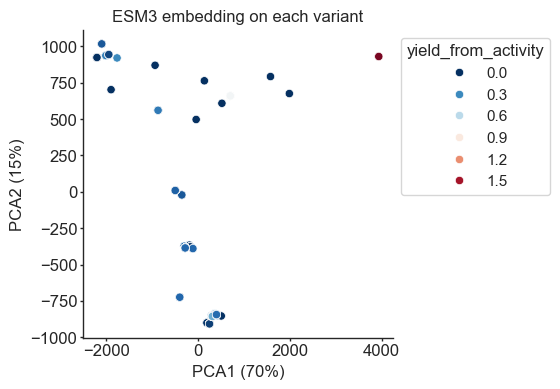

In [9]:
pca = PCA(n_components=2)
X = np.array([x for x in protein_ded_df['esm3_mean'].values])

pca_values = pca.fit_transform(X)
protein_ded_df['PCA1'] = pca_values[:, 0]
protein_ded_df['PCA2'] = pca_values[:, 1]

ax = sns.scatterplot(protein_ded_df, x='PCA1', y='PCA2', hue='yield_from_activity', palette='RdBu_r')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel(f'PCA1 ({int(pca.explained_variance_ratio_[0]*100)}%)')
plt.ylabel(f'PCA2 ({int(pca.explained_variance_ratio_[1]*100)}%)')
plt.title('ESM3 embedding on each variant')
ax = format_fig(ax)

## Look at this compared to natural enzymes 

In [10]:
protein_natural_df['EC class'] = [ec.split('.')[0] for ec in protein_natural_df['EC number'].values]

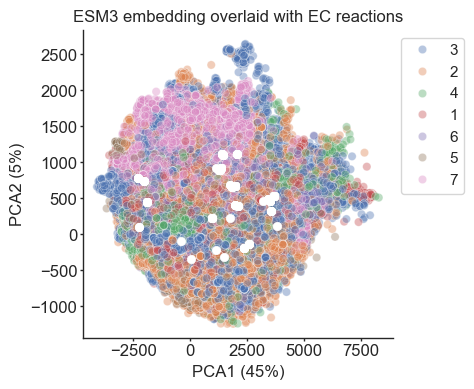

In [11]:
protein_natural_df['first author'] = 'Natural'
protein_ded_df['EC class'] = 'DED'
all_rxns = pd.concat([protein_ded_df, protein_natural_df])
pca = PCA(n_components=2)
X = np.array([np.array(x) for x in all_rxns['esm3_mean'].values]).reshape((len(all_rxns), len(all_rxns['esm3_mean'].values[0])))
pca_values = pca.fit_transform(X)
all_rxns['PCA1'] = pca_values[:, 0]
all_rxns['PCA2'] = pca_values[:, 1]

ax = sns.scatterplot(all_rxns[all_rxns['first author'] == 'Natural'], x='PCA1', y='PCA2', hue='EC class', alpha=0.4)
ax = sns.scatterplot(all_rxns[all_rxns['first author'] != 'Natural'], x='PCA1', y='PCA2', color='white')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel(f'PCA1 ({int(pca.explained_variance_ratio_[0]*100)}%)')
plt.ylabel(f'PCA2 ({int(pca.explained_variance_ratio_[1]*100)}%)')
plt.title('ESM3 embedding overlaid with EC reactions')
ax = format_fig(ax)

# Look at the reactions before joining again all together


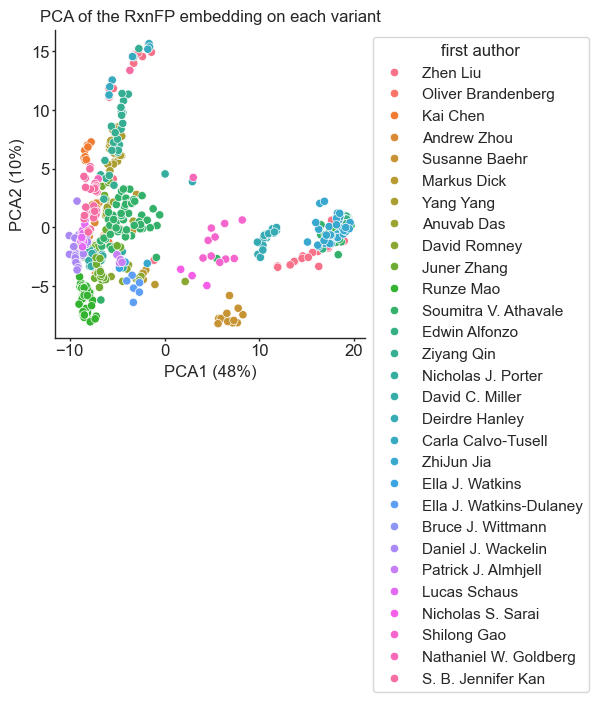

In [12]:
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sciviso import *


pca = PCA(n_components=2)

rxn_ded_df = pd.read_pickle('output/rxn_rxnfp.pkl')

X = np.array([x for x in rxn_ded_df['rxnfp'].values]).reshape((len(rxn_ded_df), len(rxn_ded_df['rxnfp'].values[0])))

pca_values = pca.fit_transform(X)
rxn_ded_df['PCA1'] = pca_values[:, 0]
rxn_ded_df['PCA2'] = pca_values[:, 1]

ax = sns.scatterplot(rxn_ded_df, x='PCA1', y='PCA2', hue='first author')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel(f'PCA1 ({int(pca.explained_variance_ratio_[0]*100)}%)')
plt.ylabel(f'PCA2 ({int(pca.explained_variance_ratio_[1]*100)}%)')
plt.title('PCA of the RxnFP embedding on each variant')
ax = format_fig(ax)

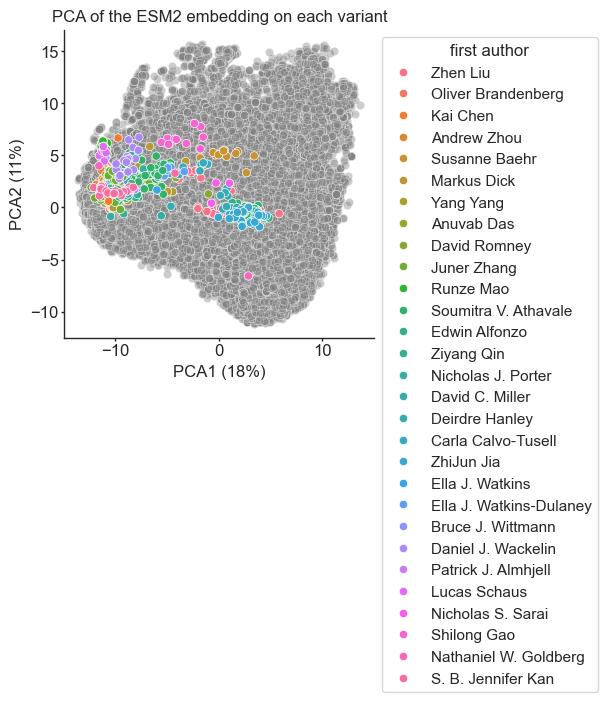

In [38]:
rxn_natural_df = pd.read_pickle('output/enzymemap_v2_brenda2023_reactions.pkl')
rxn_natural_df['first author'] = 'Natural'
all_rxns = pd.concat([rxn_natural_df, rxn_ded_df])
pca = PCA(n_components=2)
X = np.array([x for x in all_rxns['rxnfp'].values]).reshape((len(all_rxns), len(all_rxns['rxnfp'].values[0])))
pca_values = pca.fit_transform(X)
all_rxns['PCA1'] = pca_values[:, 0]
all_rxns['PCA2'] = pca_values[:, 1]

hue_order = [ 'Natural',
             'Andrew Zhou',
             'Anuvab Das',
             'Bruce J. Wittmann',
             'Carla Calvo-Tusell ',
             'Daniel J. Wackelin',
             'David C. Miller',
             'David Romney',
             'Deirdre Hanley',
             'Edwin Alfonzo',
             'Ella J. Watkins',
             'Ella J. Watkins-Dulaney',
             'Juner Zhang',
             'Kai Chen',
             'Lucas Schaus',
             'Markus Dick',
             'Nathaniel W. Goldberg',
             'Nicholas J. Porter',
             'Nicholas S. Sarai',
             'Oliver Brandenberg',
             'Patrick J. Almhjell',
             'Runze Mao',
             'S. B. Jennifer Kan',
             'Shilong Gao',
             'Soumitra V. Athavale',
             'Susanne Baehr',
             'Yang Yang',
             'Zhen Liu',
             'ZhiJun Jia',
             'Ziyang Qin']

ax = sns.scatterplot(all_rxns[all_rxns['first author'] == 'Natural'], x='PCA1', y='PCA2', color='grey', alpha=0.4)
ax = sns.scatterplot(all_rxns[all_rxns['first author'] != 'Natural'], x='PCA1', y='PCA2', hue='first author')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel(f'PCA1 ({int(pca.explained_variance_ratio_[0]*100)}%)')
plt.ylabel(f'PCA2 ({int(pca.explained_variance_ratio_[1]*100)}%)')
plt.title('PCA of the ESM2 embedding on each variant')
ax = format_fig(ax)

# Now we're going to join the two i.e. combine both of the enzyme/protein embeddings

In [39]:
rxn_natural_df = rxn_natural_df.drop_duplicates(subset=['ec_num'])
protein_natural_df = protein_natural_df.drop_duplicates(subset=['EC number'])
print(len(rxn_natural_df), len(protein_natural_df))

4552 6804


In [40]:
# Join the two 
rxn_natural_df = rxn_natural_df.set_index('ec_num')
protein_natural_df = protein_natural_df.set_index('EC number')
natural_df = rxn_natural_df.join(protein_natural_df, lsuffix='_protein', how='inner')
natural_df

,Unnamed: 0_protein,rxn_idx,mapped,unmapped,orig_rxn_text,rule,rule_id,source,steps,quality,...,active_encodings,Polarity,temperature,temp_level,cofactor,cofactor_encodings,embedding,esm3_mean,EC class,first author
3.1.3.12,217697,207073,[O:2]=[P:3]([OH:4])([OH:5])[O:6][CH2:7][C@H:8]...,O.O=P(O)(O)OC[C@H]1O[C@H](O[C@H]2O[C@H](CO)[C@...,"alpha,alpha-trehalose 6-phosphate + H2O = alph...",[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],279,direct,single,1.000000,...,[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0.000000,NaN,NaN,['Mg(2+)'],[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. ...,"[0.01774806, -0.06680477, -0.0014534739, -0.01...","[29.178518, -64.76266, 61.817024, -8.913335, -...",3,Natural
3.1.1.81,213467,202567,[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5][C:6](=[O:7...,CCCCCC(=O)N[C@H]1CCOC1=O.O>>CCCCCC(=O)N[C@@H](...,N-hexanoyl-L-homoserine lactone + H2O = N-hexa...,[#6:1]-[#8:2].[#8:3]>>([#8:2].[#6:1]-[#8:3]),287,direct,single,0.973366,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,30.0,species,[Zn(2+)],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.036601048, -0.025433065, -0.0018129623, -0...","[13.164559, -21.289932, -17.425348, -63.70747,...",3,Natural
1.2.1.44,82865,67205,[CH3:1][C:2]([CH3:3])([CH2:4][O:5][P:6](=[O:7]...,CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc...,4-coumaroyl-CoA + NADPH + H+ = 4-coumaraldehyd...,[#6:1]-[#16:2].[#6:3]1=[#6:4]-[#7:5]-[#6:6]=[#...,100,direct,single,1.000000,...,[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. ...,0.000000,NaN,NaN,NaN,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[0.011697134, 0.03570128, 0.03830788, -0.00098...","[-43.45127, 73.150826, -60.03495, 8.317648, 13...",1,Natural
2.5.1.18,155319,147675,[NH2:1][C@@H:2]([CH2:3][CH2:4][C:5](=[O:6])[NH...,N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O...,"1-chloro-2,4-dinitrobenzene + glutathione = S-...",[#16:1].[#6:2]-[#17:3]>>[#17:3].[#6:2]-[#16:1],325,direct,single,0.907895,...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0.000000,NaN,NaN,NaN,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[-0.019245792, 0.009193553, 0.039562628, -0.04...","[14.486596, -5.6772914, 53.57653, 4.1528993, 5...",2,Natural
3.2.1.37,242182,228243,[O:2]=[N+:3]([O-:4])[c:5]1[cH:6][cH:7][c:8]([O...,O.O=[N+]([O-])c1ccc(O[C@@H]2OC[C@@H](O)[C@H](O...,4-nitrophenyl beta-D-xyloside + H2O = 4-nitrop...,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],279,direct,single,0.998243,...,[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0.000000,31.0,species,NaN,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[-0.048603408, -0.012662074, -0.037163626, -0....","[-31.202702, 4.4142566, -22.157946, 24.046446,...",3,Natural
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.3.1.41,128332,117826,[CH3:1][C:2]([CH3:3])([CH2:4][O:5][P:6](=[O:7]...,CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc...,Malonyl-CoA = Acetyl-CoA + CO2,[#6:1]-[#6:2]-[#8:3]>>[#6:1].[#6:2]=[#8:3],92,direct,single,1.000000,...,[1. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0.333333,36.0,species,NaN,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[-0.040636655, -0.0023630767, -0.041519113, -0...","[3.3516393, 46.489548, -40.412838, -14.946769,...",2,Natural
2.3.1.39,128261,117589,[CH3:19][C:20]([CH3:21])([CH2:22][O:23][P:24](...,CC(C)(CO)[C@@H](O)C(=O)NCCC(=O)NCCS.CC(C)(COP(...,malonyl-CoA + pantetheine = malonyl-pantethein...,[#6:1]-[#16:2].[#7:3]>>[#16:2].[#6:1]-[#7:3],283,direct,single,0.333333,...,[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. ...,0.500000,NaN,NaN,NaN,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[-0.043407224, -0.016215881, 0.056216322, -0.0...","[72.389755, -65.4996, 54.1981, 22.779016, -6.2...",2,Natural
2.4.1.102,138185,128878,[CH3:1][C:2](=[O:3])[NH:4][C@H:5]1[C@@H:6]([O:...,CC(=O)N[C@H]1[C@@H](OP(=O)(O)OP(=O)(O)OC[C@H]2...,UDP-N-acetyl-D-glucosamine + beta-D-galactosyl...,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],279,direct,multi,1.000000,...,[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ..

# Read in the database file with no errors and then join the two


Join rxn_ded_df using reaction_smiles and then also join the protein embedding DF using the 

In [65]:
df = pd.read_csv('output/protein-evolution-database_V4_proteins_reactions_clean.csv', index_col=0)
# Map between protein embeddings based on the id
id_to_protein_embedding = dict(zip(protein_ded_df.variant_aa, protein_ded_df.esm3_mean))
# Also do the reaction
reaction_to_embedding = dict(zip(rxn_ded_df.reaction_smiles, rxn_ded_df.rxnfp))
df['protein_ESM3B'] = [id_to_protein_embedding.get(i) for i in df['variant_aa'].values]
df['reaction_rxnfp'] = [reaction_to_embedding.get(i) for i in df['reaction_smiles'].values]
df.to_pickle('output/protein-evolution-database_V4_ALL.pkl')

# Now we can plot the reaction and the protein PCA's against one another

In [66]:
pca = PCA(n_components=2)
df = df.dropna(subset=['protein_ESM3B'])
X = np.array([x for x in df['protein_ESM3B'].values])

pca_values = pca.fit_transform(X)
df['PCA1_protein_ESM3B'] = pca_values[:, 0]
df['PCA2_protein_ESM3B'] = pca_values[:, 1]

# Now do the same for the reaction
df = df.dropna(subset=['reaction_rxnfp'])
X = np.array([x for x in df['reaction_rxnfp'].values])

pca_values = pca.fit_transform(X)
df['PCA1_reaction_rxnfp'] = pca_values[:, 0]
df['PCA2_reaction_rxnfp'] = pca_values[:, 1]


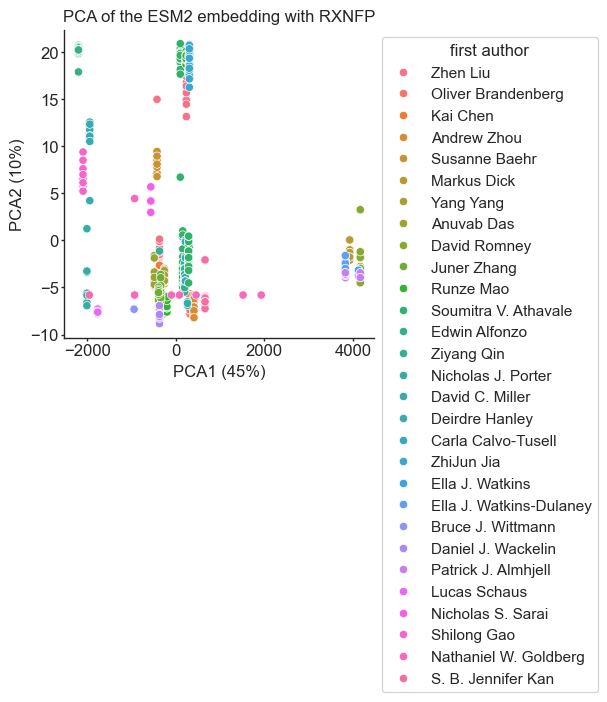

In [68]:
ax = sns.scatterplot(df, x='PCA1_protein_ESM3B', y='PCA1_reaction_rxnfp', hue='first author')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel(f'PCA1 ({int(pca.explained_variance_ratio_[0]*100)}%)')
plt.ylabel(f'PCA2 ({int(pca.explained_variance_ratio_[1]*100)}%)')
plt.title('PCA of the ESM2 embedding with RXNFP')
ax = format_fig(ax)

(array([ 4.,  0.,  9.,  0.,  0., 11.,  0.,  8.,  0.,  4.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

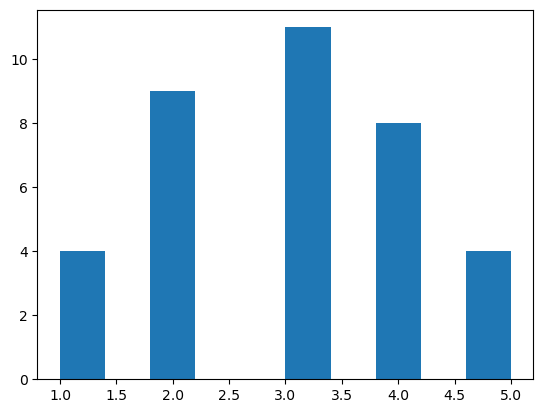

In [3]:
import pandas as pd

df = pd.read_csv('DEDB/LevSeq-metadata_formatted_protein-evolution-database_V4.csv')
num_substrates = [len(s.split('.')) for s in df['substrate_smiles'].values]
df['# substrates'] = num_substrates
import matplotlib.pyplot as plt

plt.hist(df['# substrates'].values)